<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/Final_LSTM_Team_Project_XOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Team Project
## By changes parameter setting you create, train and predict an array of model to predict stocks.



#Code Section

In [2]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=f12662c4dfc4eca56836b6e8390dfc4a8f16dfe51e584b720cd662bd2ad309c3
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [4]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = None
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()



    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


    def calculate_aic(self,y_true, y_pred,n_params):

        mse = mean_squared_error(y_true, y_pred)
        n = len(y_true)
        aic = n * np.log(mse) + 2 * n_params
        return aic



     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

        #AIC
        self.aic = self.calculate_aic(self.y_test,self.y_pred,self.lstm_nodes)




         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print(f'                      AIC ={self.aic}')

        print("")

        #Plot Graph



        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)

          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')


          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorrect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show




    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [8]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Machine Learning/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicators','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean','elapsTime','pred_correctness_mean','AIC']

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicators':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time,
                           "pred_correctness_mean":m.pred_correctness_mean,
                           "AIC":m.aic
                            })


# Get Fields








# Model Fit Section

# Model Training

In [6]:
Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]


#AMD
#Ticker = ['ADM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]

#MSI
#Ticker = ['ADM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]

#XOM
Ticker = ['XOM']
frame_days = [10,25,50,75,100]
LSTM_layers = [1,2,3,4,5]



Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} models')


Testing 25 models


In [7]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L1___________
Start Time:2024-04-30 22:56:17.689819
Epoch 1/30
122/122 - 7s - loss: 0.0150 - mae: 0.0827 - val_loss: 0.3196 - val_mae: 0.4785 - 7s/epoch - 60ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0074 - mae: 0.0690 - val_loss: 0.2612 - val_mae: 0.4308 - 3s/epoch - 23ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0066 - mae: 0.0652 - val_loss: 0.1833 - val_mae: 0.3552 - 2s/epoch - 13ms/step
Epoch 4/30
122/122 - 1s - loss: 0.0078 - mae: 0.0594 - val_loss: 0.1187 - val_mae: 0.2859 - 1s/epoch - 11ms/step
Epoch 5/30
122/122 - 1s - loss: 0.0081 - mae: 0.0607 - val_loss: 0.0950 - val_mae: 0.2550 - 1s/epoch - 11ms/step
Epoch 6/30
122/122 - 1s - loss: 0.0077 - mae: 0.0627 - val_loss: 0.0792 - val_mae: 0.2318 - 1s/epoch - 11ms/step
Epoch 7/30
122/122 - 1s - loss: 0.0064 - mae: 0.0582 - val_loss: 0.0683 - val_mae: 0.2143 - 1s/epoch - 12ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0054 - mae: 0.0536 - val_loss: 0.0610 - val_mae: 0.2025 - 1s/epoch - 11ms/step
Epoch 9/30
122/122 - 2s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L2___________
Start Time:2024-04-30 22:57:46.148742
Epoch 1/30
122/122 - 7s - loss: 0.0107 - mae: 0.0651 - val_loss: 0.1525 - val_mae: 0.3198 - 7s/epoch - 55ms/step
Epoch 2/30
122/122 - 1s - loss: 0.0036 - mae: 0.0483 - val_loss: 0.1732 - val_mae: 0.3681 - 1s/epoch - 11ms/step
Epoch 3/30
122/122 - 1s - loss: 0.0027 - mae: 0.0422 - val_loss: 0.1262 - val_mae: 0.3128 - 1s/epoch - 11ms/step
Epoch 4/30
122/122 - 1s - loss: 0.0031 - mae: 0.0430 - val_loss: 0.1337 - val_mae: 0.3344 - 1s/epoch - 11ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0035 - mae: 0.0442 - val_loss: 0.1643 - val_mae: 0.3840 - 2s/epoch - 15ms/step
Epoch 6/30
122/122 - 2s - loss: 0.0039 - mae: 0.0475 - val_loss: 0.1160 - val_mae: 0.3151 - 2s/epoch - 18ms/step
Epoch 7/30
122/122 - 1s - loss: 0.0036 - mae: 0.0472 - val_loss: 0.0834 - val_mae: 0.2597 - 1s/epoch - 12ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0041 - mae: 0.0510 - val_loss: 0.0558 - val_mae: 0.1987 - 1s/epoch - 11ms/step
Epoch 9/30
122/122 - 1s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L3___________
Start Time:2024-04-30 22:58:42.193667
Epoch 1/30
122/122 - 9s - loss: 0.0046 - mae: 0.0475 - val_loss: 0.1354 - val_mae: 0.2998 - 9s/epoch - 72ms/step
Epoch 2/30
122/122 - 2s - loss: 0.0027 - mae: 0.0387 - val_loss: 0.1606 - val_mae: 0.3498 - 2s/epoch - 17ms/step
Epoch 3/30
122/122 - 3s - loss: 0.0021 - mae: 0.0367 - val_loss: 0.1288 - val_mae: 0.3150 - 3s/epoch - 23ms/step
Epoch 4/30
122/122 - 2s - loss: 0.0026 - mae: 0.0402 - val_loss: 0.0558 - val_mae: 0.1867 - 2s/epoch - 17ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0024 - mae: 0.0392 - val_loss: 0.1080 - val_mae: 0.3045 - 2s/epoch - 16ms/step
Epoch 6/30
122/122 - 2s - loss: 0.0043 - mae: 0.0476 - val_loss: 0.1170 - val_mae: 0.3245 - 2s/epoch - 16ms/step
Epoch 7/30
122/122 - 2s - loss: 0.0031 - mae: 0.0444 - val_loss: 0.2081 - val_mae: 0.4450 - 2s/epoch - 16ms/step
Epoch 8/30
122/122 - 2s - loss: 0.0045 - mae: 0.0540 - val_loss: 0.0436 - val_mae: 0.1726 - 2s/epoch - 16ms/step
Epoch 9/30
122/122 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L4___________
Start Time:2024-04-30 22:59:59.289937
Epoch 1/30
122/122 - 13s - loss: 0.0059 - mae: 0.0521 - val_loss: 0.1338 - val_mae: 0.2946 - 13s/epoch - 108ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0034 - mae: 0.0428 - val_loss: 0.2323 - val_mae: 0.4372 - 3s/epoch - 21ms/step
Epoch 3/30
122/122 - 3s - loss: 0.0032 - mae: 0.0436 - val_loss: 0.0603 - val_mae: 0.1977 - 3s/epoch - 27ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0026 - mae: 0.0416 - val_loss: 0.1576 - val_mae: 0.3665 - 3s/epoch - 25ms/step
Epoch 5/30
122/122 - 4s - loss: 0.0032 - mae: 0.0457 - val_loss: 0.1909 - val_mae: 0.4137 - 4s/epoch - 30ms/step
Epoch 6/30
122/122 - 2s - loss: 0.0029 - mae: 0.0409 - val_loss: 0.0432 - val_mae: 0.1631 - 2s/epoch - 20ms/step
Epoch 7/30
122/122 - 3s - loss: 0.0028 - mae: 0.0419 - val_loss: 0.0889 - val_mae: 0.2622 - 3s/epoch - 21ms/step
Epoch 8/30
122/122 - 4s - loss: 0.0044 - mae: 0.0530 - val_loss: 0.0847 - val_mae: 0.2650 - 4s/epoch - 31ms/step
Epoch 9/30
122/122 - 2

[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L5___________
Start Time:2024-04-30 23:02:33.944929
Epoch 1/30
122/122 - 17s - loss: 0.0077 - mae: 0.0566 - val_loss: 0.1106 - val_mae: 0.2623 - 17s/epoch - 138ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0049 - mae: 0.0515 - val_loss: 0.2113 - val_mae: 0.4030 - 3s/epoch - 25ms/step
Epoch 3/30
122/122 - 4s - loss: 0.0034 - mae: 0.0459 - val_loss: 0.1326 - val_mae: 0.3090 - 4s/epoch - 30ms/step
Epoch 4/30
122/122 - 4s - loss: 0.0049 - mae: 0.0551 - val_loss: 0.0618 - val_mae: 0.2078 - 4s/epoch - 29ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0047 - mae: 0.0522 - val_loss: 0.0860 - val_mae: 0.2392 - 3s/epoch - 24ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0029 - mae: 0.0434 - val_loss: 0.1575 - val_mae: 0.3594 - 3s/epoch - 24ms/step
Epoch 7/30
122/122 - 3s - loss: 0.0026 - mae: 0.0410 - val_loss: 0.1253 - val_mae: 0.3263 - 3s/epoch - 26ms/step
Epoch 8/30
122/122 - 4s - loss: 0.0038 - mae: 0.0508 - val_loss: 0.0992 - val_mae: 0.2830 - 4s/epoch - 32ms/step
Epoch 9/30
122/122 - 3

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L1___________
Start Time:2024-04-30 23:04:29.710239
Epoch 1/30
121/121 - 4s - loss: 0.0089 - mae: 0.0700 - val_loss: 0.2187 - val_mae: 0.4116 - 4s/epoch - 36ms/step
Epoch 2/30
121/121 - 2s - loss: 0.0056 - mae: 0.0566 - val_loss: 0.1592 - val_mae: 0.3444 - 2s/epoch - 18ms/step
Epoch 3/30
121/121 - 2s - loss: 0.0039 - mae: 0.0524 - val_loss: 0.0809 - val_mae: 0.2373 - 2s/epoch - 15ms/step
Epoch 4/30
121/121 - 2s - loss: 0.0059 - mae: 0.0527 - val_loss: 0.0730 - val_mae: 0.2261 - 2s/epoch - 17ms/step
Epoch 5/30
121/121 - 2s - loss: 0.0033 - mae: 0.0409 - val_loss: 0.0748 - val_mae: 0.2351 - 2s/epoch - 14ms/step
Epoch 6/30
121/121 - 1s - loss: 0.0030 - mae: 0.0404 - val_loss: 0.0706 - val_mae: 0.2311 - 1s/epoch - 11ms/step
Epoch 7/30
121/121 - 1s - loss: 0.0032 - mae: 0.0425 - val_loss: 0.0650 - val_mae: 0.2215 - 1s/epoch - 11ms/step
Epoch 8/30
121/121 - 1s - loss: 0.0034 - mae: 0.0445 - val_loss: 0.0693 - val_mae: 0.2346 - 1s/epoch - 11ms/step
Epoch 9/30
121/121 - 2s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L2___________
Start Time:2024-04-30 23:05:56.067985
Epoch 1/30
121/121 - 7s - loss: 0.0060 - mae: 0.0536 - val_loss: 0.1633 - val_mae: 0.3401 - 7s/epoch - 59ms/step
Epoch 2/30
121/121 - 3s - loss: 0.0038 - mae: 0.0469 - val_loss: 0.1546 - val_mae: 0.3279 - 3s/epoch - 22ms/step
Epoch 3/30
121/121 - 4s - loss: 0.0036 - mae: 0.0490 - val_loss: 0.1083 - val_mae: 0.2631 - 4s/epoch - 32ms/step
Epoch 4/30
121/121 - 3s - loss: 0.0035 - mae: 0.0476 - val_loss: 0.1038 - val_mae: 0.2581 - 3s/epoch - 22ms/step
Epoch 5/30
121/121 - 3s - loss: 0.0042 - mae: 0.0508 - val_loss: 0.0796 - val_mae: 0.2258 - 3s/epoch - 21ms/step
Epoch 6/30
121/121 - 3s - loss: 0.0045 - mae: 0.0500 - val_loss: 0.0649 - val_mae: 0.2040 - 3s/epoch - 22ms/step
Epoch 7/30
121/121 - 3s - loss: 0.0055 - mae: 0.0557 - val_loss: 0.0537 - val_mae: 0.1854 - 3s/epoch - 24ms/step
Epoch 8/30
121/121 - 4s - loss: 0.0054 - mae: 0.0575 - val_loss: 0.0682 - val_mae: 0.2139 - 4s/epoch - 30ms/step
Epoch 9/30
121/121 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L3___________
Start Time:2024-04-30 23:08:23.822363
Epoch 1/30
121/121 - 13s - loss: 0.0057 - mae: 0.0546 - val_loss: 0.1814 - val_mae: 0.3617 - 13s/epoch - 104ms/step
Epoch 2/30
121/121 - 4s - loss: 0.0029 - mae: 0.0430 - val_loss: 0.1931 - val_mae: 0.3809 - 4s/epoch - 31ms/step
Epoch 3/30
121/121 - 4s - loss: 0.0028 - mae: 0.0425 - val_loss: 0.1376 - val_mae: 0.3145 - 4s/epoch - 31ms/step
Epoch 4/30
121/121 - 5s - loss: 0.0035 - mae: 0.0434 - val_loss: 0.0569 - val_mae: 0.1887 - 5s/epoch - 44ms/step
Epoch 5/30
121/121 - 4s - loss: 0.0030 - mae: 0.0422 - val_loss: 0.1876 - val_mae: 0.3747 - 4s/epoch - 31ms/step
Epoch 6/30
121/121 - 4s - loss: 0.0039 - mae: 0.0492 - val_loss: 0.0667 - val_mae: 0.2084 - 4s/epoch - 31ms/step
Epoch 7/30
121/121 - 5s - loss: 0.0039 - mae: 0.0490 - val_loss: 0.0885 - val_mae: 0.2370 - 5s/epoch - 39ms/step
Epoch 8/30
121/121 - 4s - loss: 0.0030 - mae: 0.0436 - val_loss: 0.0625 - val_mae: 0.2008 - 4s/epoch - 35ms/step
Epoch 9/30
121/121 - 4

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L4___________
Start Time:2024-04-30 23:10:55.285245
Epoch 1/30
121/121 - 15s - loss: 0.0039 - mae: 0.0435 - val_loss: 0.1932 - val_mae: 0.3871 - 15s/epoch - 127ms/step
Epoch 2/30
121/121 - 5s - loss: 0.0023 - mae: 0.0391 - val_loss: 0.2720 - val_mae: 0.4815 - 5s/epoch - 43ms/step
Epoch 3/30
121/121 - 7s - loss: 0.0026 - mae: 0.0402 - val_loss: 0.0843 - val_mae: 0.2338 - 7s/epoch - 55ms/step
Epoch 4/30
121/121 - 5s - loss: 0.0030 - mae: 0.0431 - val_loss: 0.3003 - val_mae: 0.4997 - 5s/epoch - 43ms/step
Epoch 5/30
121/121 - 6s - loss: 0.0028 - mae: 0.0423 - val_loss: 0.2575 - val_mae: 0.4584 - 6s/epoch - 47ms/step
Epoch 6/30
121/121 - 8s - loss: 0.0032 - mae: 0.0453 - val_loss: 0.3229 - val_mae: 0.5336 - 8s/epoch - 63ms/step
Epoch 7/30
121/121 - 5s - loss: 0.0045 - mae: 0.0486 - val_loss: 0.0698 - val_mae: 0.2099 - 5s/epoch - 41ms/step
Epoch 8/30
121/121 - 7s - loss: 0.0053 - mae: 0.0579 - val_loss: 0.2626 - val_mae: 0.4760 - 7s/epoch - 55ms/step
Epoch 9/30
121/121 - 5

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L5___________
Start Time:2024-04-30 23:14:27.822302
Epoch 1/30
121/121 - 20s - loss: 0.0060 - mae: 0.0566 - val_loss: 0.2073 - val_mae: 0.3843 - 20s/epoch - 167ms/step
Epoch 2/30
121/121 - 7s - loss: 0.0040 - mae: 0.0484 - val_loss: 0.1169 - val_mae: 0.2765 - 7s/epoch - 57ms/step
Epoch 3/30
121/121 - 7s - loss: 0.0035 - mae: 0.0467 - val_loss: 0.2356 - val_mae: 0.4180 - 7s/epoch - 57ms/step
Epoch 4/30
121/121 - 7s - loss: 0.0054 - mae: 0.0552 - val_loss: 0.0808 - val_mae: 0.2277 - 7s/epoch - 57ms/step
Epoch 5/30
121/121 - 7s - loss: 0.0065 - mae: 0.0637 - val_loss: 0.0773 - val_mae: 0.2280 - 7s/epoch - 55ms/step
Epoch 6/30
121/121 - 8s - loss: 0.0046 - mae: 0.0537 - val_loss: 0.1008 - val_mae: 0.2537 - 8s/epoch - 69ms/step
Epoch 7/30
121/121 - 7s - loss: 0.0060 - mae: 0.0557 - val_loss: 0.0622 - val_mae: 0.1949 - 7s/epoch - 59ms/step
Epoch 8/30
121/121 - 6s - loss: 0.0099 - mae: 0.0777 - val_loss: 0.0557 - val_mae: 0.1828 - 6s/epoch - 54ms/step
Epoch 9/30
121/121 - 7

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L1___________
Start Time:2024-04-30 23:19:03.237856
Epoch 1/30
120/120 - 6s - loss: 0.0043 - mae: 0.0502 - val_loss: 0.1621 - val_mae: 0.3219 - 6s/epoch - 53ms/step
Epoch 2/30
120/120 - 2s - loss: 0.0026 - mae: 0.0398 - val_loss: 0.1480 - val_mae: 0.3274 - 2s/epoch - 20ms/step
Epoch 3/30
120/120 - 2s - loss: 0.0057 - mae: 0.0533 - val_loss: 0.1180 - val_mae: 0.2819 - 2s/epoch - 20ms/step
Epoch 4/30
120/120 - 2s - loss: 0.0057 - mae: 0.0491 - val_loss: 0.1146 - val_mae: 0.2825 - 2s/epoch - 20ms/step
Epoch 5/30
120/120 - 2s - loss: 0.0052 - mae: 0.0492 - val_loss: 0.0966 - val_mae: 0.2578 - 2s/epoch - 20ms/step
Epoch 6/30
120/120 - 4s - loss: 0.0061 - mae: 0.0549 - val_loss: 0.0796 - val_mae: 0.2327 - 4s/epoch - 29ms/step
Epoch 7/30
120/120 - 2s - loss: 0.0071 - mae: 0.0618 - val_loss: 0.0696 - val_mae: 0.2165 - 2s/epoch - 19ms/step
Epoch 8/30
120/120 - 2s - loss: 0.0071 - mae: 0.0624 - val_loss: 0.0613 - val_mae: 0.2026 - 2s/epoch - 19ms/step
Epoch 9/30
120/120 - 2s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L2___________
Start Time:2024-04-30 23:20:29.690855
Epoch 1/30
120/120 - 12s - loss: 0.0102 - mae: 0.0627 - val_loss: 0.2440 - val_mae: 0.4317 - 12s/epoch - 99ms/step
Epoch 2/30
120/120 - 6s - loss: 0.0034 - mae: 0.0459 - val_loss: 0.2641 - val_mae: 0.4646 - 6s/epoch - 53ms/step
Epoch 3/30
120/120 - 5s - loss: 0.0035 - mae: 0.0491 - val_loss: 0.2408 - val_mae: 0.4476 - 5s/epoch - 41ms/step
Epoch 4/30
120/120 - 5s - loss: 0.0029 - mae: 0.0429 - val_loss: 0.2016 - val_mae: 0.4149 - 5s/epoch - 45ms/step
Epoch 5/30
120/120 - 6s - loss: 0.0036 - mae: 0.0461 - val_loss: 0.2854 - val_mae: 0.5164 - 6s/epoch - 47ms/step
Epoch 6/30
120/120 - 5s - loss: 0.0045 - mae: 0.0497 - val_loss: 0.0581 - val_mae: 0.1959 - 5s/epoch - 42ms/step
Epoch 7/30
120/120 - 6s - loss: 0.0039 - mae: 0.0493 - val_loss: 0.1202 - val_mae: 0.3115 - 6s/epoch - 54ms/step
Epoch 8/30
120/120 - 5s - loss: 0.0060 - mae: 0.0610 - val_loss: 0.0797 - val_mae: 0.2573 - 5s/epoch - 41ms/step
Epoch 9/30
120/120 - 5s

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L3___________
Start Time:2024-04-30 23:23:59.677124
Epoch 1/30
120/120 - 15s - loss: 0.0030 - mae: 0.0427 - val_loss: 0.1511 - val_mae: 0.3273 - 15s/epoch - 126ms/step
Epoch 2/30
120/120 - 7s - loss: 0.0027 - mae: 0.0405 - val_loss: 0.1763 - val_mae: 0.3589 - 7s/epoch - 58ms/step
Epoch 3/30
120/120 - 8s - loss: 0.0029 - mae: 0.0420 - val_loss: 0.0978 - val_mae: 0.2477 - 8s/epoch - 69ms/step
Epoch 4/30
120/120 - 7s - loss: 0.0031 - mae: 0.0449 - val_loss: 0.1710 - val_mae: 0.3558 - 7s/epoch - 57ms/step
Epoch 5/30
120/120 - 9s - loss: 0.0052 - mae: 0.0580 - val_loss: 0.1081 - val_mae: 0.2629 - 9s/epoch - 71ms/step
Epoch 6/30
120/120 - 9s - loss: 0.0043 - mae: 0.0520 - val_loss: 0.1331 - val_mae: 0.3103 - 9s/epoch - 75ms/step
Epoch 7/30
120/120 - 8s - loss: 0.0056 - mae: 0.0555 - val_loss: 0.0805 - val_mae: 0.2293 - 8s/epoch - 66ms/step
Epoch 8/30
120/120 - 9s - loss: 0.0040 - mae: 0.0494 - val_loss: 0.0799 - val_mae: 0.2270 - 9s/epoch - 75ms/step
Epoch 9/30
120/120 - 7

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L4___________
Start Time:2024-04-30 23:28:10.652648
Epoch 1/30
120/120 - 21s - loss: 0.0056 - mae: 0.0514 - val_loss: 0.2250 - val_mae: 0.4121 - 21s/epoch - 179ms/step
Epoch 2/30
120/120 - 10s - loss: 0.0032 - mae: 0.0430 - val_loss: 0.2197 - val_mae: 0.4065 - 10s/epoch - 84ms/step
Epoch 3/30
120/120 - 10s - loss: 0.0037 - mae: 0.0482 - val_loss: 0.2719 - val_mae: 0.4744 - 10s/epoch - 83ms/step
Epoch 4/30
120/120 - 11s - loss: 0.0075 - mae: 0.0582 - val_loss: 0.0723 - val_mae: 0.2168 - 11s/epoch - 88ms/step
Epoch 5/30
120/120 - 11s - loss: 0.0072 - mae: 0.0666 - val_loss: 0.0817 - val_mae: 0.2295 - 11s/epoch - 96ms/step
Epoch 6/30
120/120 - 10s - loss: 0.0055 - mae: 0.0584 - val_loss: 0.2540 - val_mae: 0.4534 - 10s/epoch - 82ms/step
Epoch 7/30
120/120 - 11s - loss: 0.0045 - mae: 0.0532 - val_loss: 0.1073 - val_mae: 0.2657 - 11s/epoch - 88ms/step
Epoch 8/30
120/120 - 11s - loss: 0.0069 - mae: 0.0634 - val_loss: 0.0633 - val_mae: 0.1999 - 11s/epoch - 88ms/step
Epoch 9/

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L5___________
Start Time:2024-04-30 23:33:44.075143
Epoch 1/30
120/120 - 25s - loss: 0.0059 - mae: 0.0562 - val_loss: 0.1696 - val_mae: 0.3385 - 25s/epoch - 210ms/step
Epoch 2/30
120/120 - 13s - loss: 0.0055 - mae: 0.0538 - val_loss: 0.1530 - val_mae: 0.3194 - 13s/epoch - 111ms/step
Epoch 3/30
120/120 - 13s - loss: 0.0033 - mae: 0.0460 - val_loss: 0.2212 - val_mae: 0.4089 - 13s/epoch - 111ms/step
Epoch 4/30
120/120 - 13s - loss: 0.0041 - mae: 0.0453 - val_loss: 0.1090 - val_mae: 0.2613 - 13s/epoch - 109ms/step
Epoch 5/30
120/120 - 12s - loss: 0.0084 - mae: 0.0704 - val_loss: 0.0787 - val_mae: 0.2296 - 12s/epoch - 102ms/step
Epoch 6/30
120/120 - 12s - loss: 0.0059 - mae: 0.0588 - val_loss: 0.2158 - val_mae: 0.4074 - 12s/epoch - 102ms/step
Epoch 7/30
120/120 - 13s - loss: 0.0063 - mae: 0.0569 - val_loss: 0.0657 - val_mae: 0.2084 - 13s/epoch - 107ms/step
Epoch 8/30
120/120 - 13s - loss: 0.0069 - mae: 0.0675 - val_loss: 0.3318 - val_mae: 0.5269 - 13s/epoch - 111ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L1___________
Start Time:2024-04-30 23:41:19.829907
Epoch 1/30
119/119 - 6s - loss: 0.0059 - mae: 0.0554 - val_loss: 0.1462 - val_mae: 0.3387 - 6s/epoch - 48ms/step
Epoch 2/30
119/119 - 4s - loss: 0.0024 - mae: 0.0398 - val_loss: 0.0500 - val_mae: 0.1751 - 4s/epoch - 34ms/step
Epoch 3/30
119/119 - 4s - loss: 0.0023 - mae: 0.0375 - val_loss: 0.0909 - val_mae: 0.2589 - 4s/epoch - 32ms/step
Epoch 4/30
119/119 - 3s - loss: 0.0028 - mae: 0.0358 - val_loss: 0.0888 - val_mae: 0.2512 - 3s/epoch - 27ms/step
Epoch 5/30
119/119 - 3s - loss: 0.0019 - mae: 0.0310 - val_loss: 0.0950 - val_mae: 0.2649 - 3s/epoch - 27ms/step
Epoch 6/30
119/119 - 4s - loss: 0.0024 - mae: 0.0344 - val_loss: 0.0922 - val_mae: 0.2607 - 4s/epoch - 35ms/step
Epoch 7/30
119/119 - 4s - loss: 0.0028 - mae: 0.0370 - val_loss: 0.0898 - val_mae: 0.2564 - 4s/epoch - 31ms/step
Epoch 8/30
119/119 - 3s - loss: 0.0032 - mae: 0.0392 - val_loss: 0.0964 - val_mae: 0.2666 - 3s/epoch - 27ms/step
Epoch 9/30
119/119 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L2___________
Start Time:2024-04-30 23:43:14.818499
Epoch 1/30
119/119 - 14s - loss: 0.0068 - mae: 0.0514 - val_loss: 0.1652 - val_mae: 0.3403 - 14s/epoch - 119ms/step
Epoch 2/30
119/119 - 8s - loss: 0.0030 - mae: 0.0436 - val_loss: 0.1523 - val_mae: 0.3226 - 8s/epoch - 67ms/step
Epoch 3/30
119/119 - 7s - loss: 0.0028 - mae: 0.0427 - val_loss: 0.1396 - val_mae: 0.3106 - 7s/epoch - 55ms/step
Epoch 4/30
119/119 - 8s - loss: 0.0028 - mae: 0.0433 - val_loss: 0.1335 - val_mae: 0.3084 - 8s/epoch - 69ms/step
Epoch 5/30
119/119 - 7s - loss: 0.0028 - mae: 0.0415 - val_loss: 0.1245 - val_mae: 0.3019 - 7s/epoch - 55ms/step
Epoch 6/30
119/119 - 8s - loss: 0.0032 - mae: 0.0431 - val_loss: 0.1545 - val_mae: 0.3613 - 8s/epoch - 69ms/step
Epoch 7/30
119/119 - 6s - loss: 0.0048 - mae: 0.0534 - val_loss: 0.1225 - val_mae: 0.3109 - 6s/epoch - 54ms/step
Epoch 8/30
119/119 - 8s - loss: 0.0049 - mae: 0.0551 - val_loss: 0.1197 - val_mae: 0.3088 - 8s/epoch - 68ms/step
Epoch 9/30
119/119 - 8

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L3___________
Start Time:2024-04-30 23:47:45.471901
Epoch 1/30
119/119 - 19s - loss: 0.0049 - mae: 0.0497 - val_loss: 0.1775 - val_mae: 0.3622 - 19s/epoch - 160ms/step
Epoch 2/30
119/119 - 11s - loss: 0.0031 - mae: 0.0402 - val_loss: 0.2551 - val_mae: 0.4515 - 11s/epoch - 94ms/step
Epoch 3/30
119/119 - 10s - loss: 0.0019 - mae: 0.0367 - val_loss: 0.1810 - val_mae: 0.3724 - 10s/epoch - 83ms/step
Epoch 4/30
119/119 - 11s - loss: 0.0021 - mae: 0.0376 - val_loss: 0.1486 - val_mae: 0.3353 - 11s/epoch - 91ms/step
Epoch 5/30
119/119 - 13s - loss: 0.0023 - mae: 0.0389 - val_loss: 0.1347 - val_mae: 0.3241 - 13s/epoch - 112ms/step
Epoch 6/30
119/119 - 11s - loss: 0.0024 - mae: 0.0376 - val_loss: 0.0679 - val_mae: 0.2095 - 11s/epoch - 94ms/step
Epoch 7/30
119/119 - 11s - loss: 0.0026 - mae: 0.0405 - val_loss: 0.1768 - val_mae: 0.3756 - 11s/epoch - 94ms/step
Epoch 8/30
119/119 - 10s - loss: 0.0030 - mae: 0.0433 - val_loss: 0.1269 - val_mae: 0.3140 - 10s/epoch - 85ms/step
Epoch 9

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L4___________
Start Time:2024-04-30 23:54:16.441697
Epoch 1/30
119/119 - 25s - loss: 0.0065 - mae: 0.0545 - val_loss: 0.2043 - val_mae: 0.3748 - 25s/epoch - 207ms/step
Epoch 2/30
119/119 - 15s - loss: 0.0027 - mae: 0.0404 - val_loss: 0.3088 - val_mae: 0.4880 - 15s/epoch - 126ms/step
Epoch 3/30
119/119 - 17s - loss: 0.0024 - mae: 0.0390 - val_loss: 0.2551 - val_mae: 0.4327 - 17s/epoch - 139ms/step
Epoch 4/30
119/119 - 16s - loss: 0.0044 - mae: 0.0512 - val_loss: 0.2207 - val_mae: 0.4021 - 16s/epoch - 136ms/step
Epoch 5/30
119/119 - 15s - loss: 0.0064 - mae: 0.0599 - val_loss: 0.4840 - val_mae: 0.6387 - 15s/epoch - 122ms/step
Epoch 6/30
119/119 - 15s - loss: 0.0048 - mae: 0.0527 - val_loss: 0.5670 - val_mae: 0.6783 - 15s/epoch - 122ms/step
Epoch 7/30
119/119 - 15s - loss: 0.0060 - mae: 0.0583 - val_loss: 0.1425 - val_mae: 0.3175 - 15s/epoch - 124ms/step
Epoch 8/30
119/119 - 15s - loss: 0.0066 - mae: 0.0633 - val_loss: 0.0797 - val_mae: 0.2266 - 15s/epoch - 124ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L5___________
Start Time:2024-05-01 00:02:50.153444
Epoch 1/30
119/119 - 32s - loss: 0.0055 - mae: 0.0535 - val_loss: 0.2203 - val_mae: 0.4024 - 32s/epoch - 267ms/step
Epoch 2/30
119/119 - 20s - loss: 0.0035 - mae: 0.0458 - val_loss: 0.2451 - val_mae: 0.4268 - 20s/epoch - 172ms/step
Epoch 3/30
119/119 - 20s - loss: 0.0040 - mae: 0.0522 - val_loss: 0.2342 - val_mae: 0.4215 - 20s/epoch - 164ms/step
Epoch 4/30
119/119 - 18s - loss: 0.0053 - mae: 0.0584 - val_loss: 0.3161 - val_mae: 0.5036 - 18s/epoch - 151ms/step
Epoch 5/30
119/119 - 19s - loss: 0.0055 - mae: 0.0541 - val_loss: 0.0976 - val_mae: 0.2510 - 19s/epoch - 156ms/step
Epoch 6/30
119/119 - 19s - loss: 0.0066 - mae: 0.0654 - val_loss: 0.2072 - val_mae: 0.3953 - 19s/epoch - 156ms/step
Epoch 7/30
119/119 - 19s - loss: 0.0046 - mae: 0.0519 - val_loss: 0.1138 - val_mae: 0.2670 - 19s/epoch - 158ms/step
Epoch 8/30
119/119 - 20s - loss: 0.0047 - mae: 0.0517 - val_loss: 0.1147 - val_mae: 0.2774 - 20s/epoch - 171ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L1___________
Start Time:2024-05-01 00:13:26.606149
Epoch 1/30
117/117 - 9s - loss: 0.0096 - mae: 0.0699 - val_loss: 0.2905 - val_mae: 0.4874 - 9s/epoch - 81ms/step
Epoch 2/30
117/117 - 4s - loss: 0.0032 - mae: 0.0448 - val_loss: 0.2155 - val_mae: 0.4218 - 4s/epoch - 34ms/step
Epoch 3/30
117/117 - 4s - loss: 0.0042 - mae: 0.0517 - val_loss: 0.1417 - val_mae: 0.3358 - 4s/epoch - 34ms/step
Epoch 4/30
117/117 - 6s - loss: 0.0057 - mae: 0.0572 - val_loss: 0.1105 - val_mae: 0.2872 - 6s/epoch - 49ms/step
Epoch 5/30
117/117 - 4s - loss: 0.0074 - mae: 0.0613 - val_loss: 0.1266 - val_mae: 0.3283 - 4s/epoch - 34ms/step
Epoch 6/30
117/117 - 4s - loss: 0.0084 - mae: 0.0690 - val_loss: 0.0808 - val_mae: 0.2478 - 4s/epoch - 33ms/step
Epoch 7/30
117/117 - 5s - loss: 0.0091 - mae: 0.0738 - val_loss: 0.0570 - val_mae: 0.2036 - 5s/epoch - 47ms/step
Epoch 8/30
117/117 - 5s - loss: 0.0091 - mae: 0.0724 - val_loss: 0.0459 - val_mae: 0.1858 - 5s/epoch - 42ms/step
Epoch 9/30
117/117 - 5s 

[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L2___________
Start Time:2024-05-01 00:15:52.778619
Epoch 1/30
117/117 - 15s - loss: 0.0093 - mae: 0.0568 - val_loss: 0.1646 - val_mae: 0.3451 - 15s/epoch - 124ms/step
Epoch 2/30
117/117 - 9s - loss: 0.0025 - mae: 0.0405 - val_loss: 0.1247 - val_mae: 0.2993 - 9s/epoch - 75ms/step
Epoch 3/30
117/117 - 10s - loss: 0.0025 - mae: 0.0387 - val_loss: 0.1330 - val_mae: 0.3329 - 10s/epoch - 86ms/step
Epoch 4/30
117/117 - 10s - loss: 0.0038 - mae: 0.0420 - val_loss: 0.1000 - val_mae: 0.2871 - 10s/epoch - 85ms/step
Epoch 5/30
117/117 - 10s - loss: 0.0035 - mae: 0.0441 - val_loss: 0.0443 - val_mae: 0.1723 - 10s/epoch - 85ms/step
Epoch 6/30
117/117 - 10s - loss: 0.0050 - mae: 0.0574 - val_loss: 0.1175 - val_mae: 0.3101 - 10s/epoch - 86ms/step
Epoch 7/30
117/117 - 10s - loss: 0.0042 - mae: 0.0540 - val_loss: 0.0329 - val_mae: 0.1339 - 10s/epoch - 86ms/step
Epoch 8/30
117/117 - 8s - loss: 0.0058 - mae: 0.0612 - val_loss: 0.0727 - val_mae: 0.2339 - 8s/epoch - 72ms/step
Epoch 9/30


[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L3___________
Start Time:2024-05-01 00:21:21.534152
Epoch 1/30
117/117 - 21s - loss: 0.0044 - mae: 0.0426 - val_loss: 0.2531 - val_mae: 0.4432 - 21s/epoch - 182ms/step
Epoch 2/30
117/117 - 16s - loss: 0.0023 - mae: 0.0366 - val_loss: 0.1865 - val_mae: 0.3653 - 16s/epoch - 135ms/step
Epoch 3/30
117/117 - 17s - loss: 0.0027 - mae: 0.0433 - val_loss: 0.1795 - val_mae: 0.3647 - 17s/epoch - 142ms/step
Epoch 4/30
117/117 - 14s - loss: 0.0025 - mae: 0.0401 - val_loss: 0.1085 - val_mae: 0.2705 - 14s/epoch - 121ms/step
Epoch 5/30
117/117 - 14s - loss: 0.0020 - mae: 0.0364 - val_loss: 0.1908 - val_mae: 0.3925 - 14s/epoch - 119ms/step
Epoch 6/30
117/117 - 14s - loss: 0.0036 - mae: 0.0441 - val_loss: 0.0700 - val_mae: 0.2148 - 14s/epoch - 120ms/step
Epoch 7/30
117/117 - 14s - loss: 0.0028 - mae: 0.0407 - val_loss: 0.1361 - val_mae: 0.3089 - 14s/epoch - 117ms/step
Epoch 8/30
117/117 - 14s - loss: 0.0022 - mae: 0.0361 - val_loss: 0.1098 - val_mae: 0.2877 - 14s/epoch - 117ms/step


[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L4___________
Start Time:2024-05-01 00:28:53.945146
Epoch 1/30
117/117 - 29s - loss: 0.0050 - mae: 0.0516 - val_loss: 0.1824 - val_mae: 0.3582 - 29s/epoch - 247ms/step
Epoch 2/30
117/117 - 19s - loss: 0.0039 - mae: 0.0457 - val_loss: 0.2052 - val_mae: 0.3851 - 19s/epoch - 159ms/step
Epoch 3/30
117/117 - 19s - loss: 0.0037 - mae: 0.0513 - val_loss: 0.2553 - val_mae: 0.4504 - 19s/epoch - 159ms/step
Epoch 4/30
117/117 - 23s - loss: 0.0045 - mae: 0.0531 - val_loss: 0.1311 - val_mae: 0.2889 - 23s/epoch - 197ms/step
Epoch 5/30
117/117 - 19s - loss: 0.0055 - mae: 0.0570 - val_loss: 0.1497 - val_mae: 0.3206 - 19s/epoch - 162ms/step
Epoch 6/30
117/117 - 21s - loss: 0.0054 - mae: 0.0557 - val_loss: 0.0964 - val_mae: 0.2521 - 21s/epoch - 176ms/step
Epoch 7/30
117/117 - 20s - loss: 0.0053 - mae: 0.0567 - val_loss: 0.1063 - val_mae: 0.2640 - 20s/epoch - 171ms/step
Epoch 8/30
117/117 - 18s - loss: 0.0047 - mae: 0.0562 - val_loss: 0.1258 - val_mae: 0.3002 - 18s/epoch - 156ms/step


[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L5___________
Start Time:2024-05-01 00:38:49.987557
Epoch 1/30
117/117 - 35s - loss: 0.0057 - mae: 0.0547 - val_loss: 0.2427 - val_mae: 0.4288 - 35s/epoch - 299ms/step
Epoch 2/30
117/117 - 26s - loss: 0.0036 - mae: 0.0449 - val_loss: 0.1996 - val_mae: 0.3711 - 26s/epoch - 219ms/step
Epoch 3/30
117/117 - 22s - loss: 0.0037 - mae: 0.0505 - val_loss: 0.3071 - val_mae: 0.4960 - 22s/epoch - 192ms/step
Epoch 4/30
117/117 - 24s - loss: 0.0033 - mae: 0.0466 - val_loss: 0.2371 - val_mae: 0.4178 - 24s/epoch - 201ms/step
Epoch 5/30
117/117 - 25s - loss: 0.0067 - mae: 0.0636 - val_loss: 0.1033 - val_mae: 0.2561 - 25s/epoch - 217ms/step
Epoch 6/30
117/117 - 23s - loss: 0.0069 - mae: 0.0623 - val_loss: 0.1532 - val_mae: 0.3154 - 23s/epoch - 199ms/step
Epoch 7/30
117/117 - 23s - loss: 0.0054 - mae: 0.0581 - val_loss: 0.2486 - val_mae: 0.4277 - 23s/epoch - 194ms/step
Epoch 8/30
117/117 - 25s - loss: 0.0095 - mae: 0.0662 - val_loss: 0.0678 - val_mae: 0.2092 - 25s/epoch - 216ms/step


ValueError: dict contains fields not in fieldnames: 'Indicators'

In [9]:
SaveDataToCSV(model_list,'XOM')

# Report Section

In [10]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: XOM_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.1708461678818687
             mean_sqr_err =0.04202258709085674
        root_mean_sqr_err =0.2049941147712703
           pred_diff_mean =0.6021450196578082
      pred_diff_bias_mean =0.3978549803421918
    pred_correctness_mean =0.49671772428884026
                      AIC =-1366.4834439414276

############################################################################
  Model Setup:
                    Name: XOM_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
         

############################################################################
  Model Setup:
                    Name: XOM_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.1708461678818687
             mean_sqr_err =0.04202258709085674
        root_mean_sqr_err =0.2049941147712703
           pred_diff_mean =0.6021450196578082
      pred_diff_bias_mean =0.3978549803421918
    pred_correctness_mean =0.49671772428884026
                      AIC =-1366.4834439414276



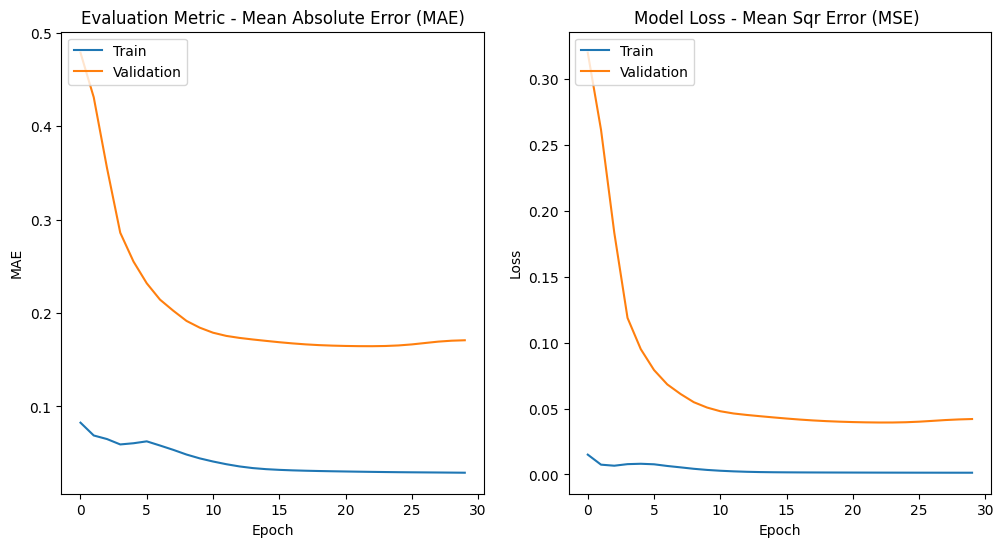

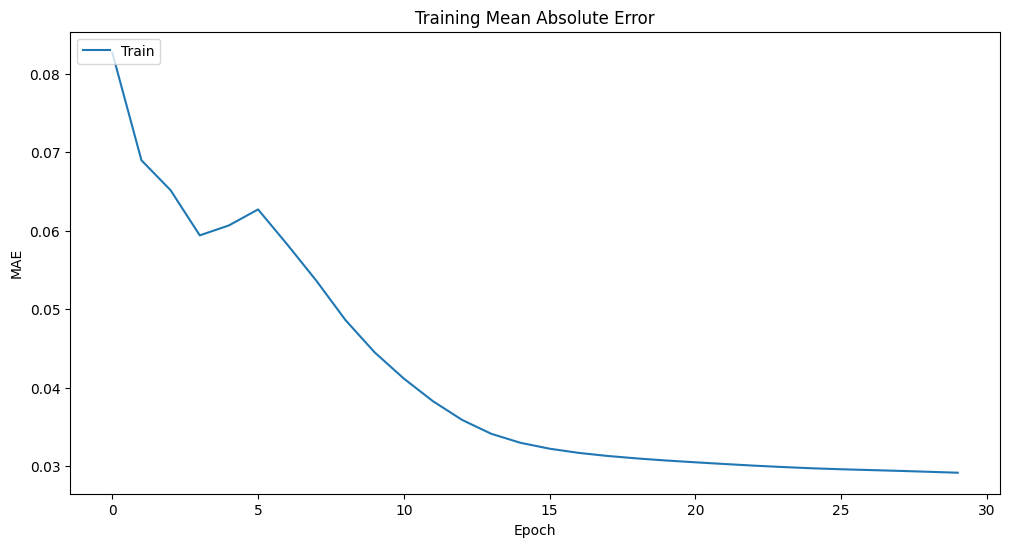

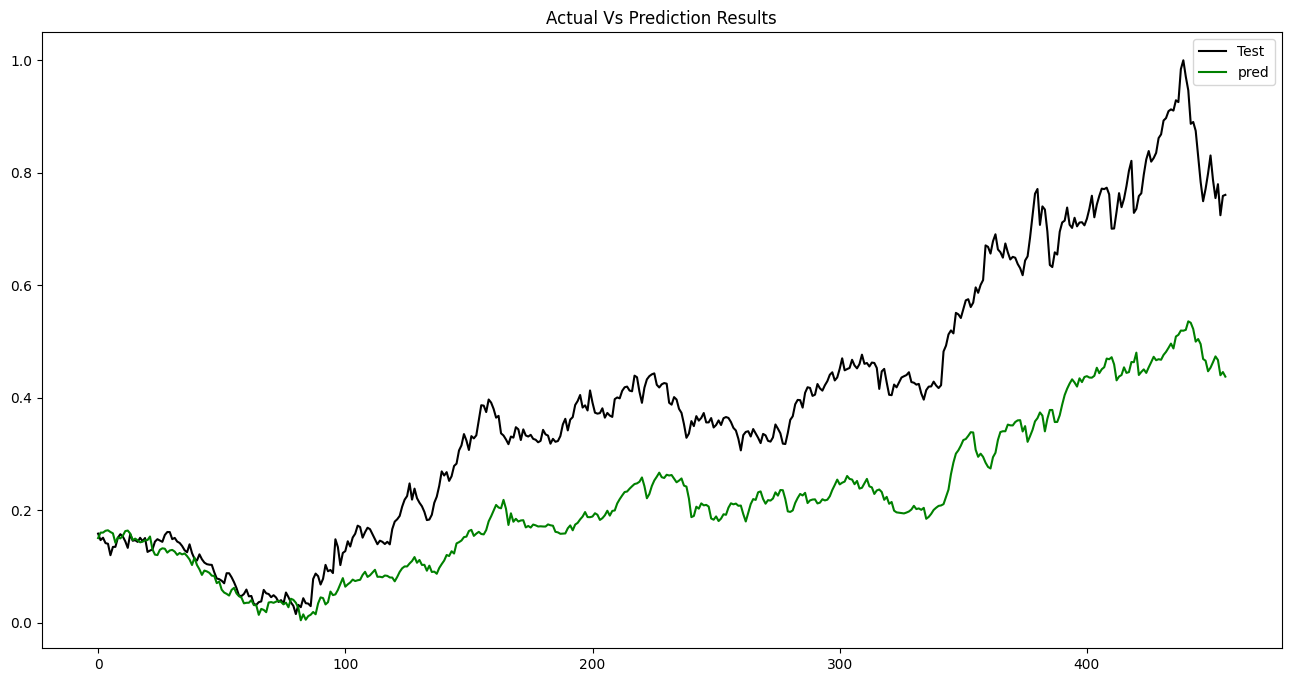

############################################################################
  Model Setup:
                    Name: XOM_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.1685830896209359
             mean_sqr_err =0.04371357387868552
        root_mean_sqr_err =0.20907791341671056
           pred_diff_mean =0.6353835328432569
      pred_diff_bias_mean =0.36461646715674306
    pred_correctness_mean =0.48577680525164113
                      AIC =-1348.4541507876274



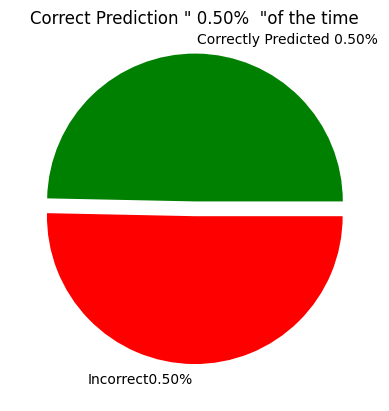

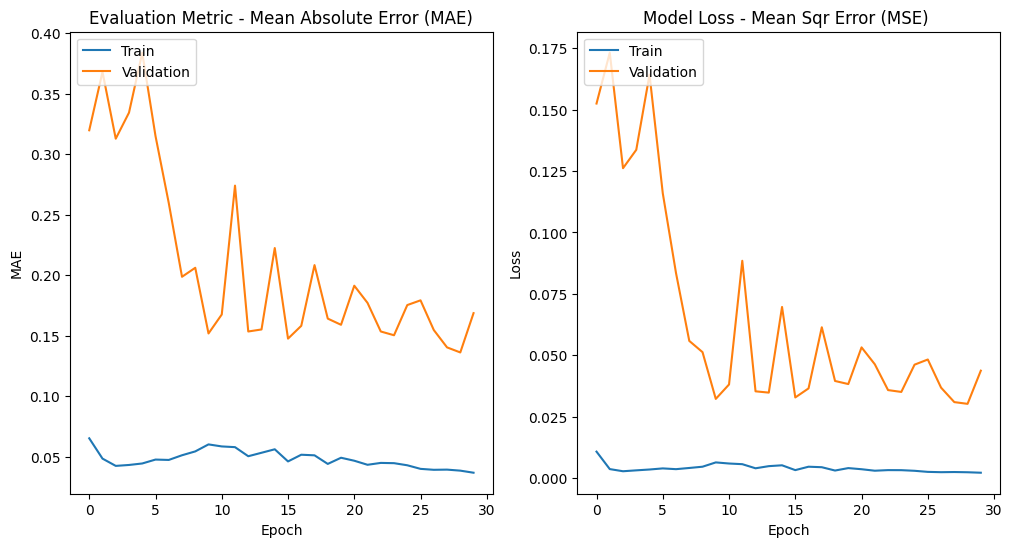

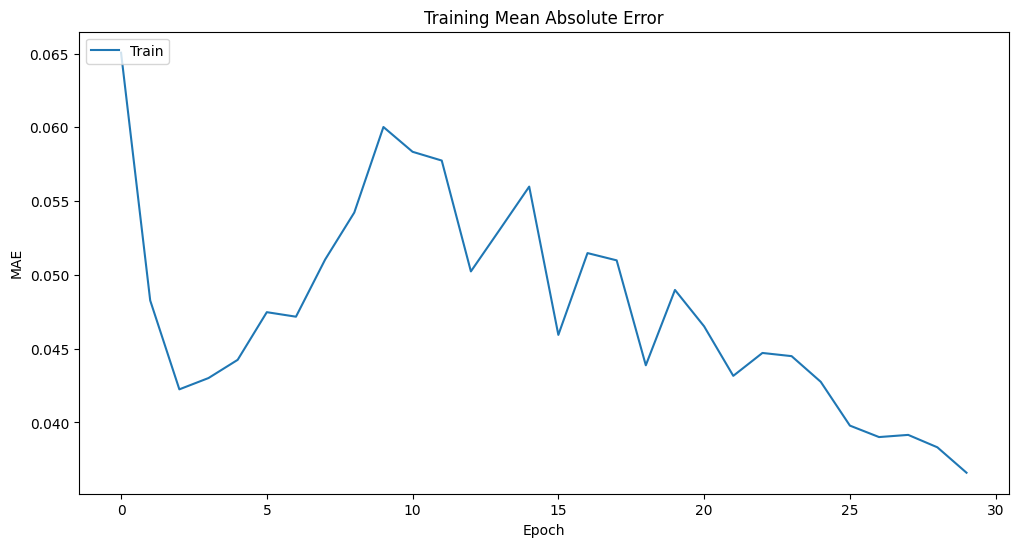

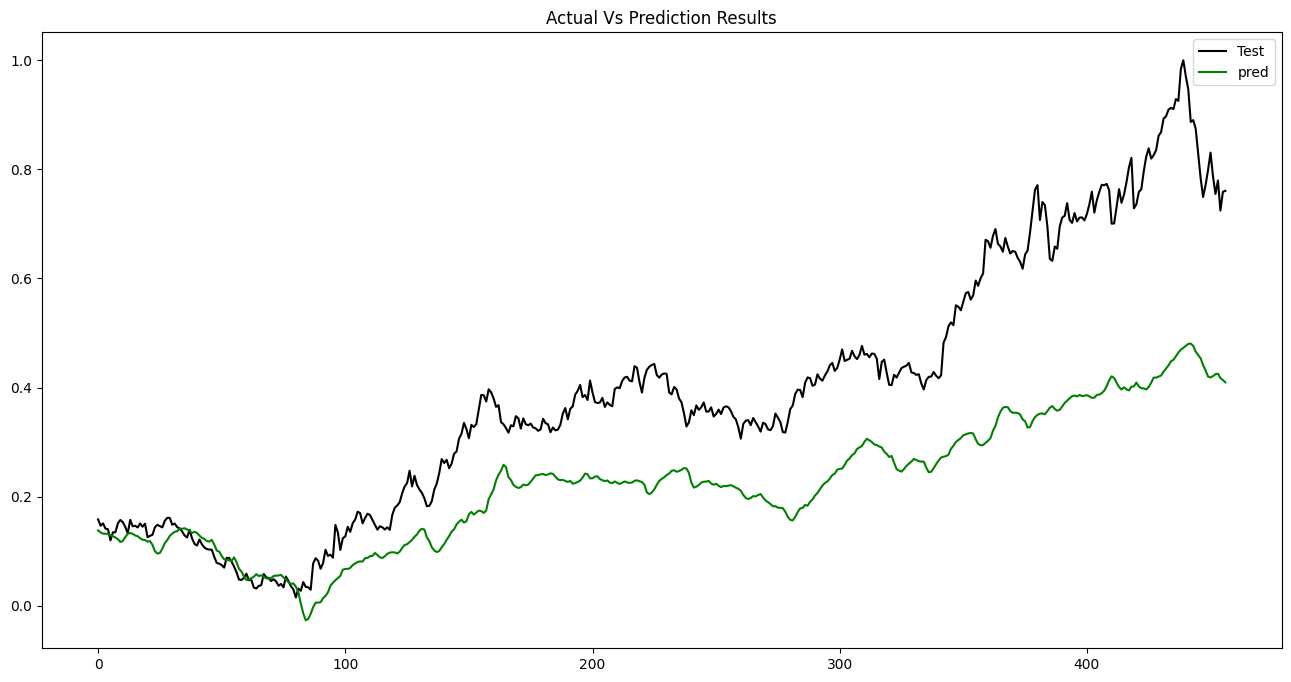

############################################################################
  Model Setup:
                    Name: XOM_F10_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.23301676294444865
             mean_sqr_err =0.07493781753980573
        root_mean_sqr_err =0.2737477260906577
           pred_diff_mean =0.5141926007559552
      pred_diff_bias_mean =0.48580739924404487
    pred_correctness_mean =0.49671772428884026
                      AIC =-1102.1311502253213



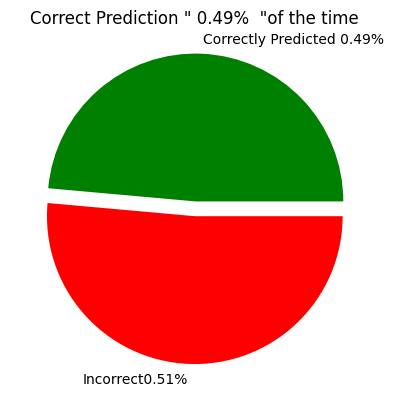

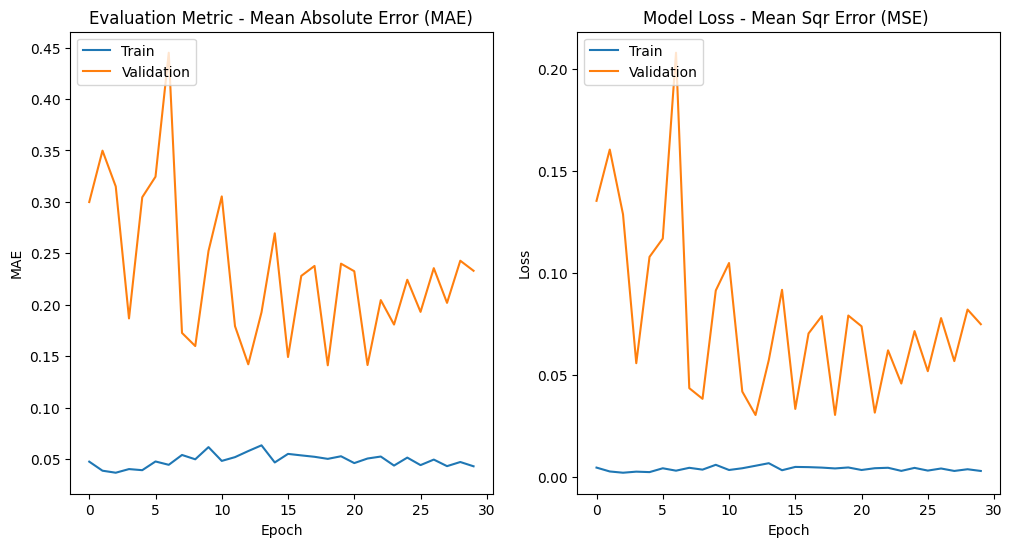

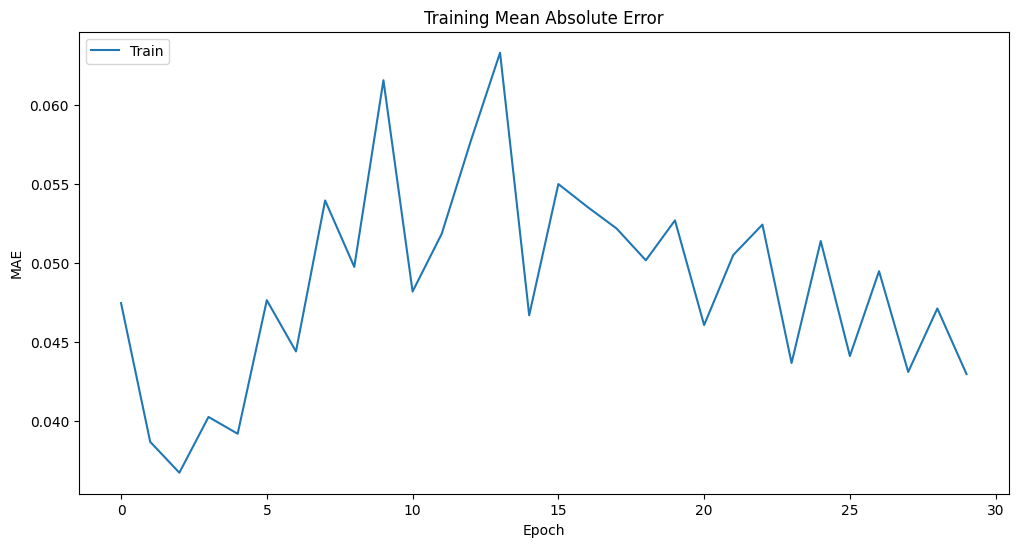

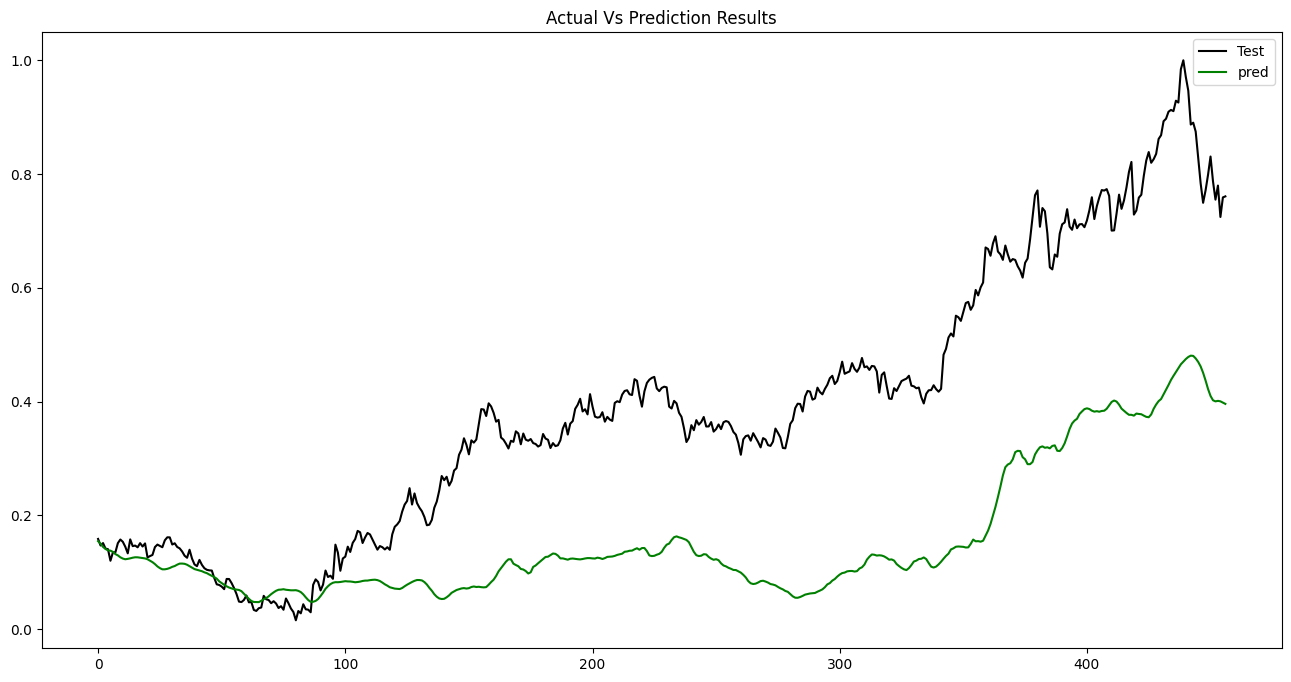

############################################################################
  Model Setup:
                    Name: XOM_F10_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.170230459198859
             mean_sqr_err =0.0483156267838416
        root_mean_sqr_err =0.2198081590474785
           pred_diff_mean =1.0311732551721582
      pred_diff_bias_mean =-0.031173255172158288
    pred_correctness_mean =0.4310722100656455
                      AIC =-1302.7101072819933



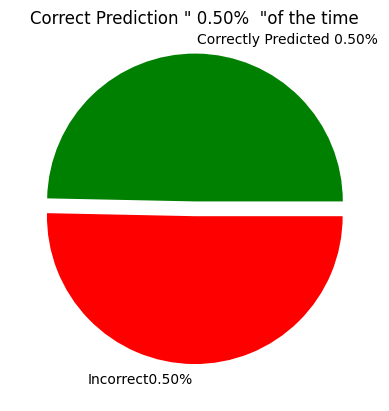

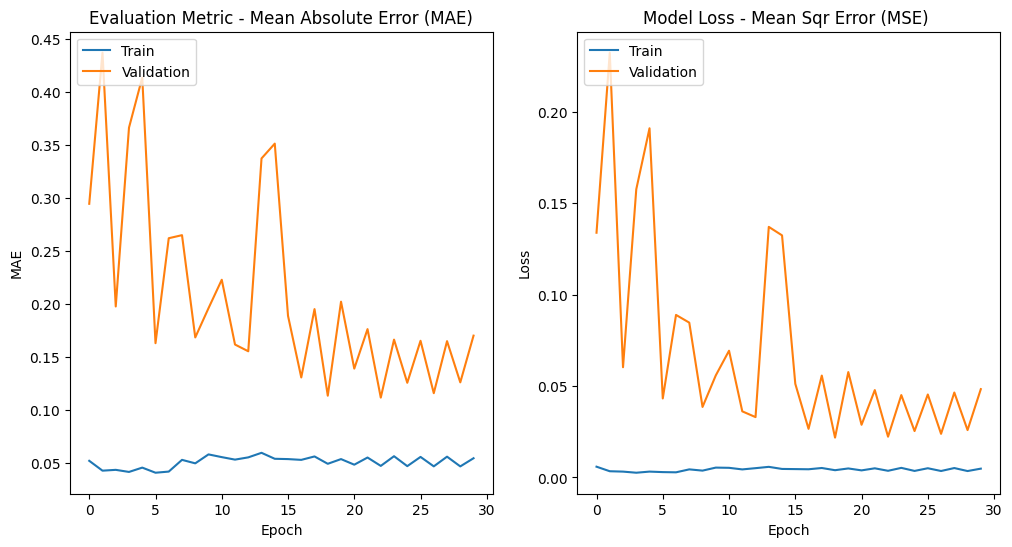

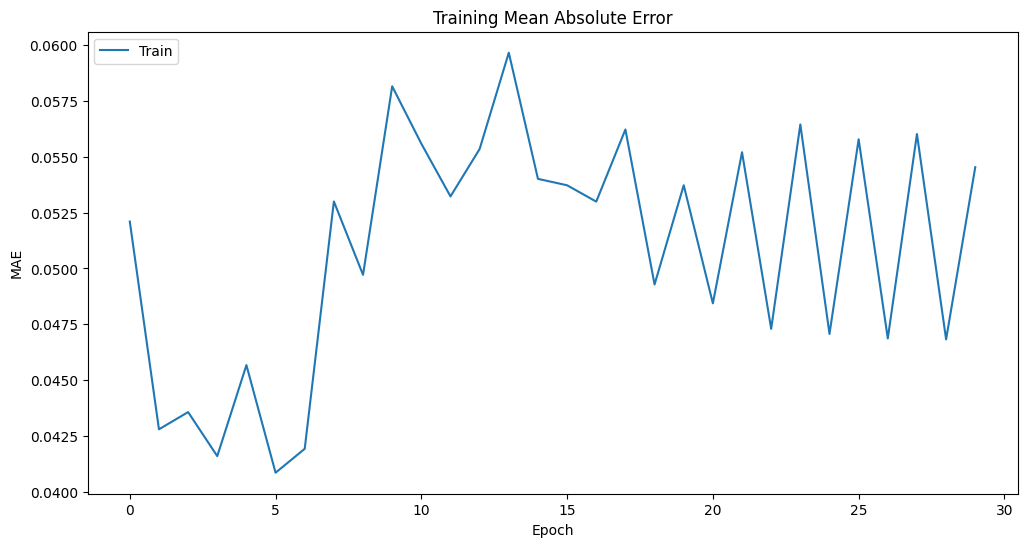

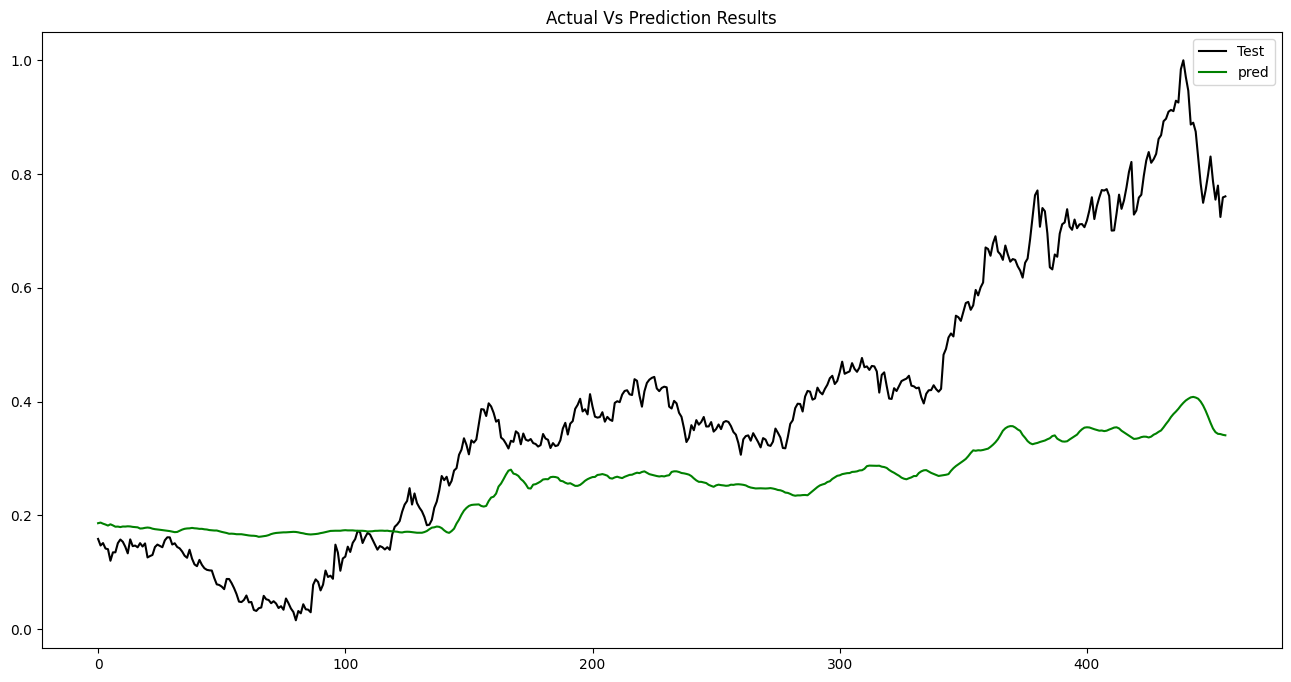

############################################################################
  Model Setup:
                    Name: XOM_F10_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.21357347070843463
             mean_sqr_err =0.06880399572509269
        root_mean_sqr_err =0.2623051576410435
           pred_diff_mean =0.7929212331030427
      pred_diff_bias_mean =0.2070787668969572
    pred_correctness_mean =0.47921225382932164
                      AIC =-1141.157510456656



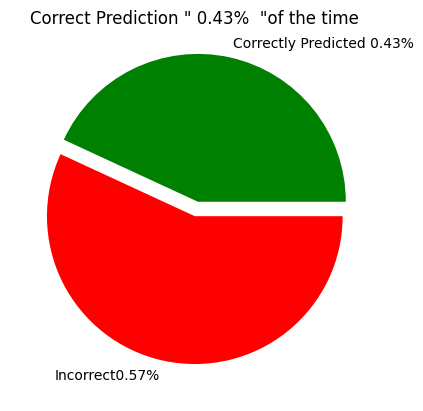

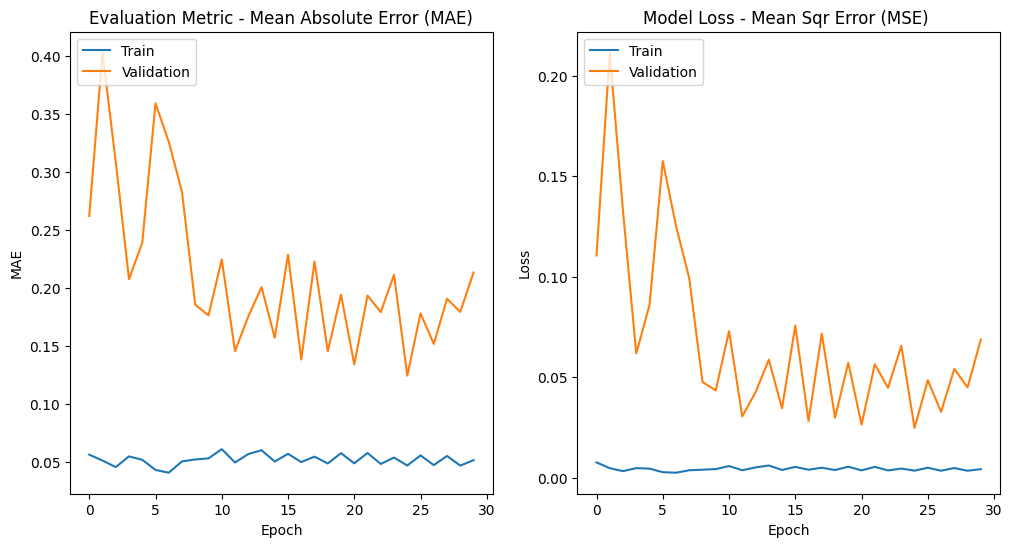

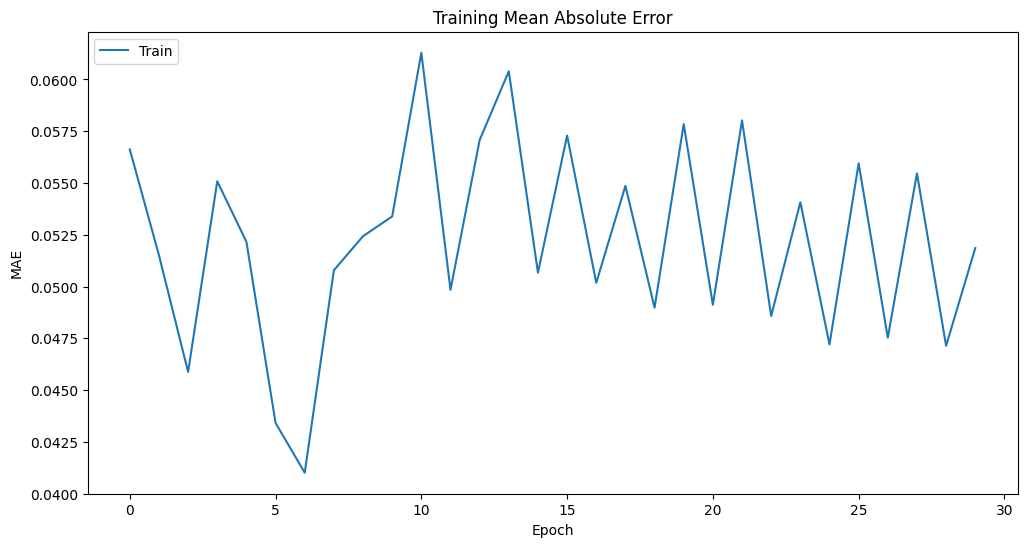

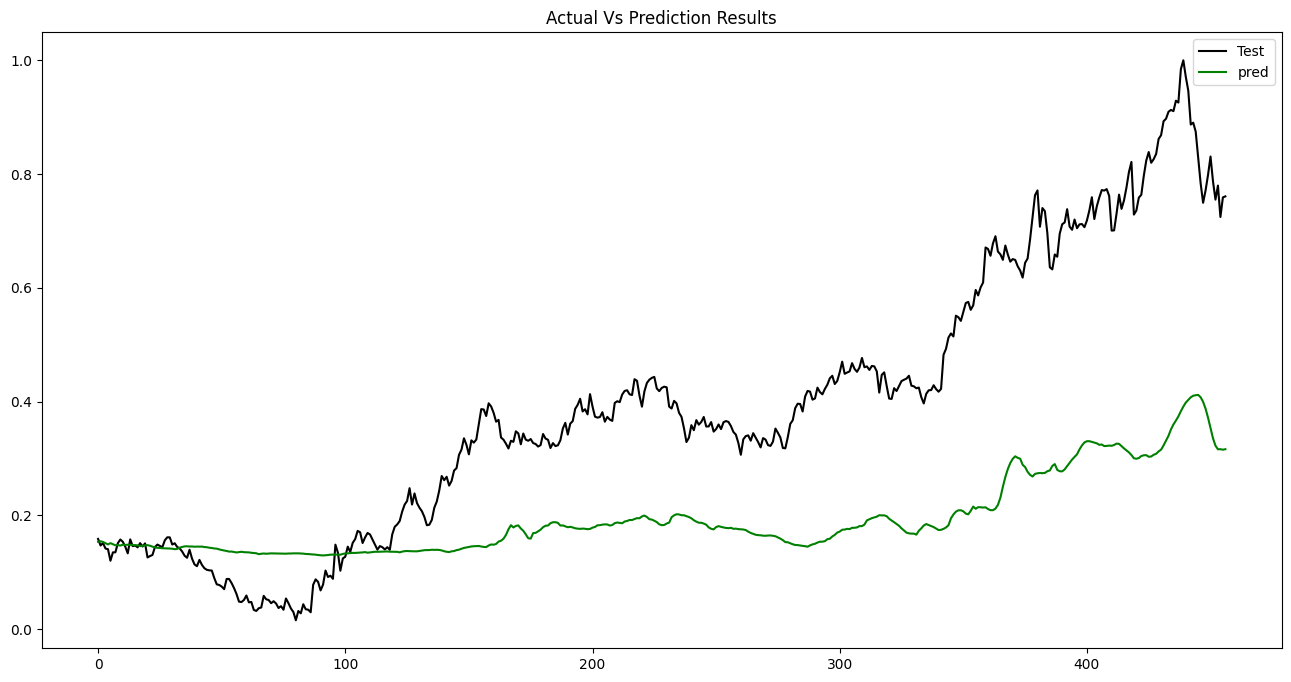

############################################################################
  Model Setup:
                    Name: XOM_F25_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.1716795311097467
             mean_sqr_err =0.0427205030654293
        root_mean_sqr_err =0.20668938788778998
           pred_diff_mean =0.7320320324234784
      pred_diff_bias_mean =0.26796796757652175
    pred_correctness_mean =0.47577092511013214
                      AIC =-1349.496644069614



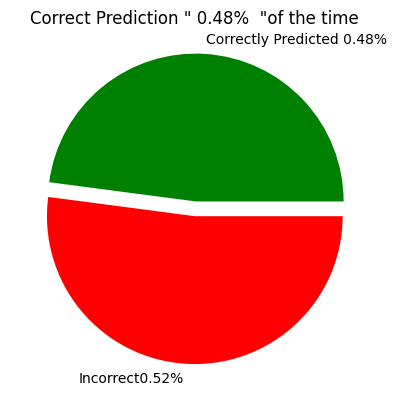

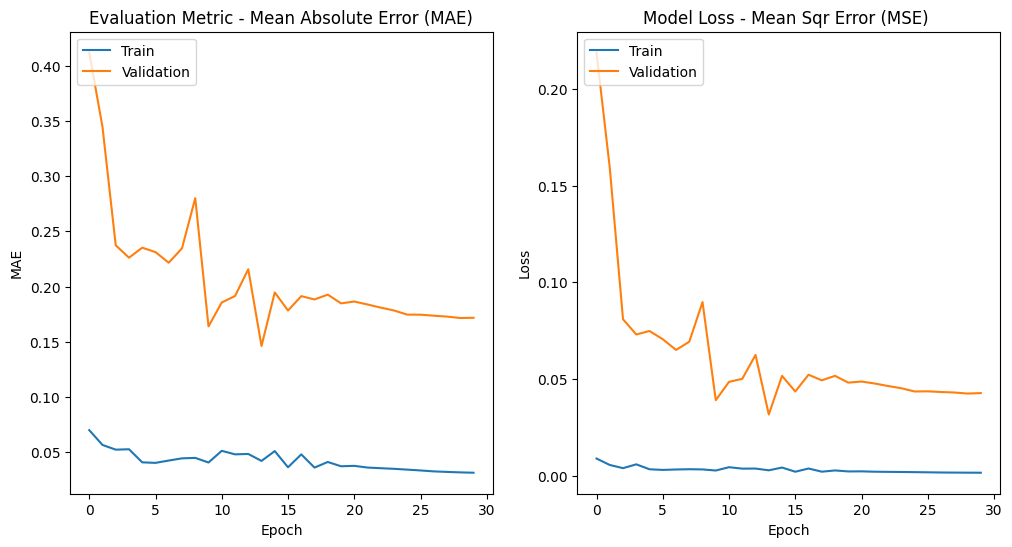

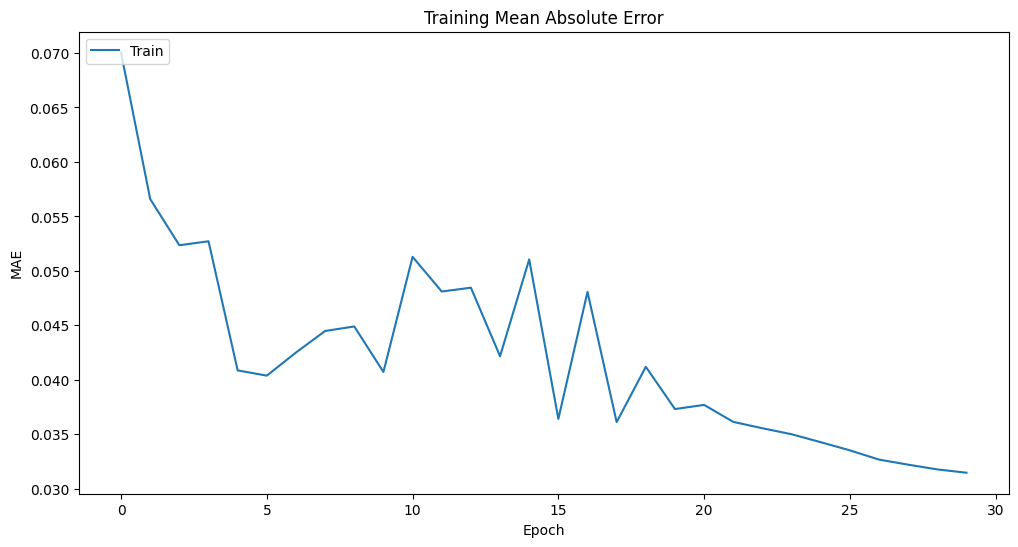

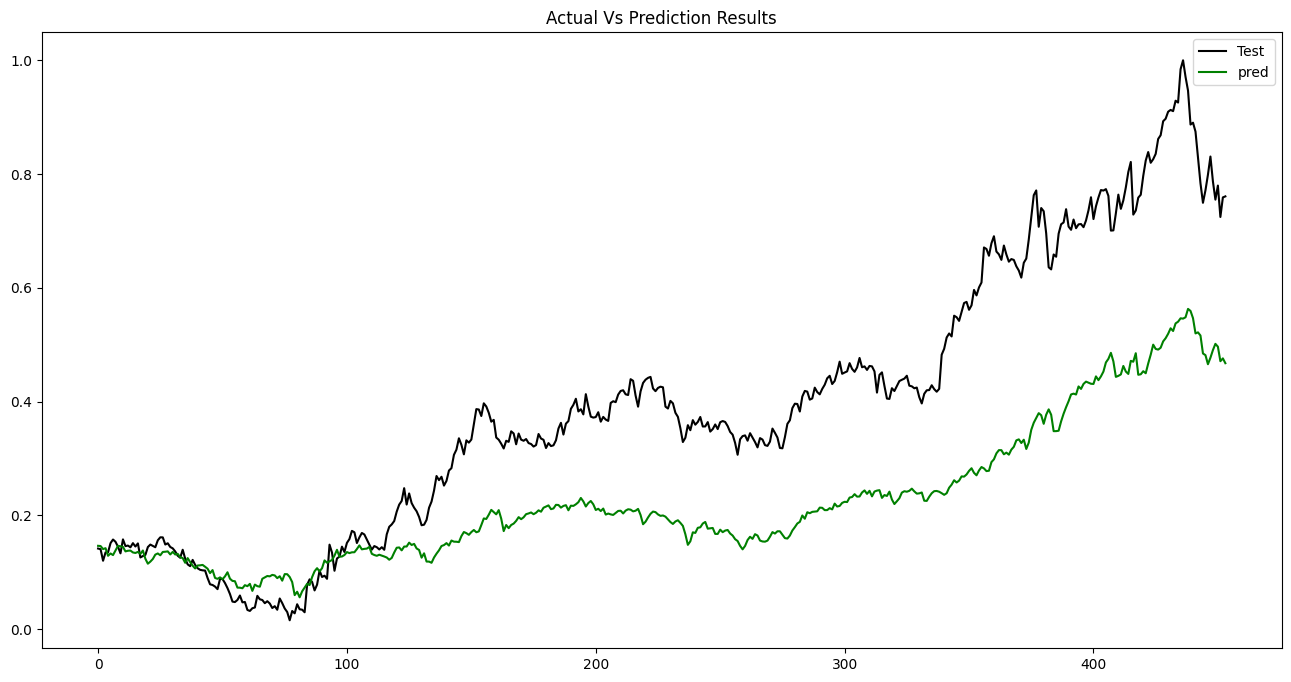

############################################################################
  Model Setup:
                    Name: XOM_F25_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.1766958032443584
             mean_sqr_err =0.049969045585616545
        root_mean_sqr_err =0.22353757085916573
           pred_diff_mean =0.8416335760983471
      pred_diff_bias_mean =0.15836642390165284
    pred_correctness_mean =0.4647577092511013
                      AIC =-1278.3436053143982



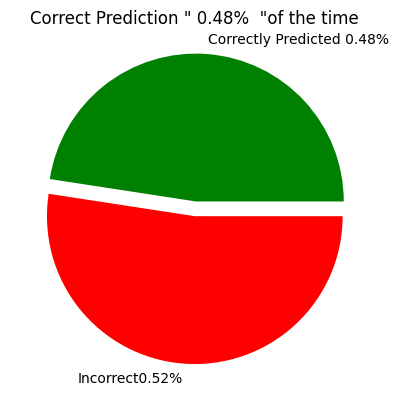

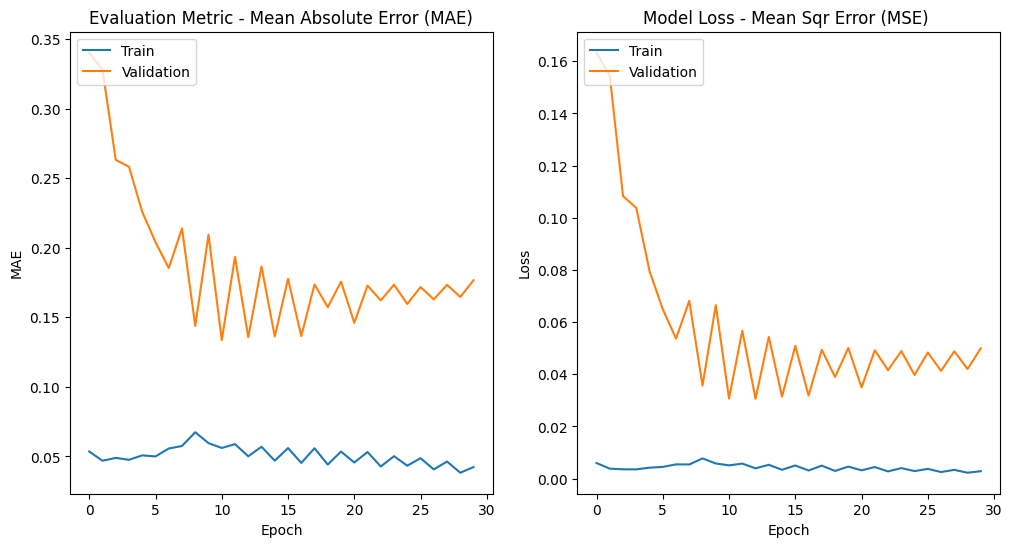

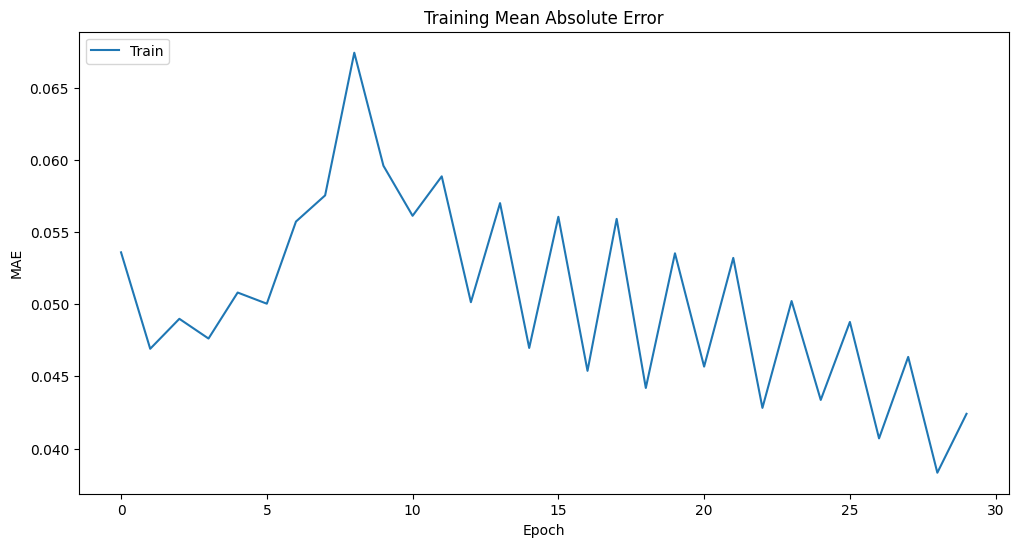

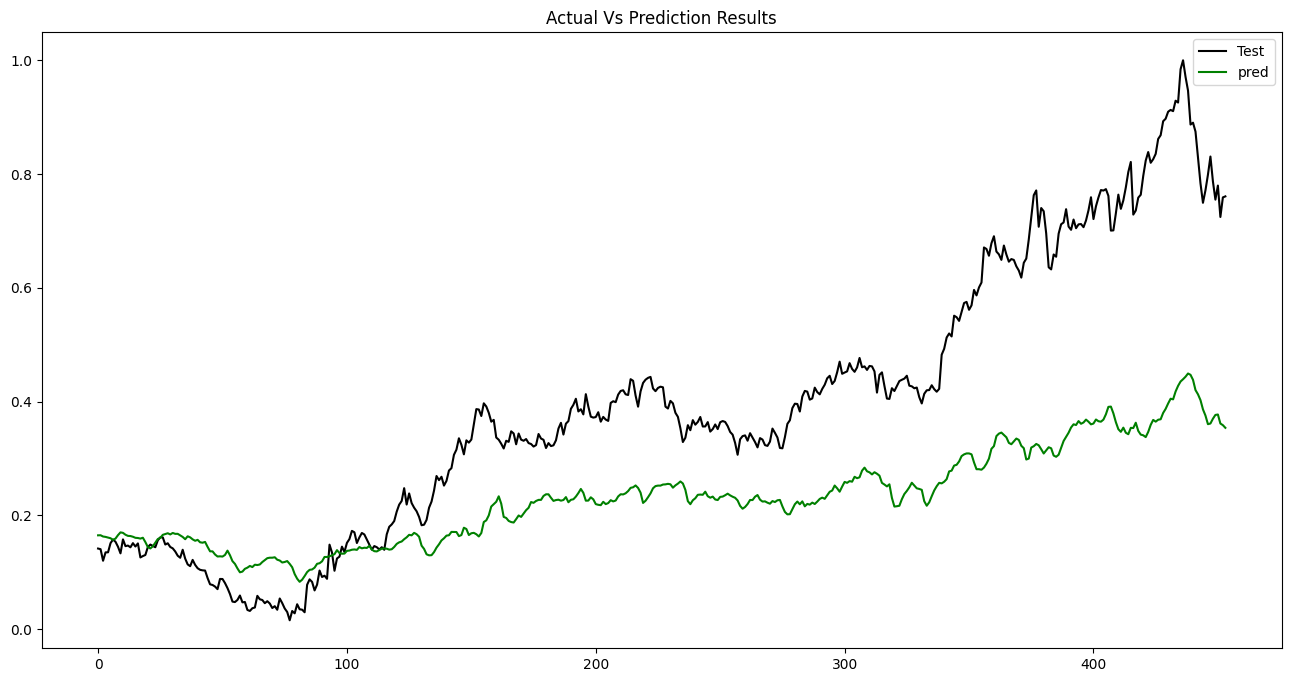

############################################################################
  Model Setup:
                    Name: XOM_F25_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.2310405013176758
             mean_sqr_err =0.07577552853231362
        root_mean_sqr_err =0.27527355218457444
           pred_diff_mean =0.6264262671020507
      pred_diff_bias_mean =0.37357373289794926
    pred_correctness_mean =0.44713656387665196
                      AIC =-1089.3108659923012



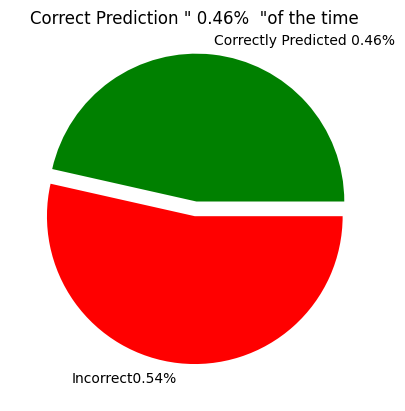

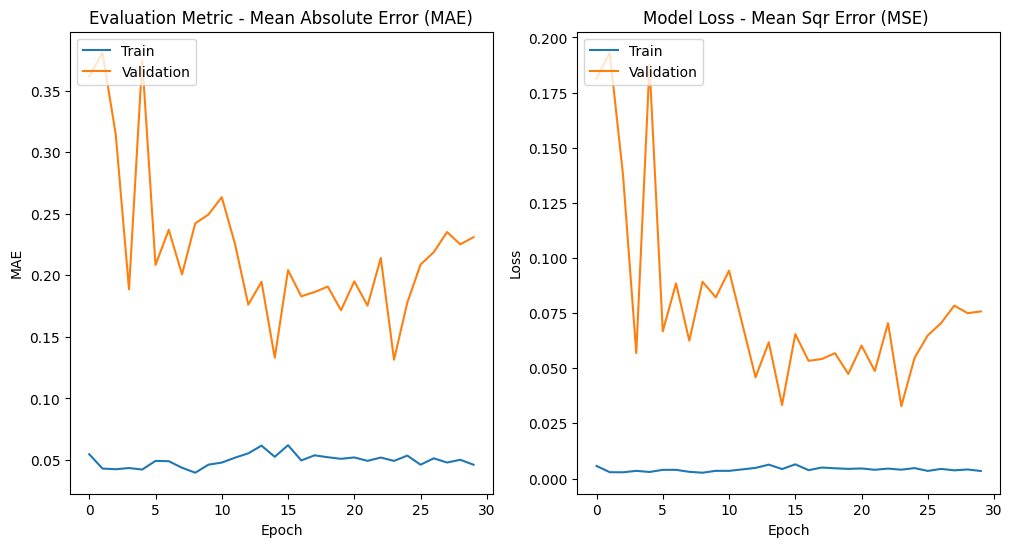

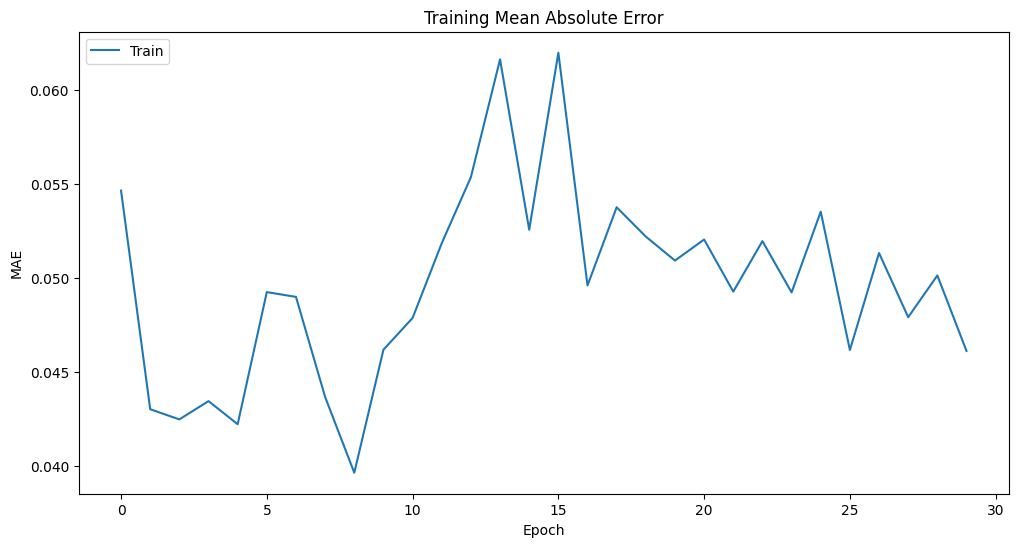

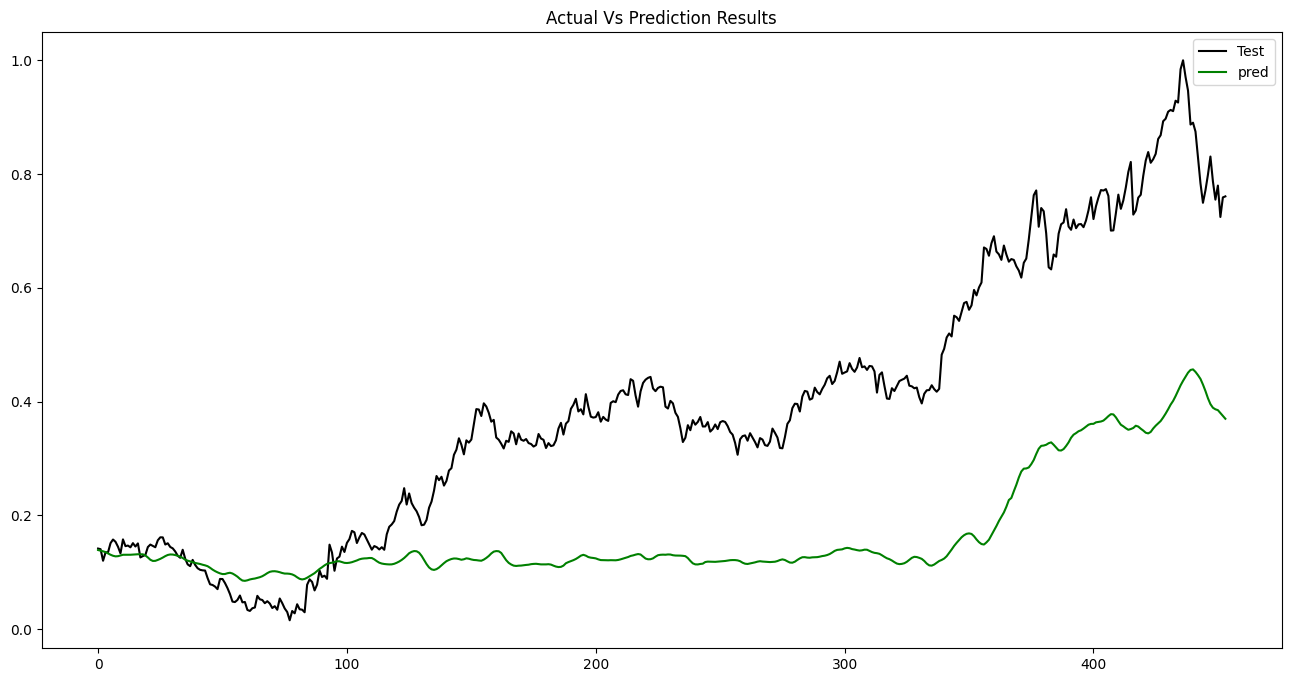

############################################################################
  Model Setup:
                    Name: XOM_F25_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.21433225475842044
             mean_sqr_err =0.06455694031226548
        root_mean_sqr_err =0.25408057838462483
           pred_diff_mean =0.650134925205316
      pred_diff_bias_mean =0.34986507479468404
    pred_correctness_mean =0.44493392070484583
                      AIC =-1162.0542726806016



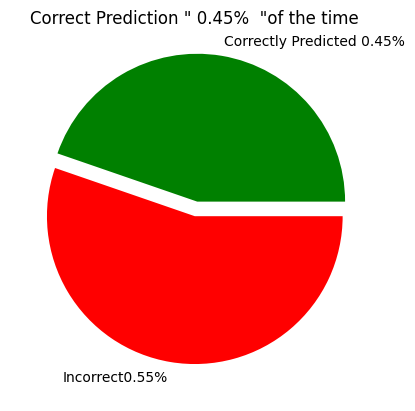

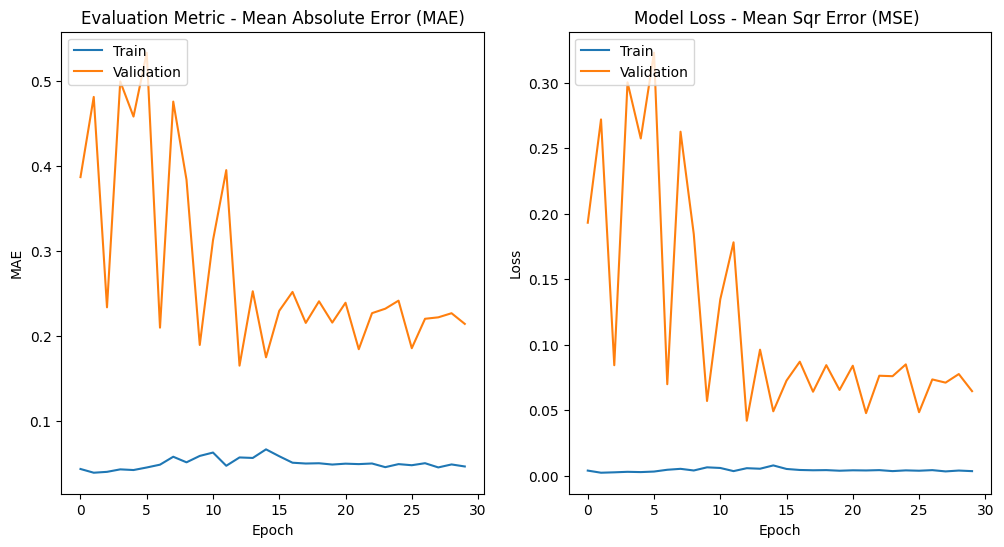

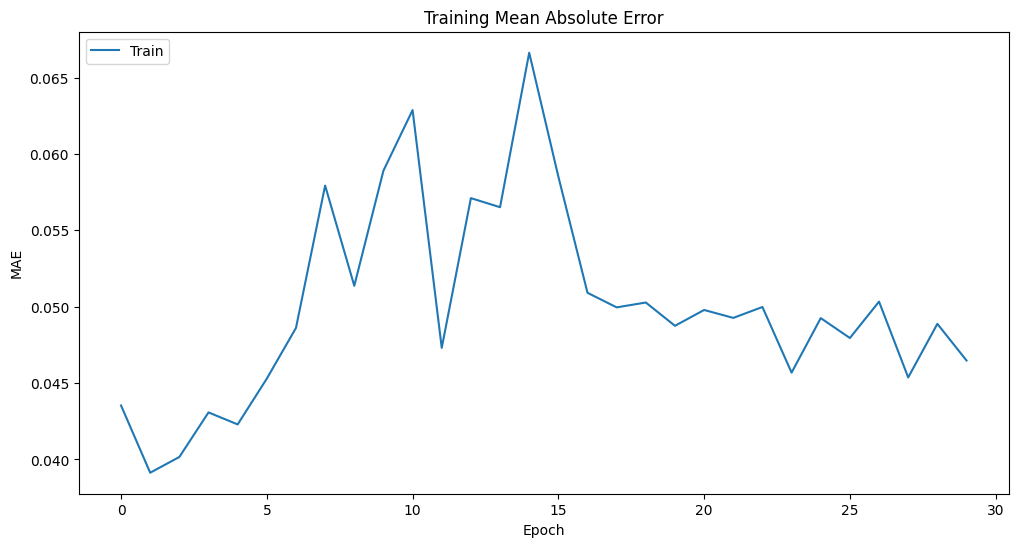

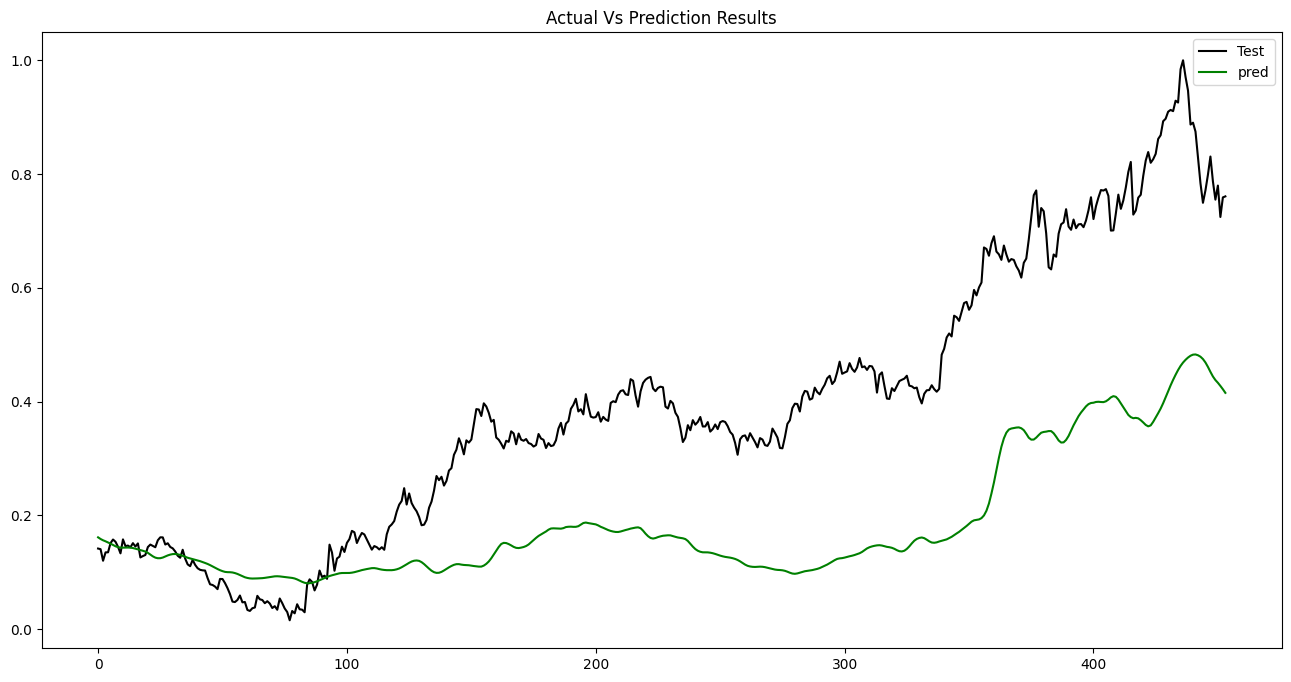

############################################################################
  Model Setup:
                    Name: XOM_F25_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.23428735129575703
             mean_sqr_err =0.08202921482510192
        root_mean_sqr_err =0.286407428020123
           pred_diff_mean =0.7925671890691457
      pred_diff_bias_mean =0.20743281093085425
    pred_correctness_mean =0.44493392070484583
                      AIC =-1053.3086368340303



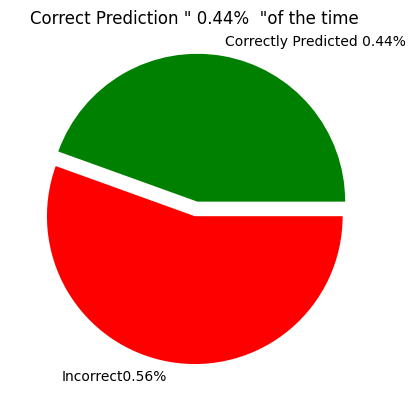

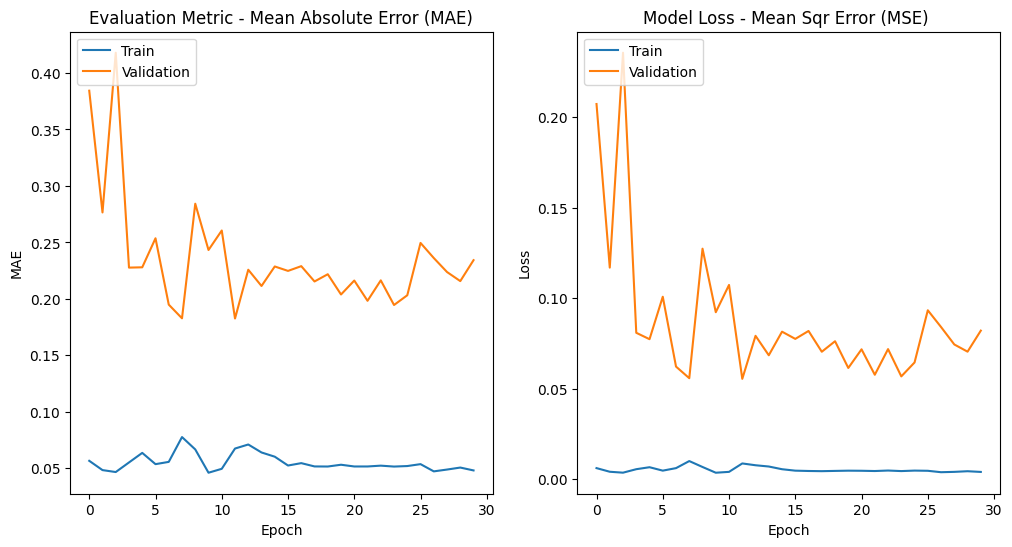

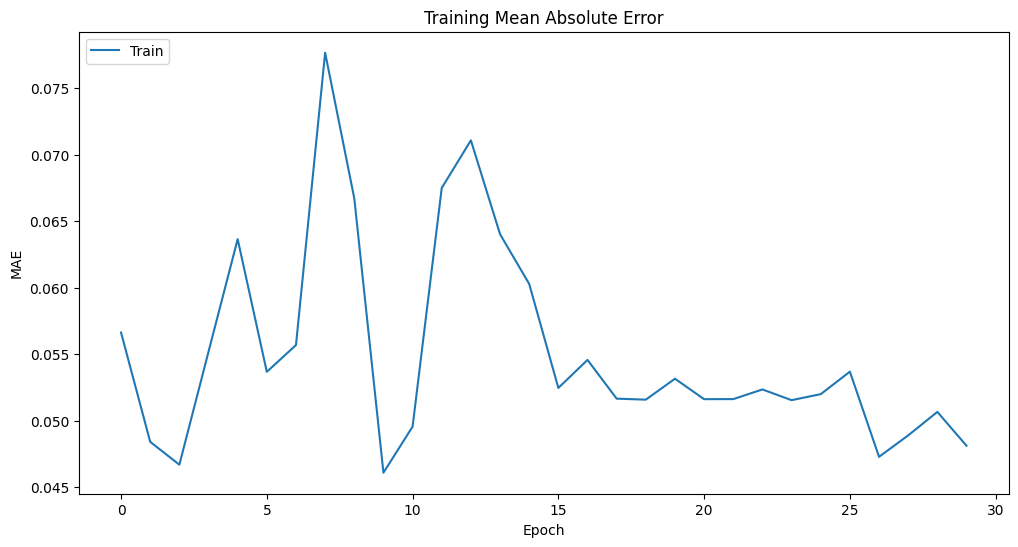

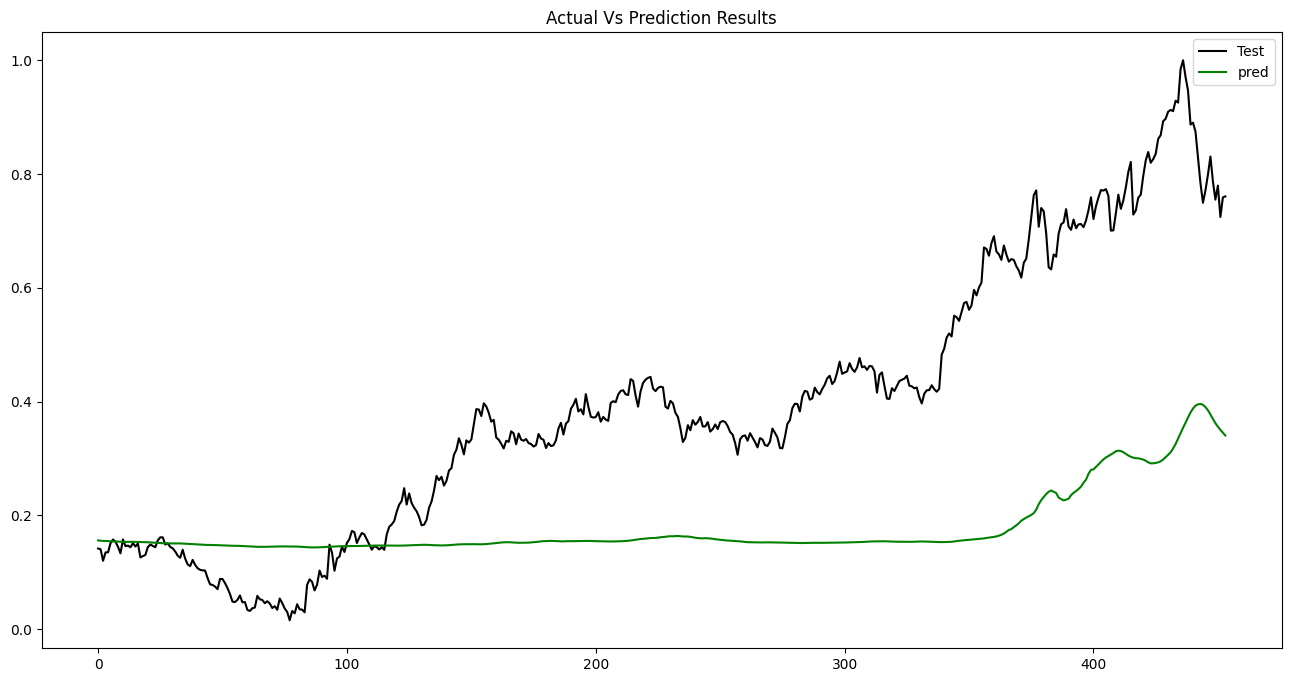

############################################################################
  Model Setup:
                    Name: XOM_F50_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.1352728830895548
             mean_sqr_err =0.02599564761838056
        root_mean_sqr_err =0.16123165823863675
           pred_diff_mean =0.5949808437649222
      pred_diff_bias_mean =0.40501915623507784
    pred_correctness_mean =0.6302895322939867
                      AIC =-1556.7719432656747



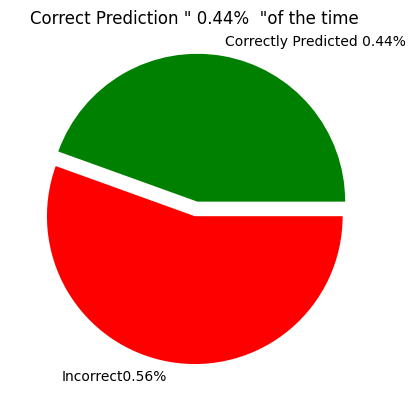

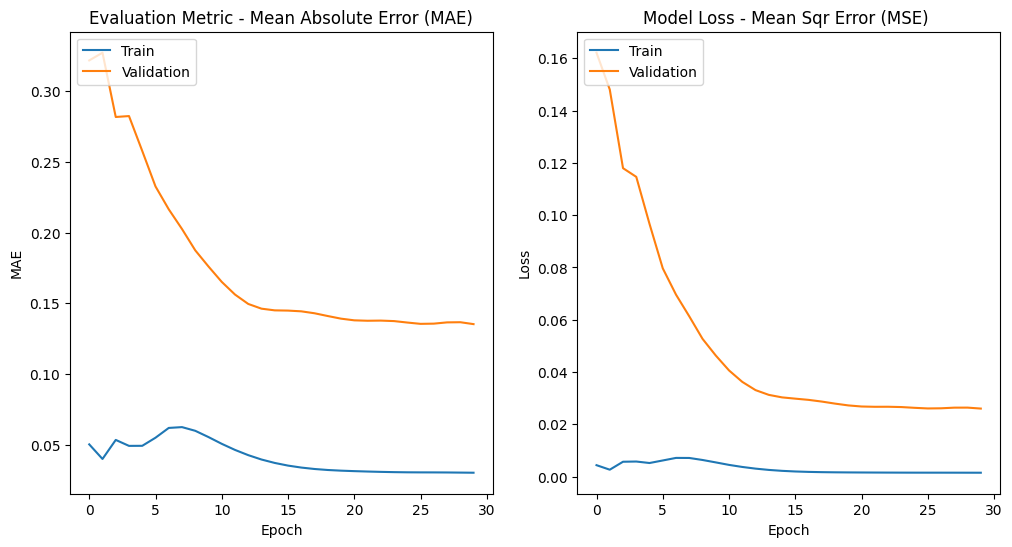

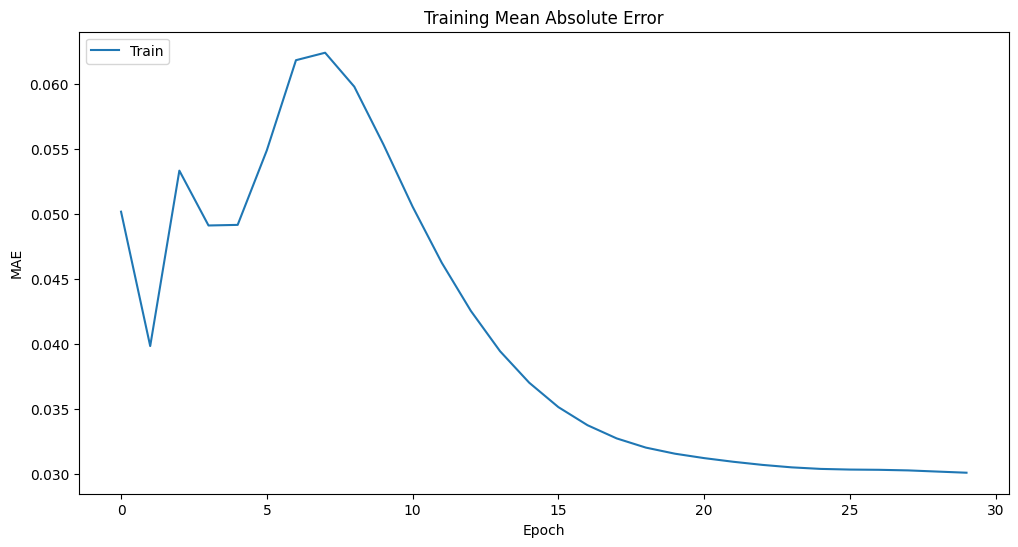

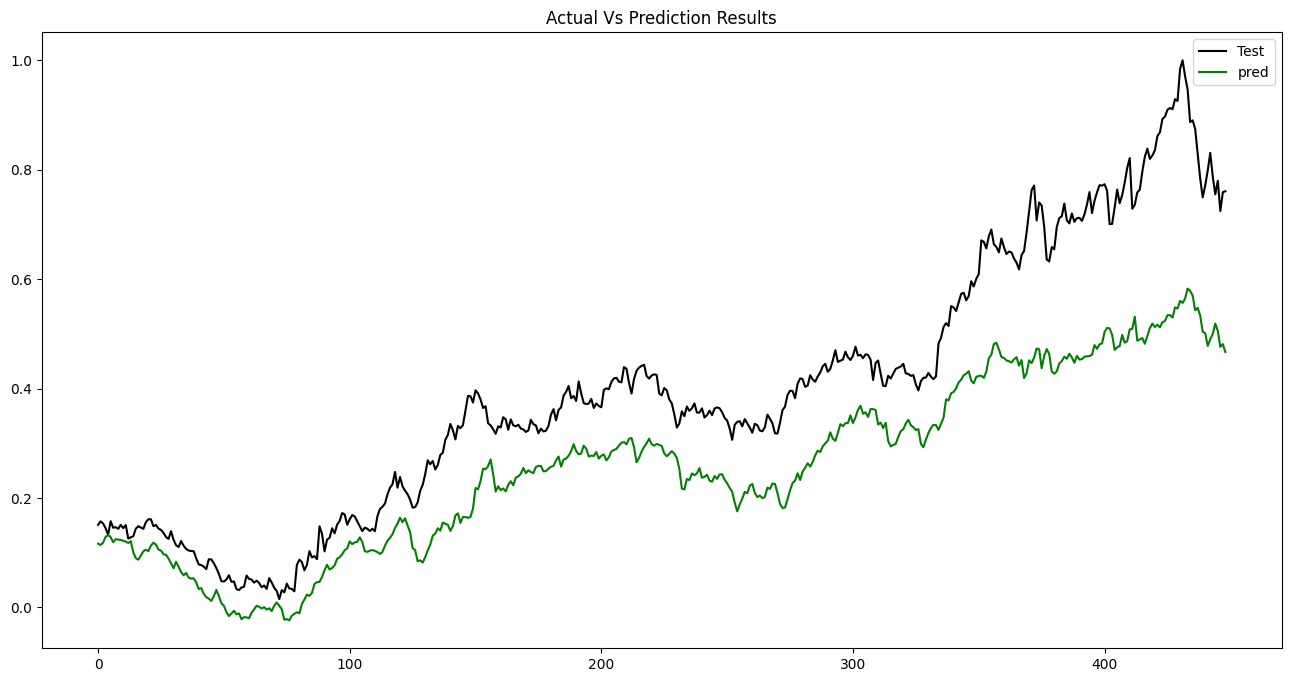

############################################################################
  Model Setup:
                    Name: XOM_F50_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.20327413544508655
             mean_sqr_err =0.055343823801450566
        root_mean_sqr_err =0.23525268075295244
           pred_diff_mean =0.48104327699035243
      pred_diff_bias_mean =0.5189567230096476
    pred_correctness_mean =0.39643652561247217
                      AIC =-1217.491404509921



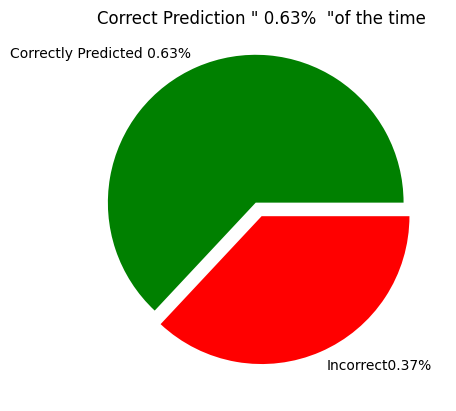

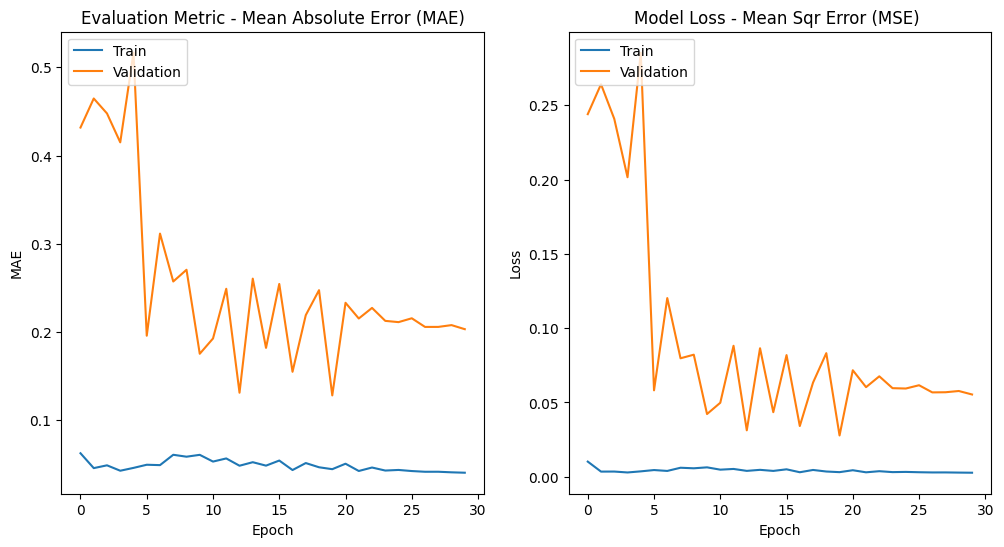

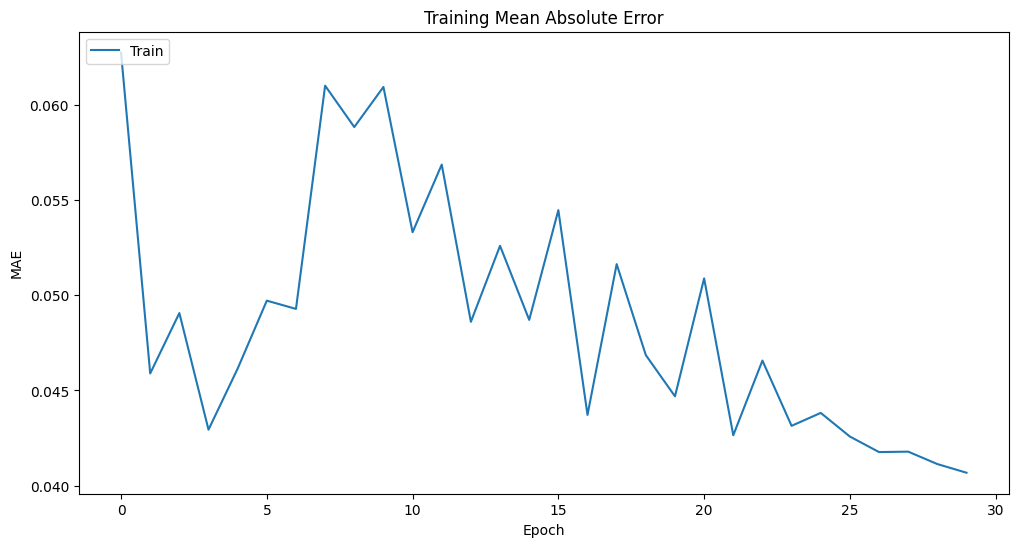

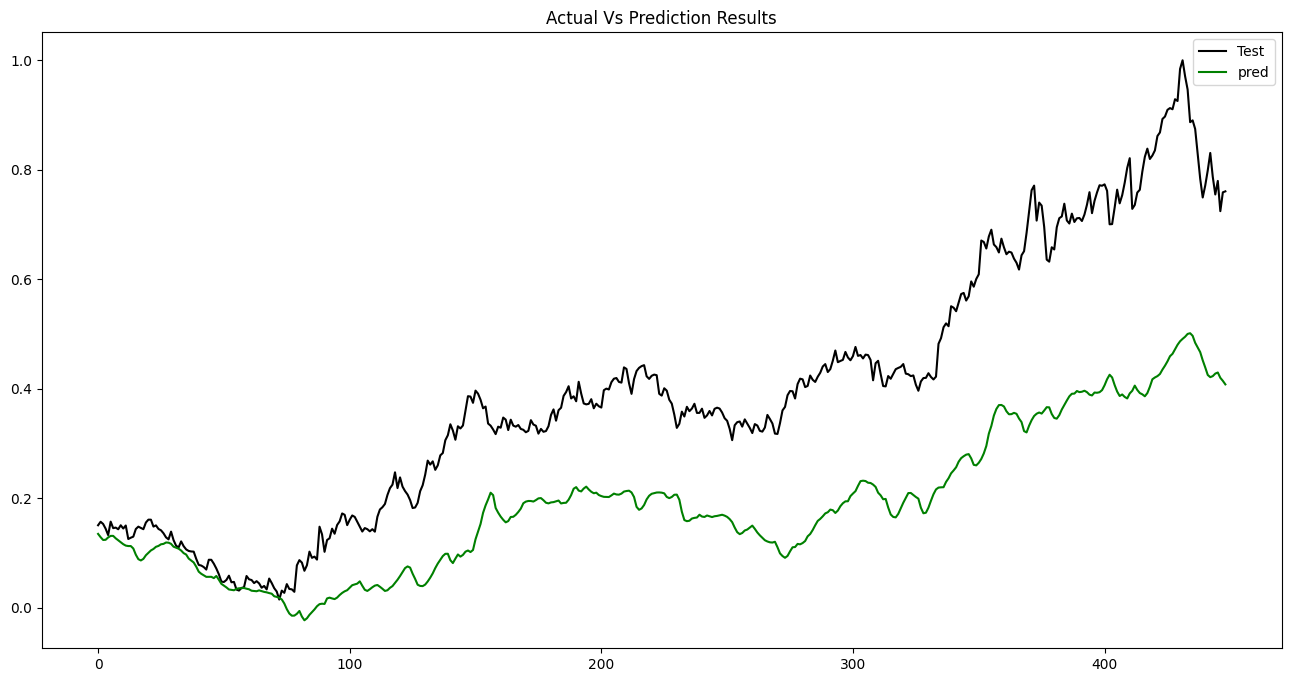

############################################################################
  Model Setup:
                    Name: XOM_F50_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.2233454634670695
             mean_sqr_err =0.07330976477168676
        root_mean_sqr_err =0.2707577603166468
           pred_diff_mean =0.6591944789627457
      pred_diff_bias_mean =0.34080552103725426
    pred_correctness_mean =0.4610244988864143
                      AIC =-1091.264596631766



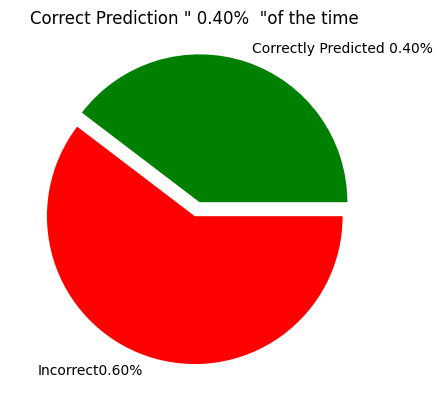

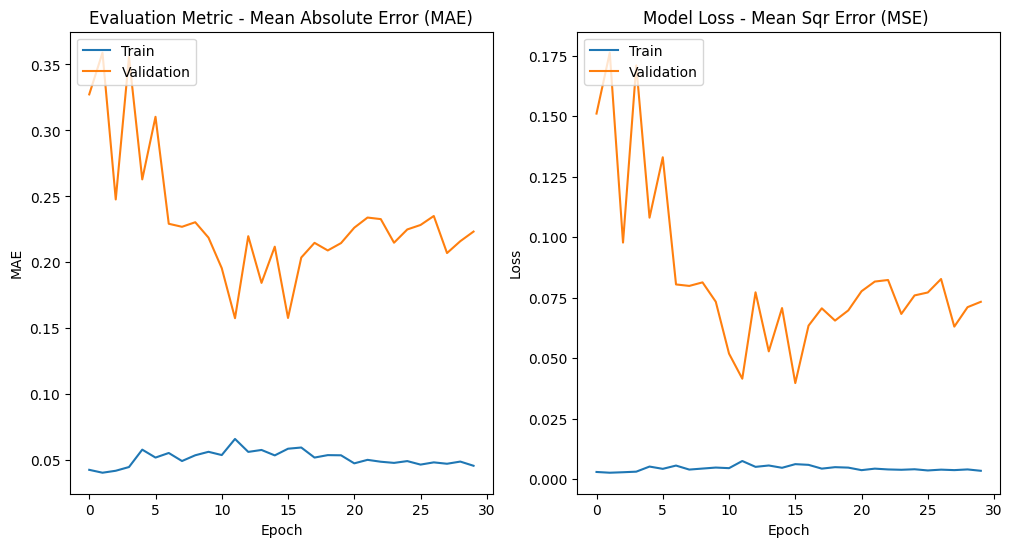

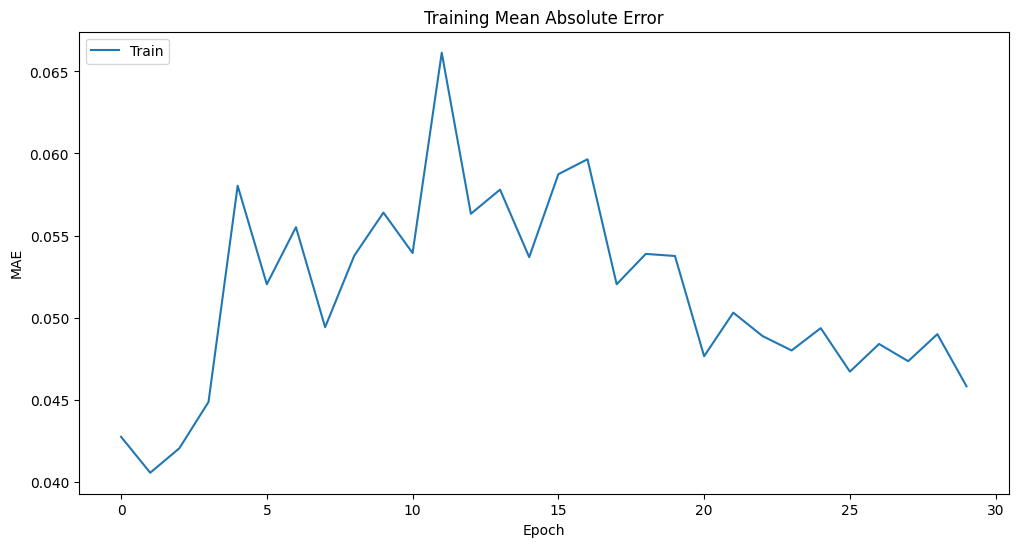

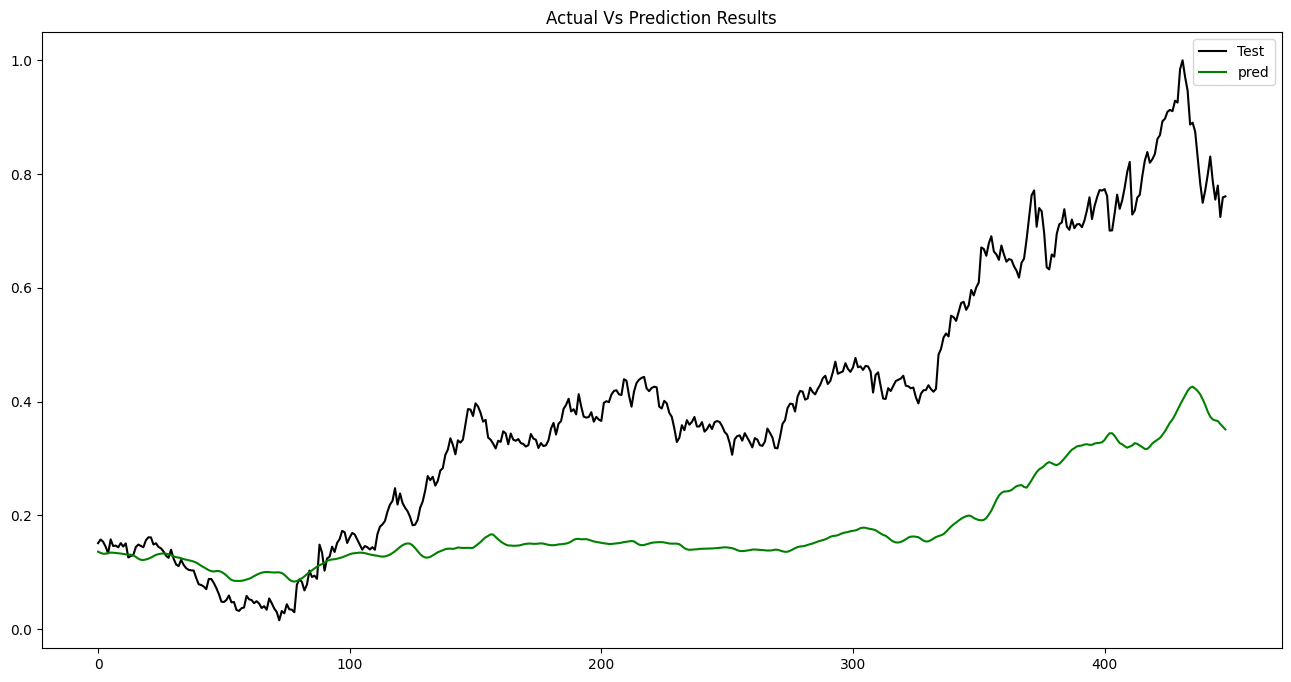

############################################################################
  Model Setup:
                    Name: XOM_F50_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.23375937429562982
             mean_sqr_err =0.07815590853722135
        root_mean_sqr_err =0.2795637825921329
           pred_diff_mean =0.7110823641749505
      pred_diff_bias_mean =0.28891763582504937
    pred_correctness_mean =0.43207126948775054
                      AIC =-1062.5232793305045



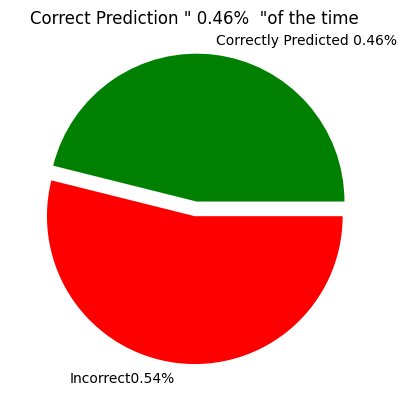

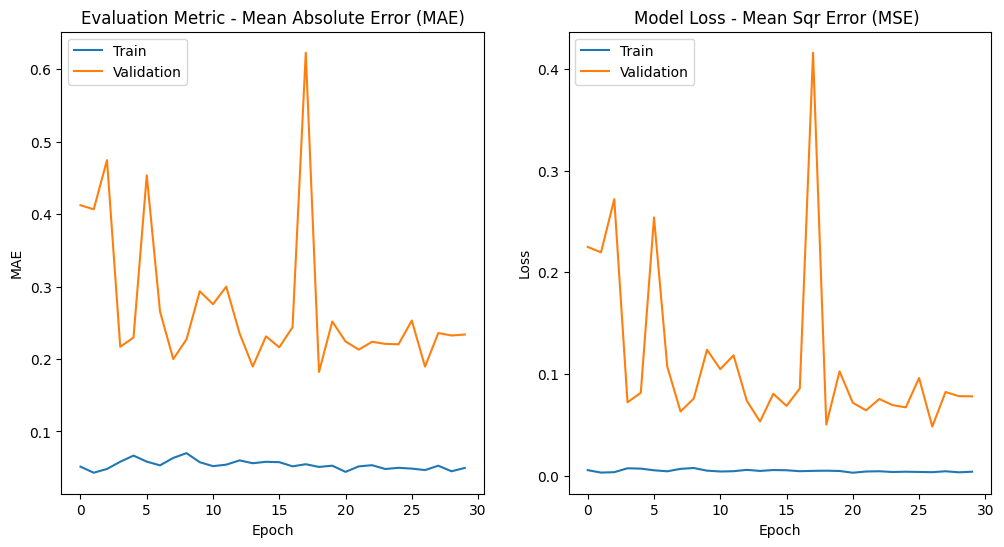

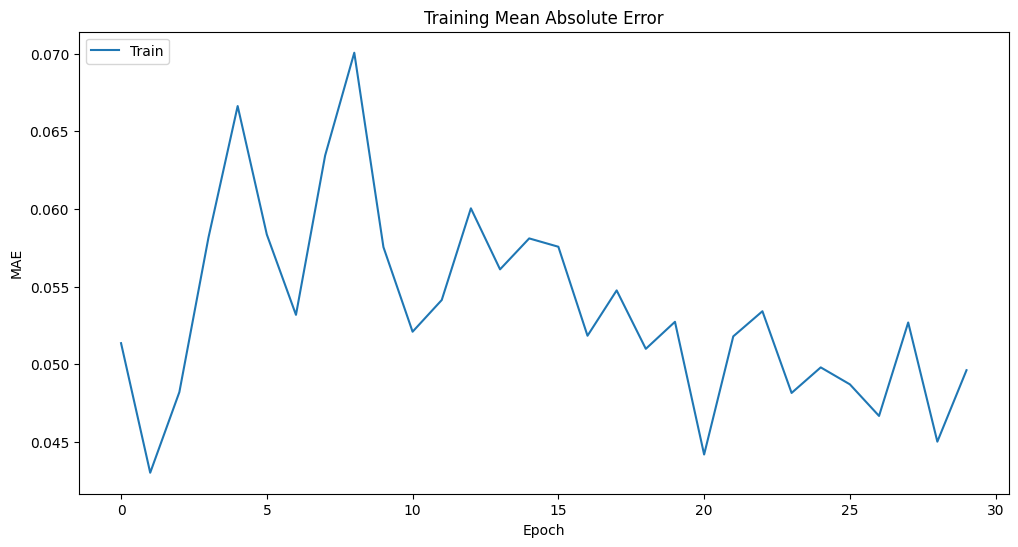

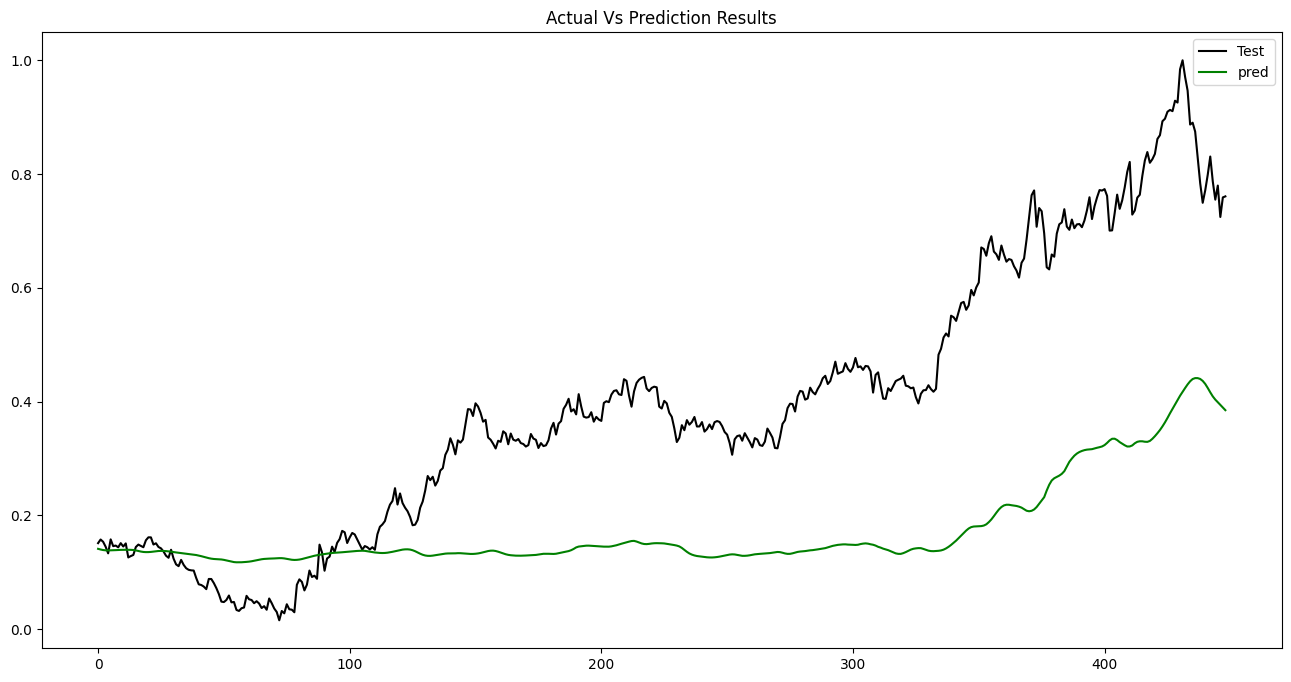

############################################################################
  Model Setup:
                    Name: XOM_F50_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.2516198597870447
             mean_sqr_err =0.09741973950472572
        root_mean_sqr_err =0.3121213538108627
           pred_diff_mean =0.7028186705920246
      pred_diff_bias_mean =0.2971813294079752
    pred_correctness_mean =0.44766146993318484
                      AIC =-963.5981646219266



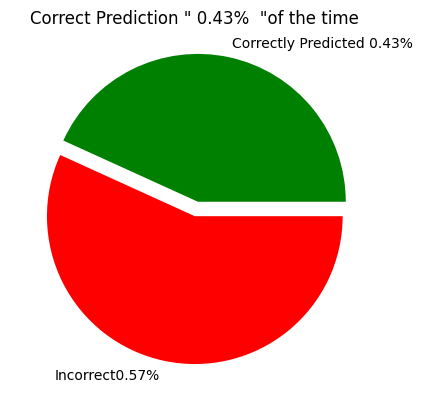

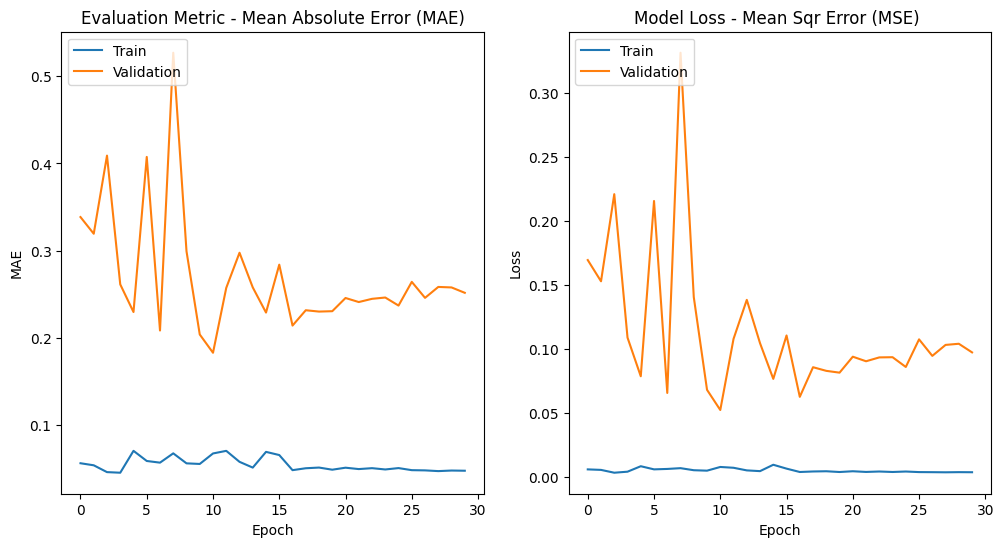

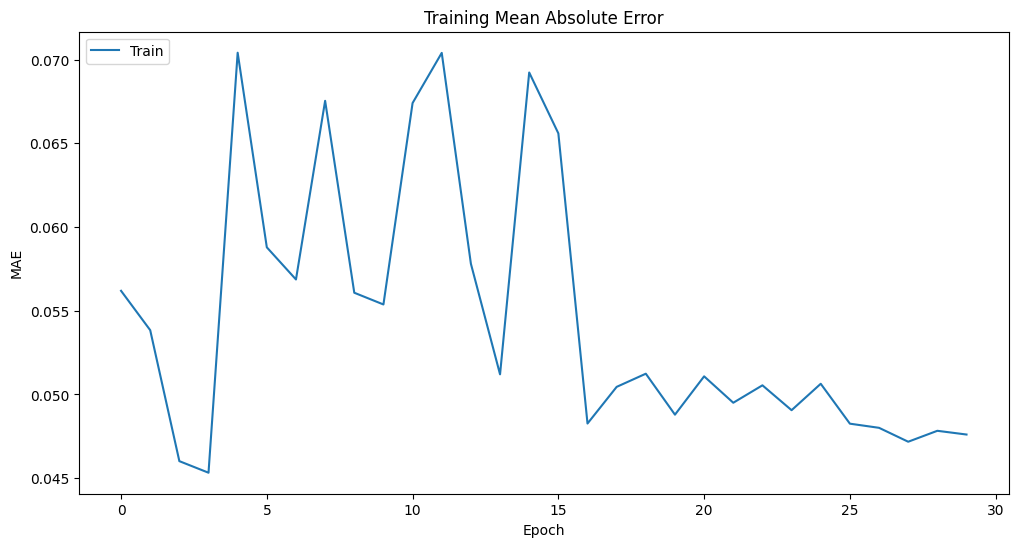

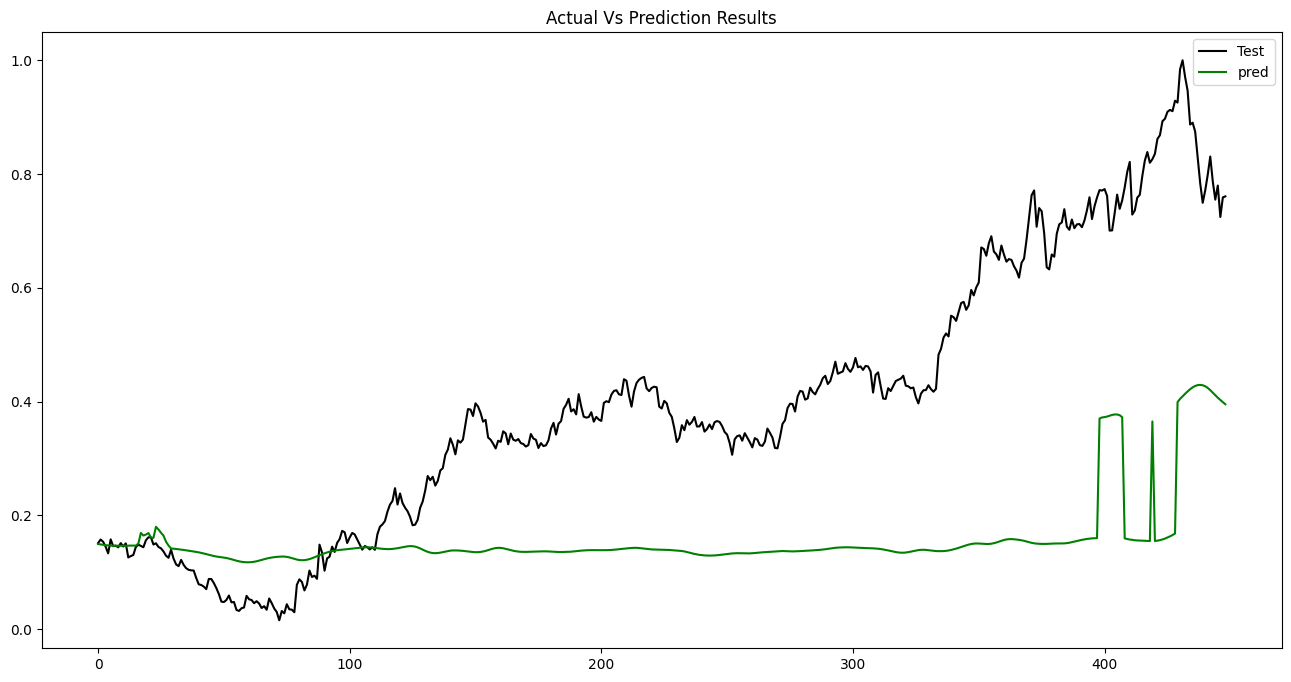

############################################################################
  Model Setup:
                    Name: XOM_F75_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.08747706819101352
             mean_sqr_err =0.014682665851866233
        root_mean_sqr_err =0.12117205062169342
           pred_diff_mean =0.7732316617723786
      pred_diff_bias_mean =0.2267683382276214
    pred_correctness_mean =0.831081081081081
                      AIC =-1792.1629275863506



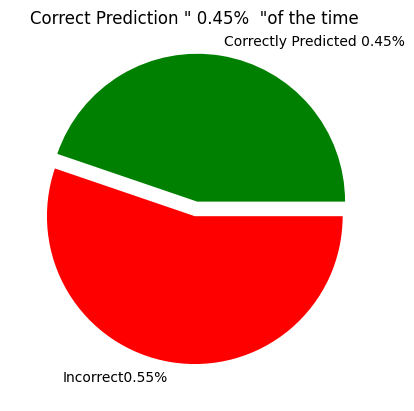

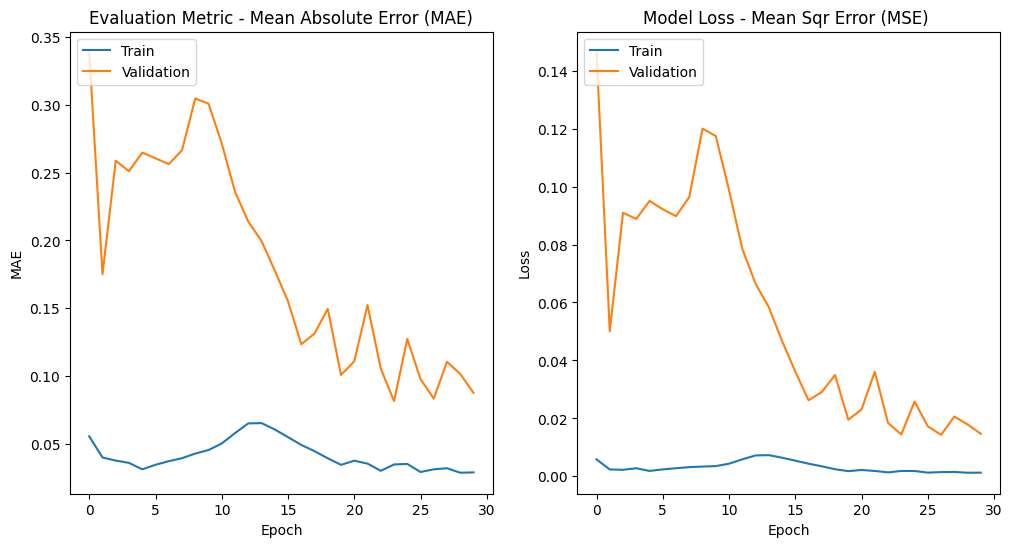

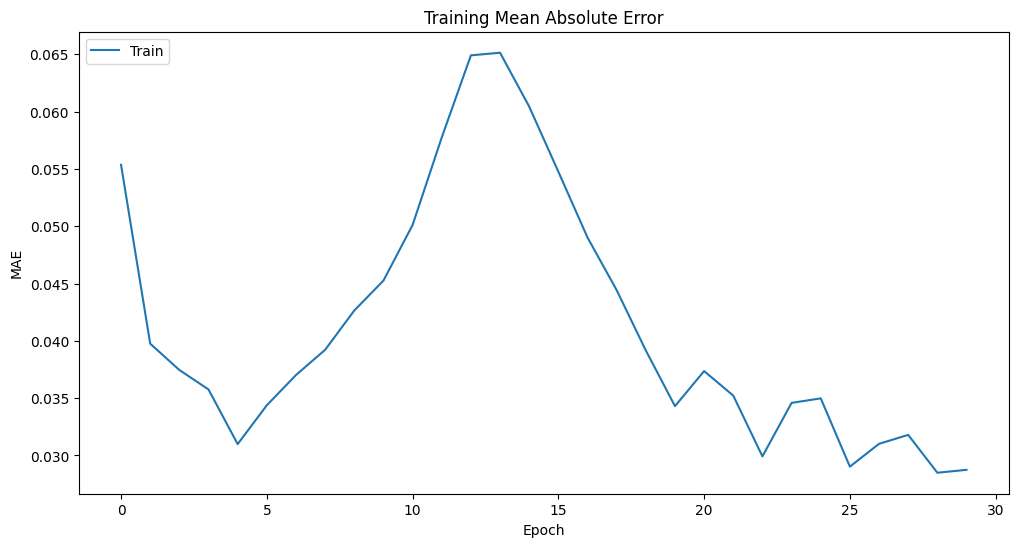

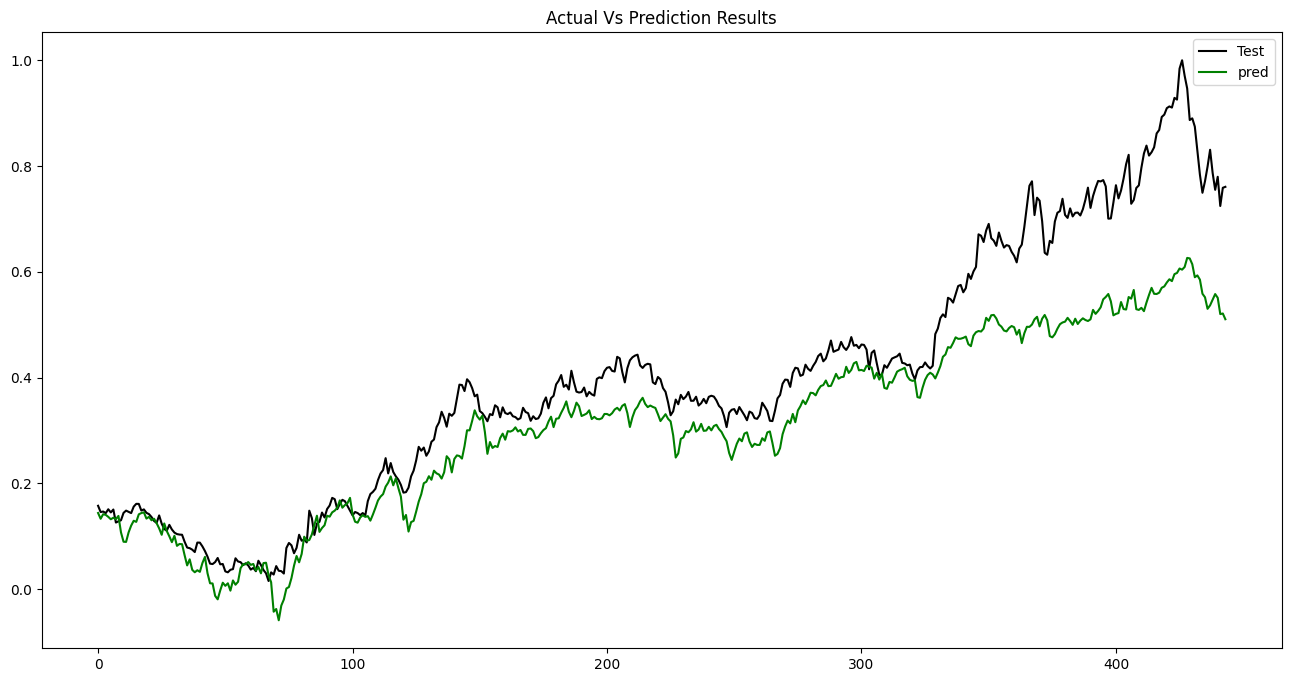

############################################################################
  Model Setup:
                    Name: XOM_F75_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.21788832911957406
             mean_sqr_err =0.06748159517168095
        root_mean_sqr_err =0.2597721986119395
           pred_diff_mean =0.6550411154480171
      pred_diff_bias_mean =0.34495888455198287
    pred_correctness_mean =0.46396396396396394
                      AIC =-1114.9797697884942



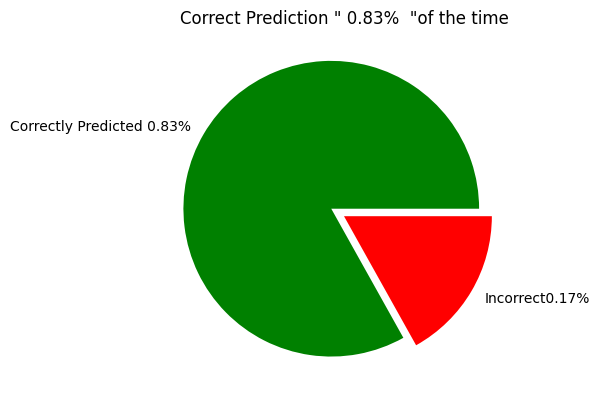

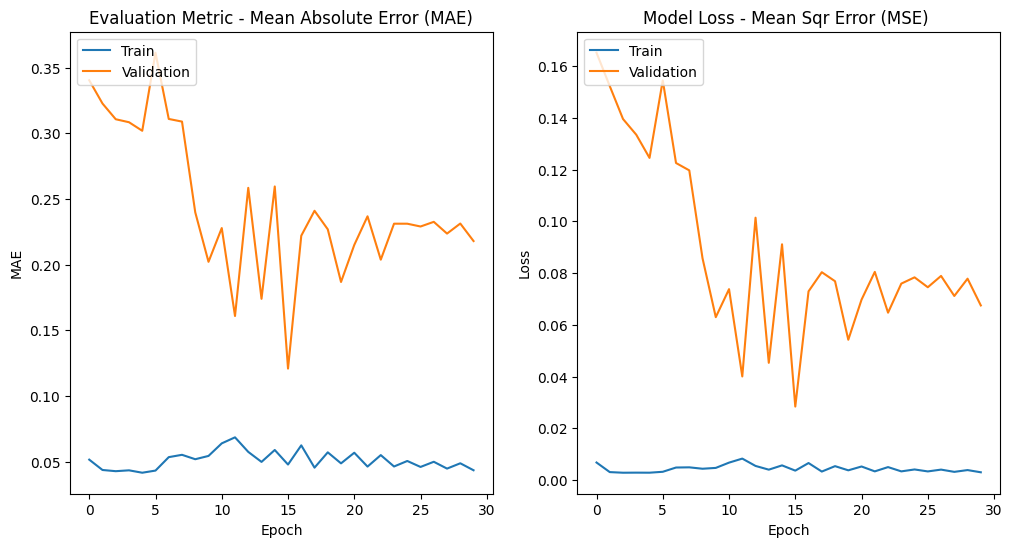

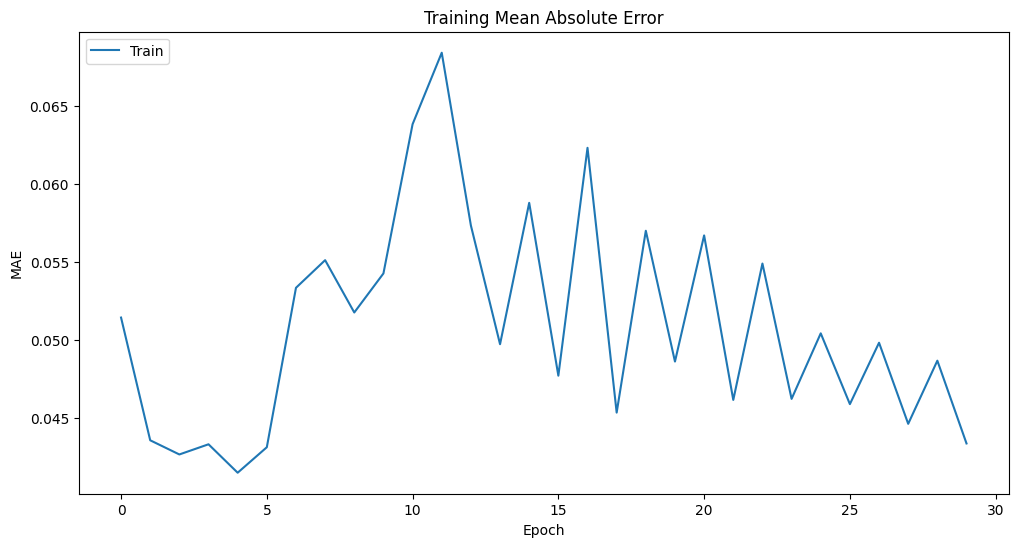

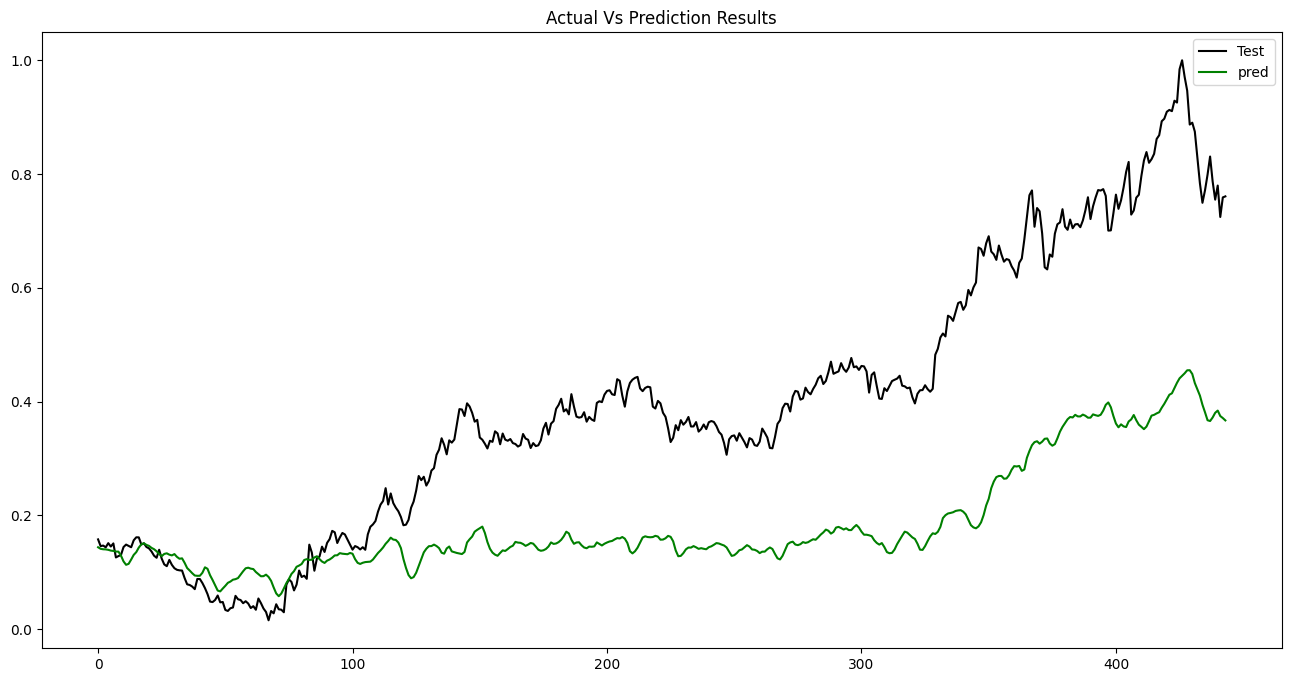

############################################################################
  Model Setup:
                    Name: XOM_F75_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.26602210686691313
             mean_sqr_err =0.10009092958329067
        root_mean_sqr_err =0.3163715056437458
           pred_diff_mean =0.514511892054607
      pred_diff_bias_mean =0.4854881079453929
    pred_correctness_mean =0.40765765765765766
                      AIC =-939.94423738215



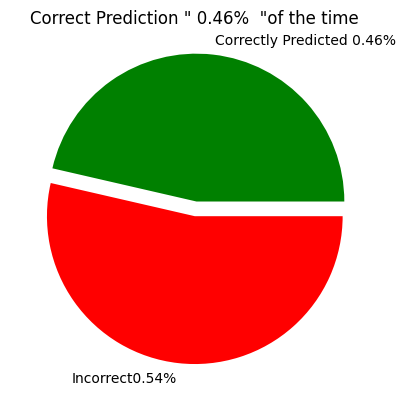

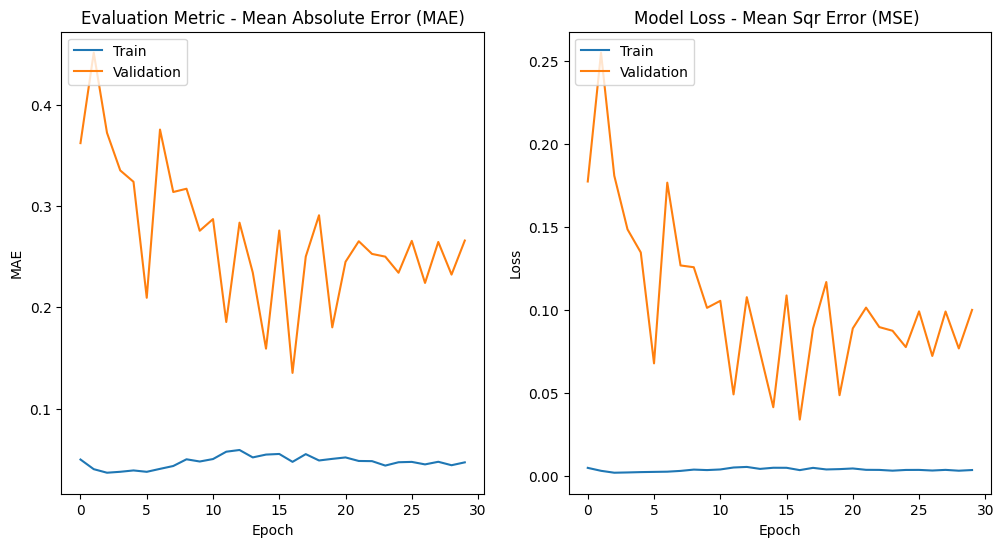

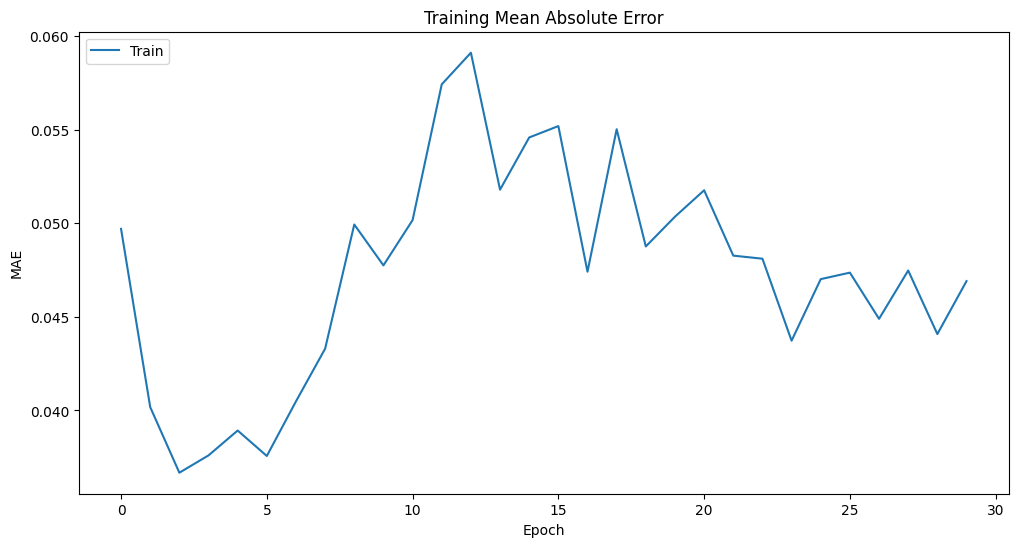

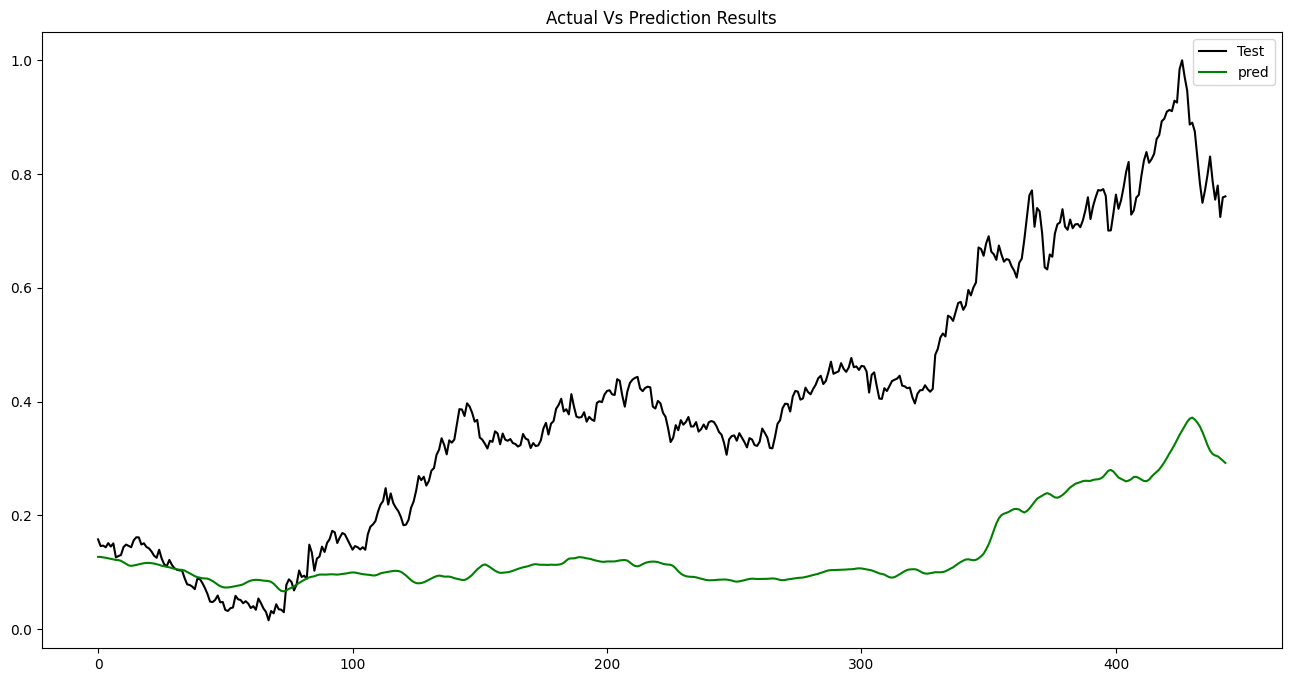

############################################################################
  Model Setup:
                    Name: XOM_F75_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.2720901067553037
             mean_sqr_err =0.11351865684427333
        root_mean_sqr_err =0.3369252986112401
           pred_diff_mean =0.6471675680733864
      pred_diff_bias_mean =0.35283243192661373
    pred_correctness_mean =0.43243243243243246
                      AIC =-884.0499066704475



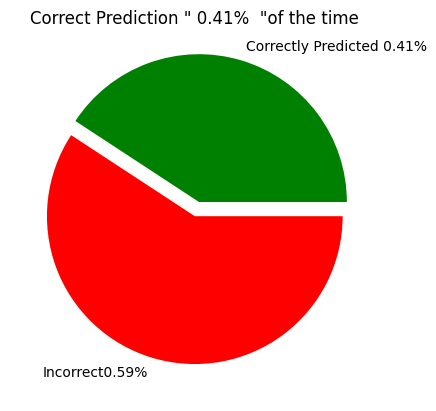

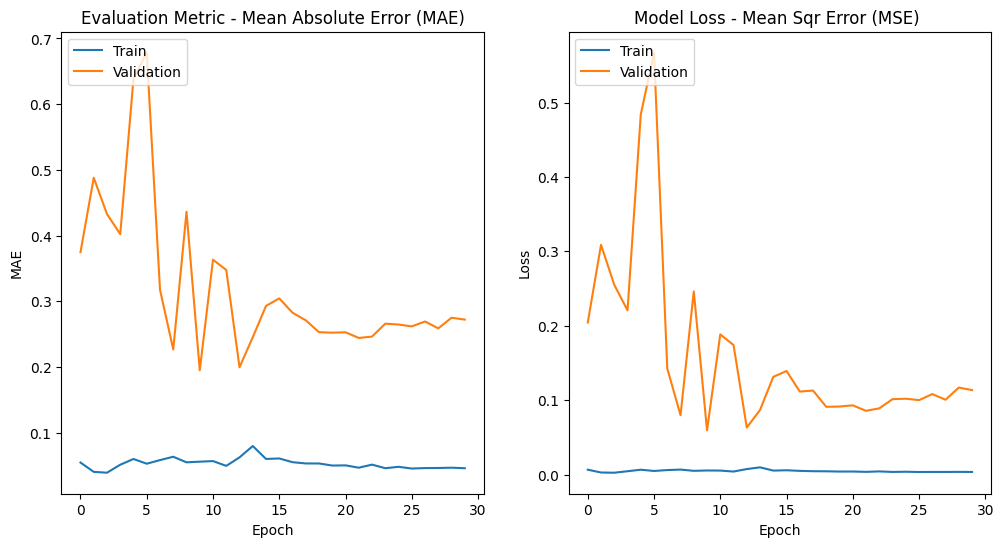

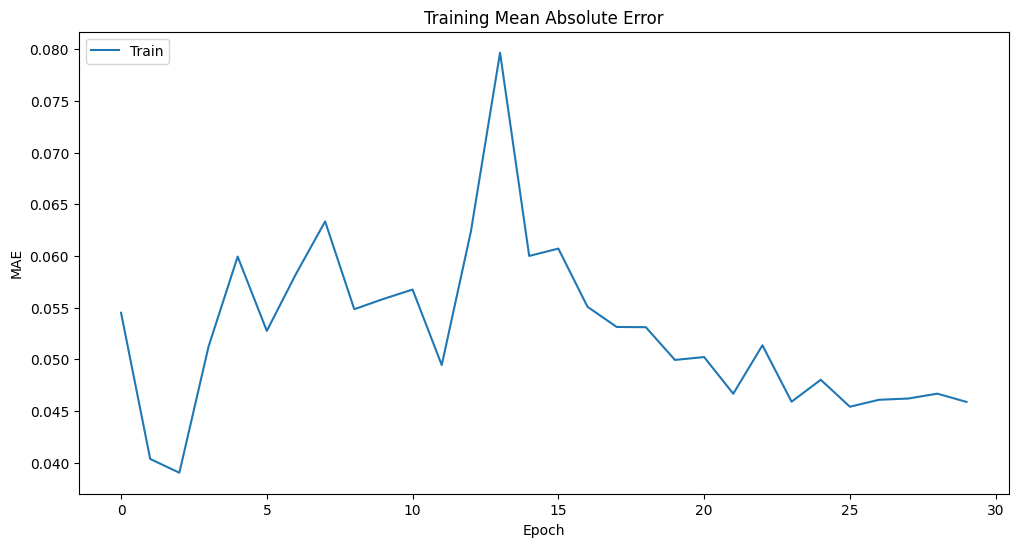

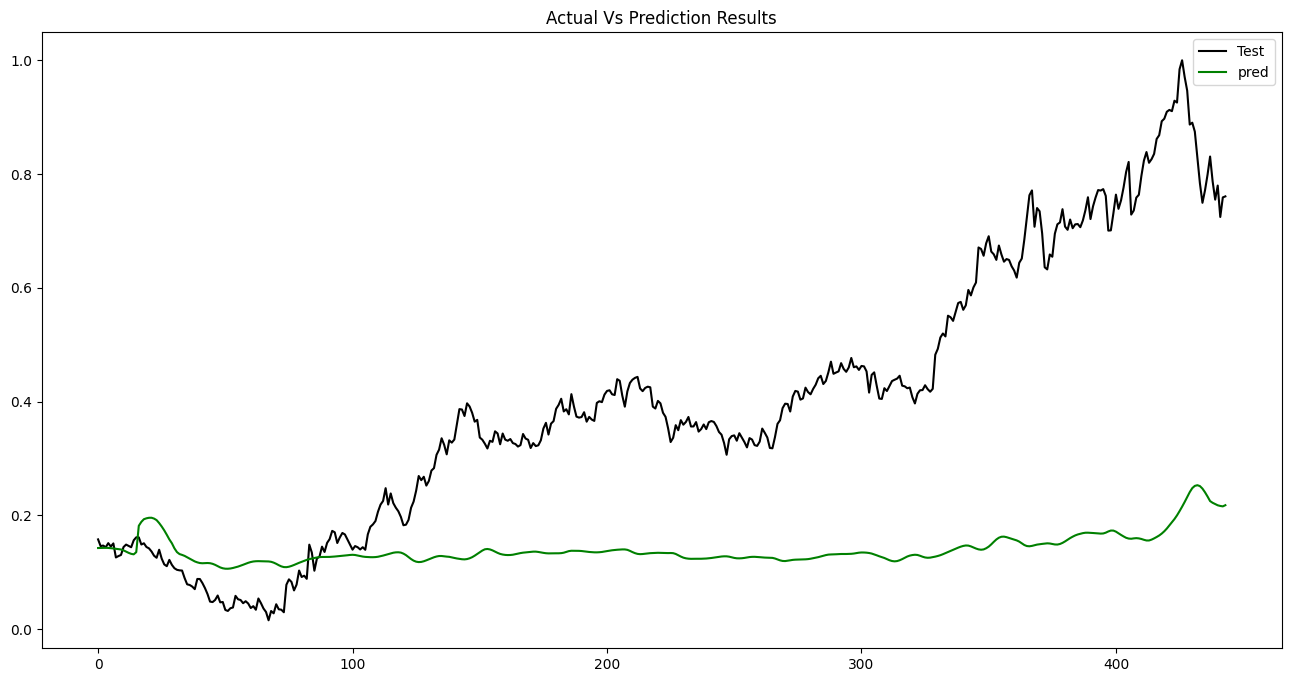

############################################################################
  Model Setup:
                    Name: XOM_F75_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.221859295406177
             mean_sqr_err =0.06944129013577159
        root_mean_sqr_err =0.2635171533994924
           pred_diff_mean =0.7764740232961205
      pred_diff_bias_mean =0.2235259767038797
    pred_correctness_mean =0.46396396396396394
                      AIC =-1102.2694915683546



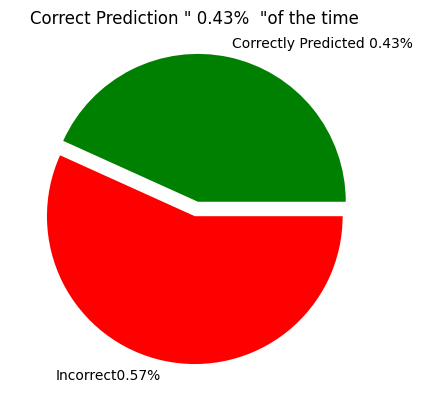

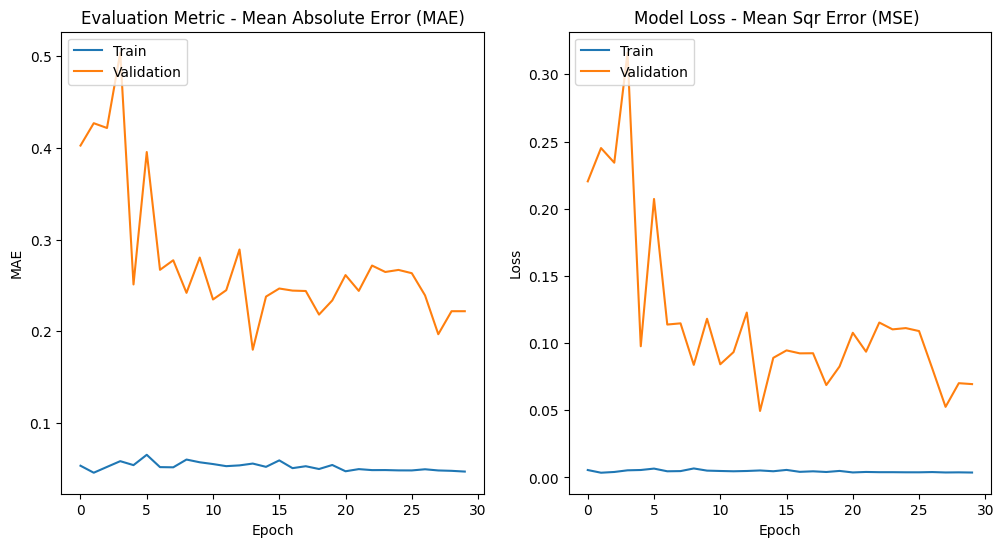

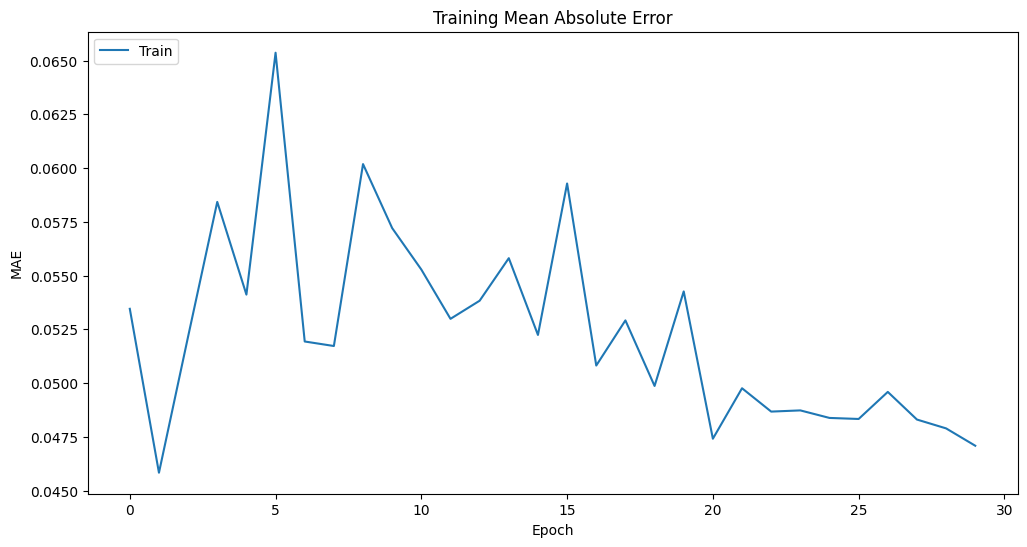

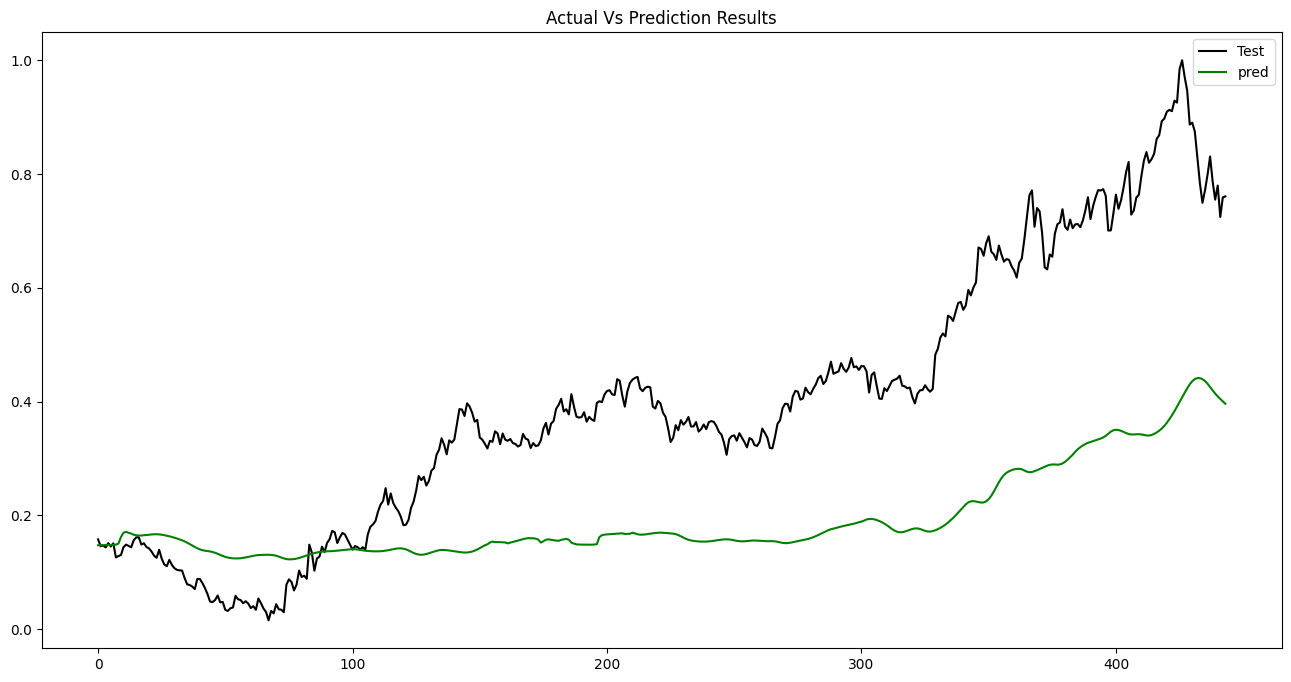

############################################################################
  Model Setup:
                    Name: XOM_F100_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.1340931977858424
             mean_sqr_err =0.026693494753358717
        root_mean_sqr_err =0.16338143943960928
           pred_diff_mean =0.7150868019628103
      pred_diff_bias_mean =0.28491319803718973
    pred_correctness_mean =0.7630979498861048
                      AIC =-1508.644234215982



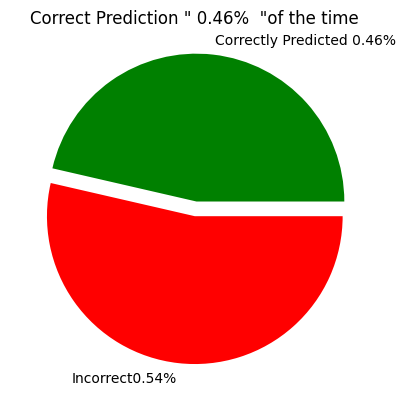

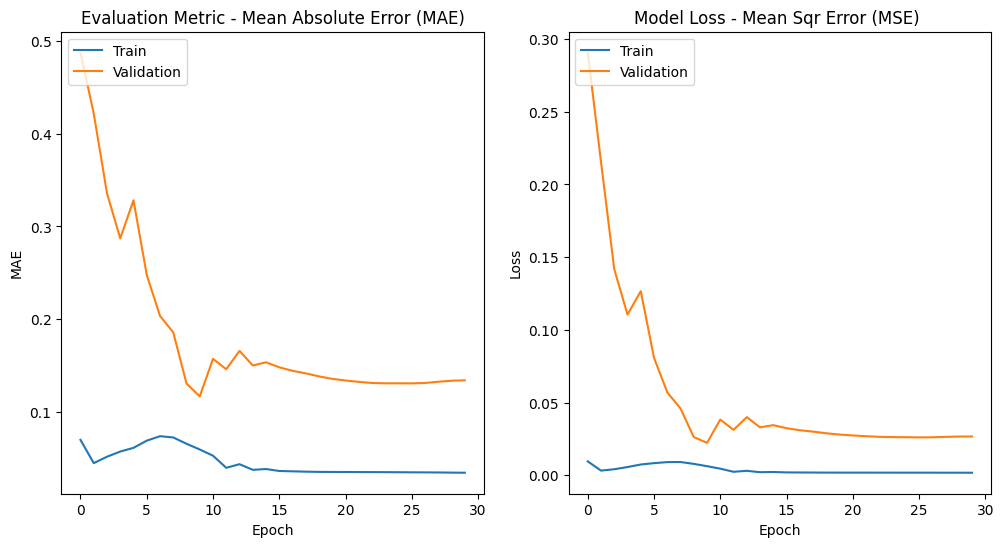

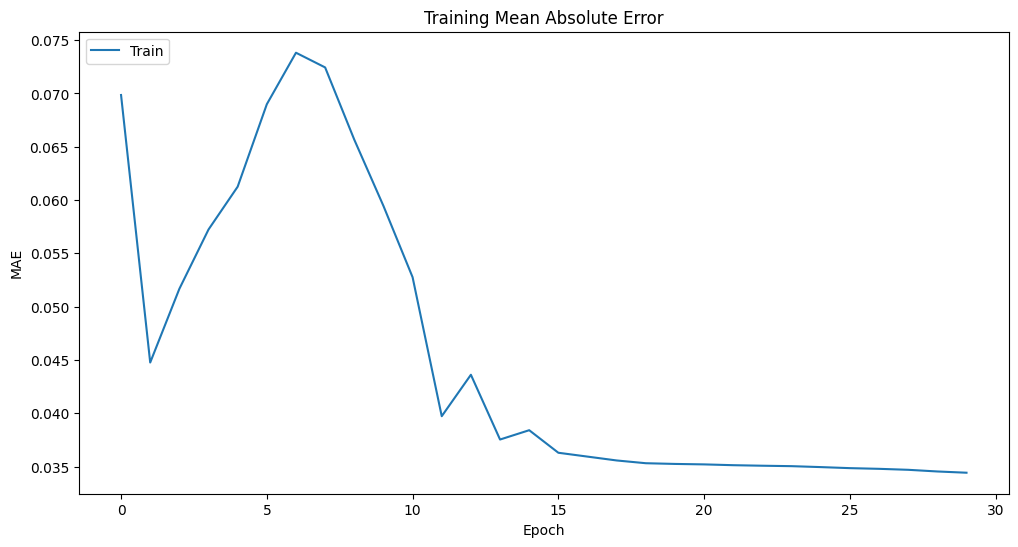

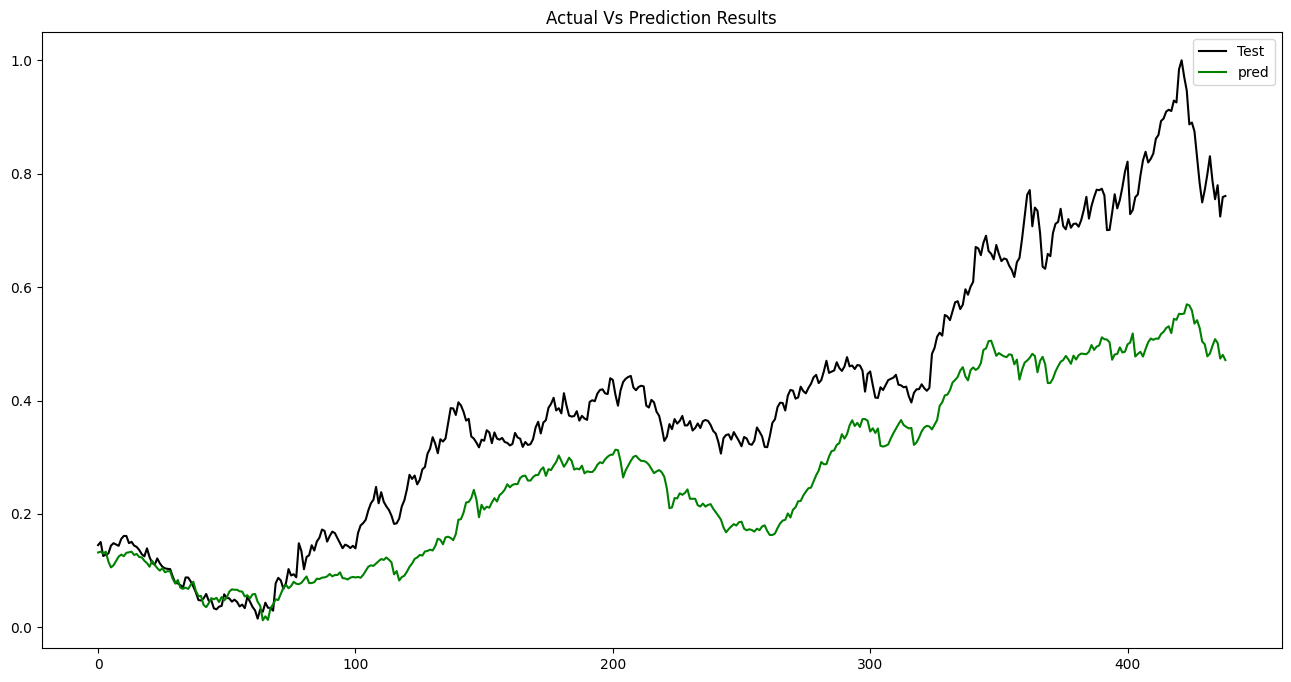

############################################################################
  Model Setup:
                    Name: XOM_F100_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.28830481038270345
             mean_sqr_err =0.11416311971603205
        root_mean_sqr_err =0.3378803334259513
           pred_diff_mean =0.432367369346926
      pred_diff_bias_mean =0.567632630653074
    pred_correctness_mean =0.4054669703872437
                      AIC =-870.6857436103757



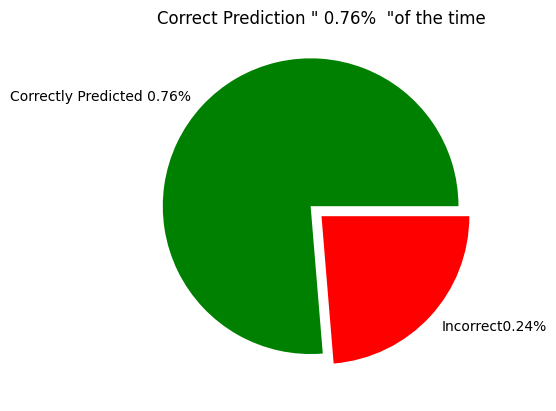

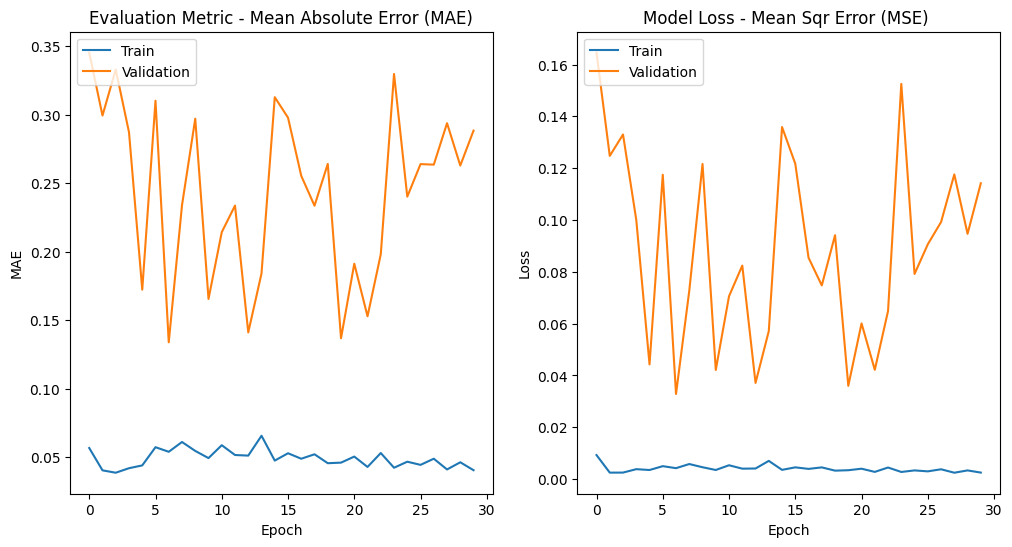

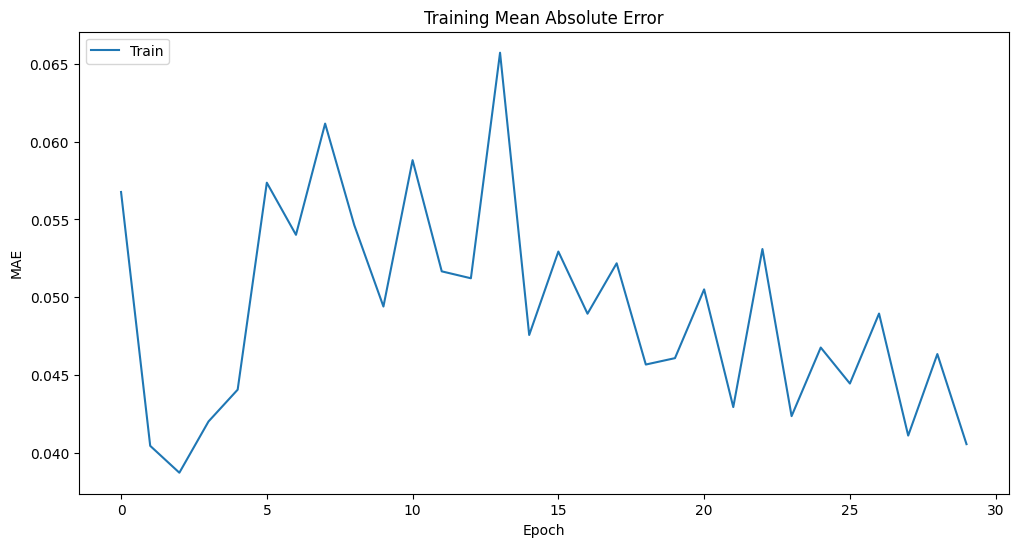

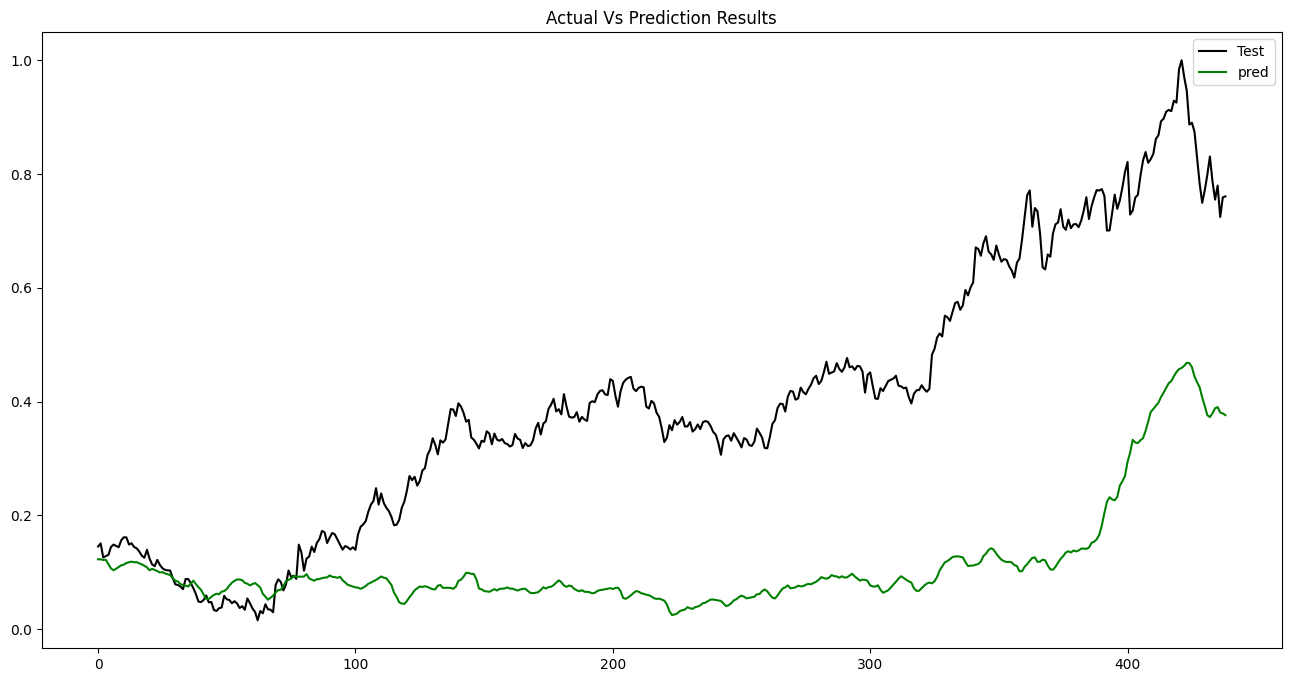

############################################################################
  Model Setup:
                    Name: XOM_F100_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.23785098804601584
             mean_sqr_err =0.08146845274584304
        root_mean_sqr_err =0.2854267905187651
           pred_diff_mean =0.6545840490475527
      pred_diff_bias_mean =0.3454159509524472
    pred_correctness_mean =0.44419134396355353
                      AIC =-1018.8098038629587



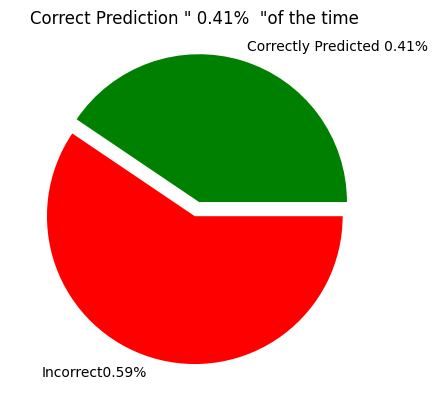

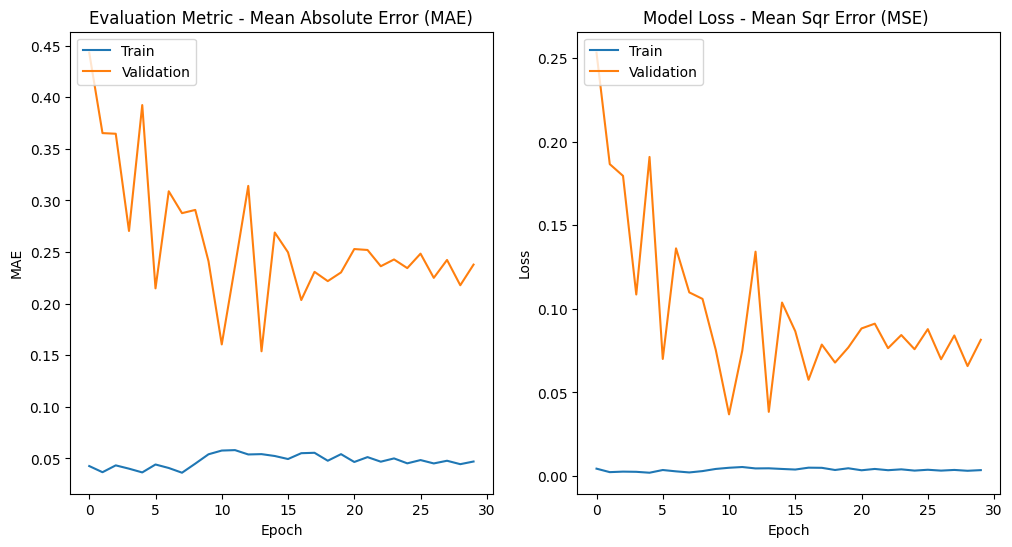

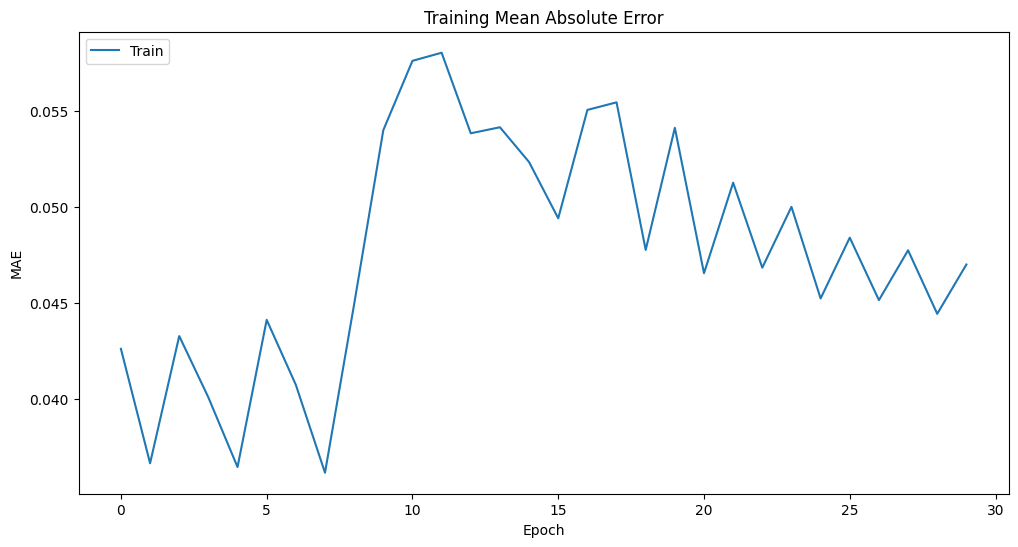

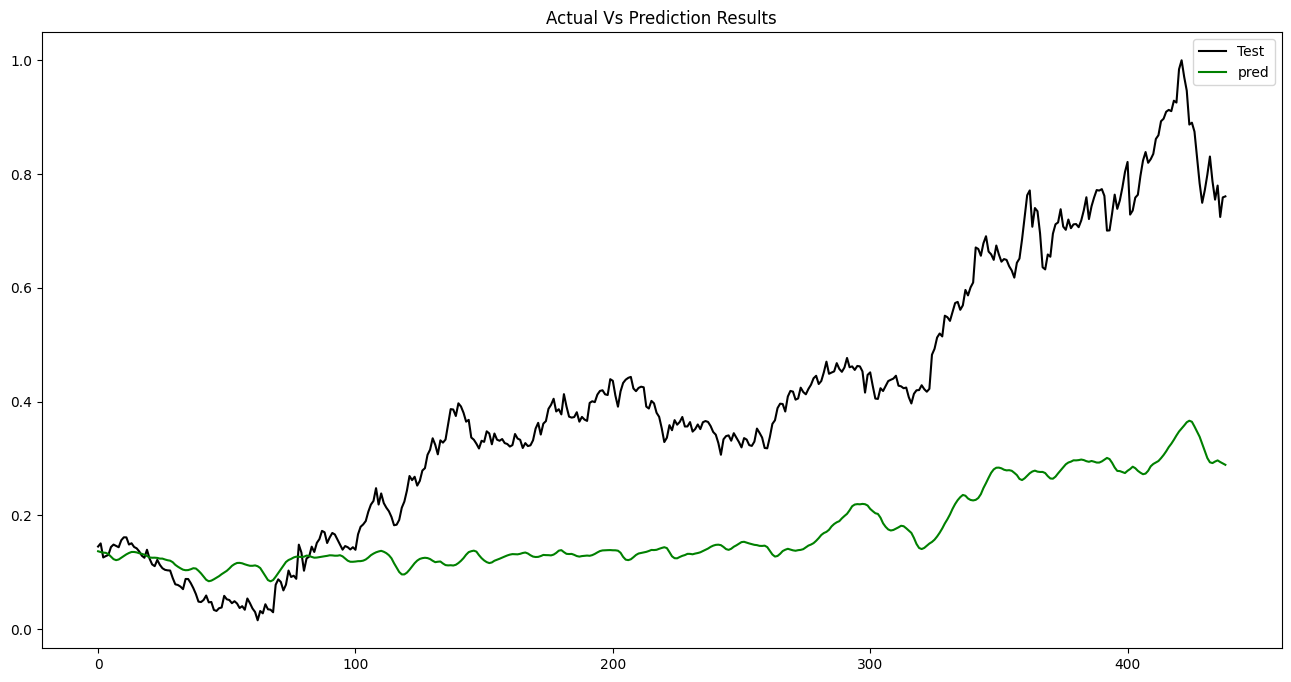

############################################################################
  Model Setup:
                    Name: XOM_F100_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.27111310262506694
             mean_sqr_err =0.11512270665881222
        root_mean_sqr_err =0.33929737201872373
           pred_diff_mean =0.6948871589659359
      pred_diff_bias_mean =0.3051128410340643
    pred_correctness_mean =0.4646924829157175
                      AIC =-867.0111935168222



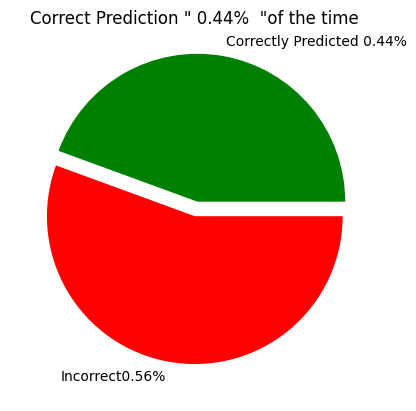

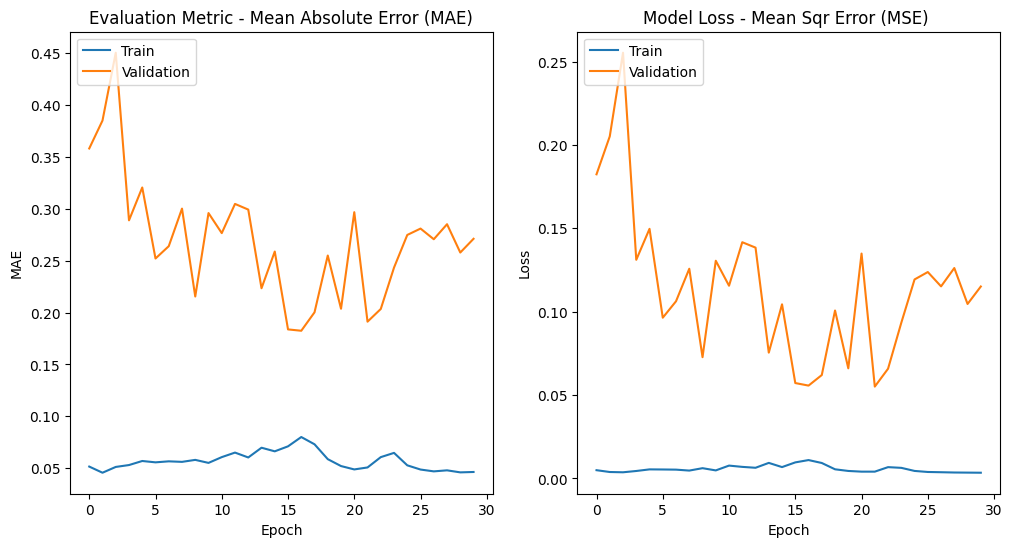

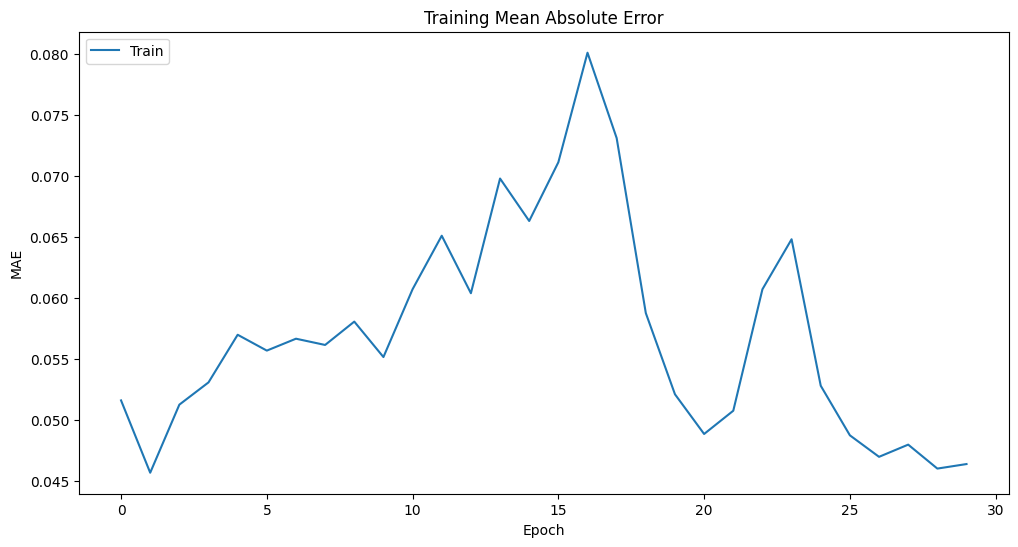

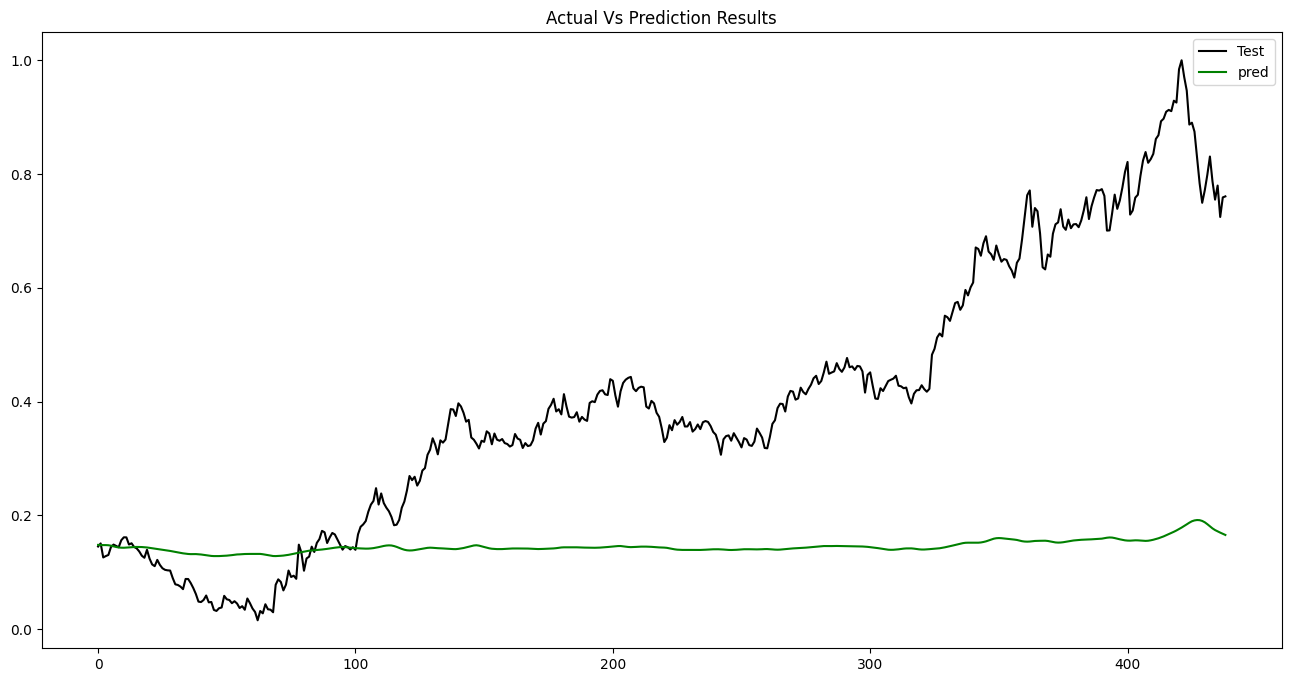

############################################################################
  Model Setup:
                    Name: XOM_F100_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.20585986376512472
             mean_sqr_err =0.06899628123461778
        root_mean_sqr_err =0.26267143208696636
           pred_diff_mean =1.6865870279361388
      pred_diff_bias_mean =-0.686587027936139
    pred_correctness_mean =0.4396355353075171
                      AIC =-1091.755472563618



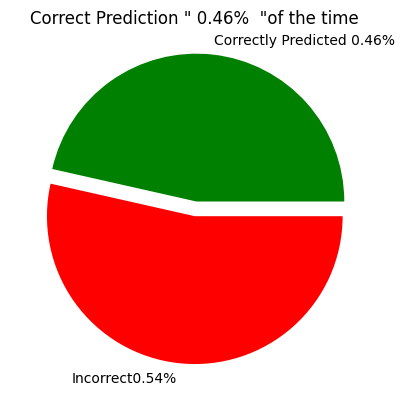

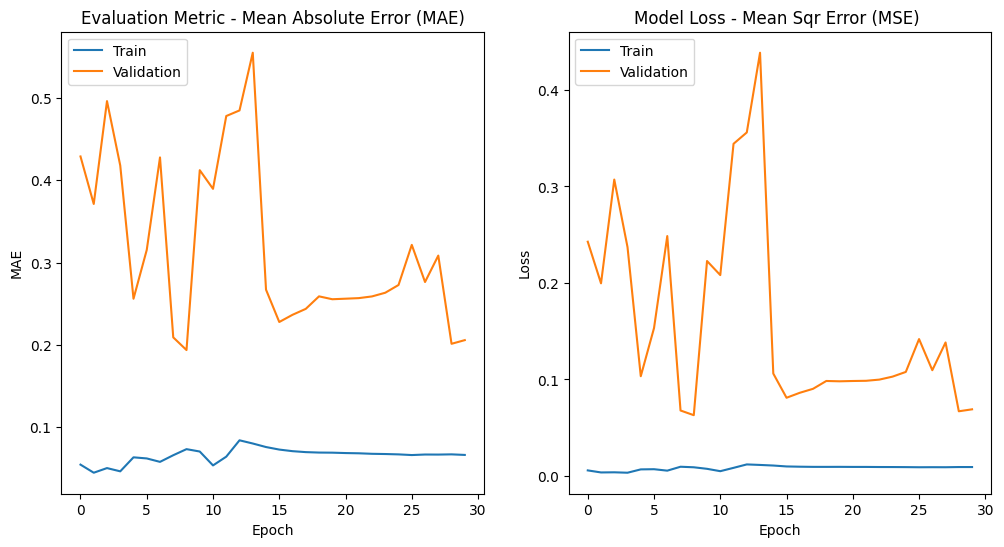

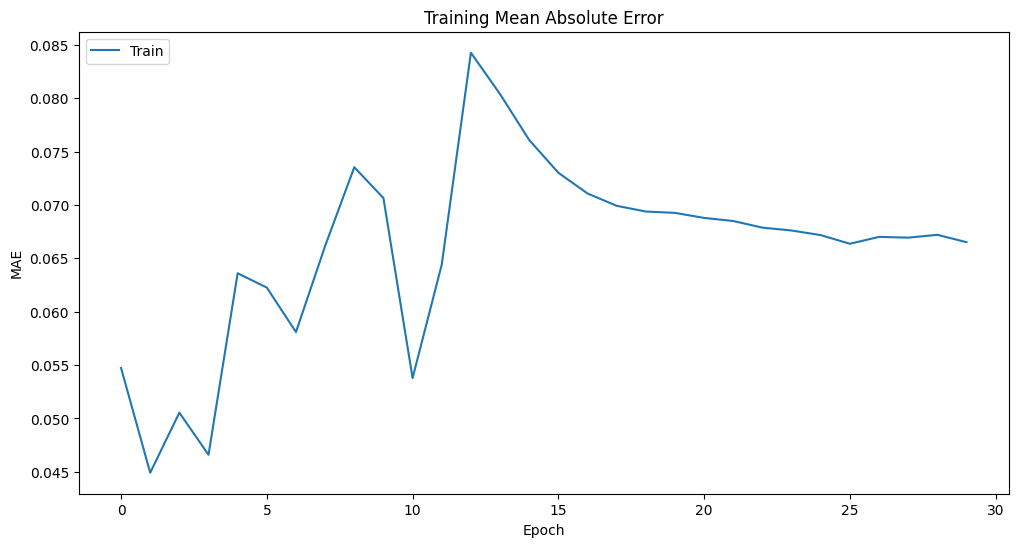

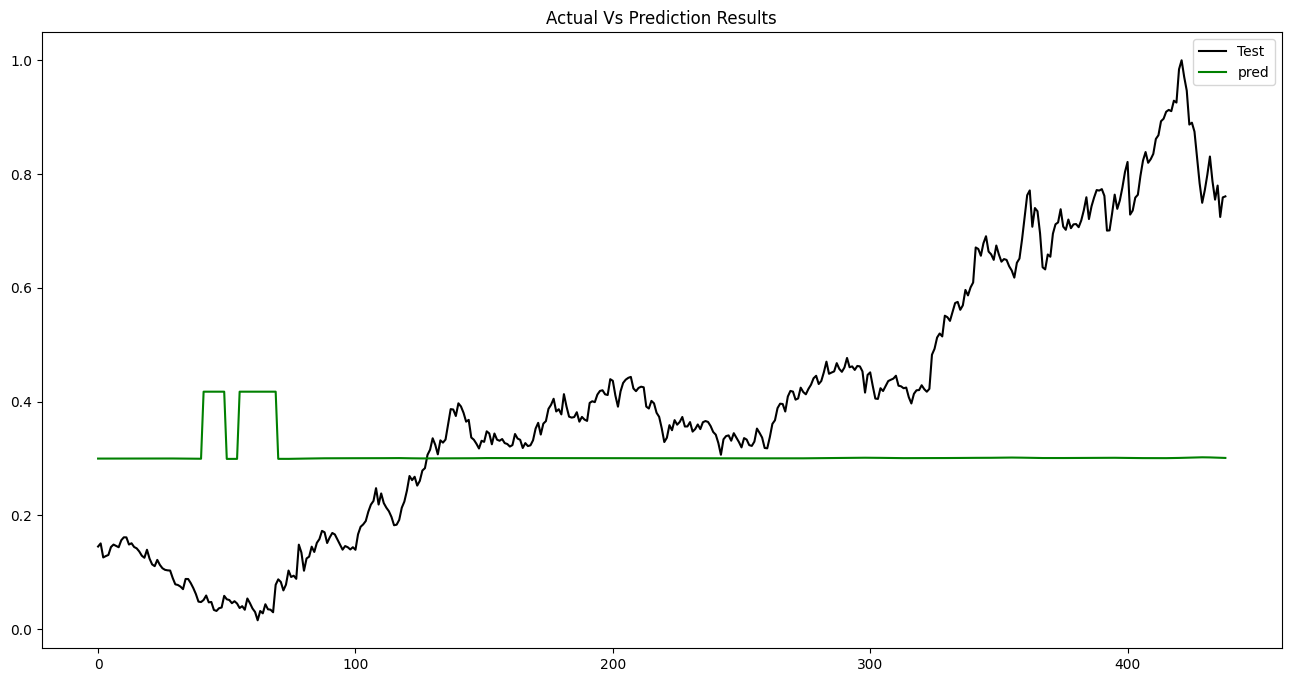

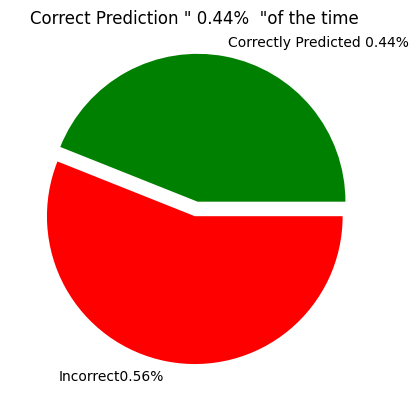

In [11]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


#Save Data
##Save Data to Drive

In [12]:
#_ls '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results'

##Save Best Model to drive